Versi 6 ini adalah revisi bimbingan dengan Bpk. Naufal

1. v6 adalah gallery akan diubah menjadi data face_aligned (porF) yang ada di folder trio_cam, dari yang sebelumnya campuran dari folder "portraits" dan karena kurangnya subjek di folder tersebut maka digabungkan dengan gambar wajah yang ada di folder "trio_cam"
2. v6.1 adalah versi inferensi tanpa tuning GFPGan

Kenapa kita ga usah hitung hipotenusa nya karena logika nya, kegagalan pada arcface adalah tidak dapat mendeteksi wajah, dimana hal ini berkaitan pada kondisi penangkapan citra yang tidak dapat melihat wajah subjek dengan jelas (hanya terlihat rambut dan sedikit dahi). Jadi klasifikasi nilai tinggi dan jarak harus dipisah. Kalau pake hipotenusa kita seolah mengabaikan dampak dari ketinggian yang berpengaruh pada model rekognisi


# Pipeline Rekognisi Wajah v6.1

1.  **Jalur A (Baseline):** Pengenalan wajah langsung pada citra asli (probe).
2.  **Jalur B (Dengan Peningkatan):** Pengenalan wajah pada citra setelah melalui proses restorasi kualitas menggunakan GFPGAN.


##### Impor Pustaka & Konfigurasi Path


In [3]:
import os
import sys
import glob
import cv2
import numpy as np
import json
import time
import pickle
import torch
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from deepface import DeepFace
from gfpgan import GFPGANer
import pyiqa
from scipy.spatial.distance import cosine
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [6]:
# --- Konfigurasi Path --- 
BASE_DIR = os.path.abspath('.')
PROJECT_ROOT = os.path.abspath(os.path.join(BASE_DIR, '..')) # Asumsi notebook ada di dalam subfolder proyek
GALLERY_PATH = os.path.join(BASE_DIR, 'data', 'gallery6.2')
PROBES_PATH = os.path.join(BASE_DIR, 'data', 'probes')
RESULTS_PATH = os.path.join(BASE_DIR, 'results_v6.2')
CACHE_PATH = os.path.join(BASE_DIR, 'cache_v6.2')

# --- Konfigurasi Path untuk Output Gambar ---
CROPPED_FACES_PATH = os.path.join(RESULTS_PATH, 'cropped_faces')
RESTORED_FACES_PATH = os.path.join(RESULTS_PATH, 'restored_faces')
RESTORED_IMGS_PATH = os.path.join(RESULTS_PATH, 'restored_imgs')
COMPARISON_PATH = os.path.join(RESULTS_PATH, 'cmp')

# --- Path File Cache ---
EMBEDDING_CACHE_FILE = os.path.join(CACHE_PATH, 'embedding_cache.pkl')

In [ ]:
# Pastikan semua direktori output ada, jika tidak maka buat direktori baru.
for path in [RESULTS_PATH, CACHE_PATH, CROPPED_FACES_PATH, RESTORED_FACES_PATH, RESTORED_IMGS_PATH, COMPARISON_PATH]:
    os.makedirs(path, exist_ok=True)

print(f"Notebook berjalan di direktori: {BASE_DIR}")
print(f"Hasil akan disimpan di: {RESULTS_PATH}")

Notebook berjalan di direktori: d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi
Hasil akan disimpan di: d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results_v6.2


##### Inisialisasi Model-Model Utama

Tahap ini memuat semua model yang diperlukan ke dalam memori (CPU atau GPU). Ini termasuk:

- **GFPGAN**: Untuk restorasi wajah.
- **pyiqa (BRISQUE & NIQE)**: Untuk penilaian kualitas gambar.
- **DeepFace (ArcFace)**: Untuk ekstraksi fitur (embedding) wajah. Dilakukan _warm-up_ agar pemrosesan pertama tidak lambat.


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Menggunakan device: {DEVICE}')

print("Memuat model GFPGAN v1.4...")
gfpgan_model_path = os.path.join(PROJECT_ROOT, 'model_gfpgan', 'gfpgan', 'weights', 'GFPGANv1.4.pth')
if not os.path.exists(gfpgan_model_path):
    print(f"ERROR: Model GFPGAN tidak ditemukan di {gfpgan_model_path}")

else:
    gfpgan_restorer = GFPGANer(
        model_path=gfpgan_model_path,
        upscale=2, 
        arch='clean',
        channel_multiplier=2,
        bg_upsampler=None,
        device=DEVICE
        
    )
    print("Model GFPGAN siap.")

# Inisialisasi IQA Assessors dari pyiqa
print("Memuat model BRISQUE (No-Reference IQA)...")
brisque_assessor = pyiqa.create_metric('brisque', device=DEVICE)
print("Model BRISQUE siap.")

print("Memuat model NIQE (No-Reference IQA)...")
niqe_assessor = pyiqa.create_metric('niqe', device=DEVICE)
print("Model NIQE siap.")
# === AKHIR TAMBAHAN ===

# Pre-load model DeepFace untuk 'warming up' agar inferensi pertama tidak lambat
print("Warm-up model DeepFace (ArcFace)...")
try:
    _ = DeepFace.represent(np.zeros((112, 112, 3), dtype=np.uint8), model_name='ArcFace', enforce_detection=False)
    print("Model DeepFace siap.")
except Exception as e:
    print(f"Gagal melakukan warm-up DeepFace: {e}")

Menggunakan device: cuda
Memuat model GFPGAN v1.4...
Model GFPGAN siap.
Memuat model BRISQUE (No-Reference IQA)...
Model BRISQUE siap.
Memuat model NIQE (No-Reference IQA)...
Model NIQE siap.
Warm-up model DeepFace (ArcFace)...
Model DeepFace siap.


### Langkah 4: Fungsi-Fungsi Utilitas


Update:

1. Menghapus Detector Backend (RetinaFace) jadi tidak ada deteksi lagi
2. Adaptasi Fungsi FindBestMatch untuk banyak refrensi wajah


In [12]:
def parse_filename(filename: str) -> dict | None:
    """
    Mengekstrak metadata dari nama file probe sesuai format yang ditentukan.
    Format: 'subject_X_height_Y_distance_Z.JPG'
    
    Args:
        filename (str): Path atau nama file gambar.
    
    Returns:
        dict: Dictionary berisi metadata jika parsing berhasil, atau None jika gagal.
    """
    try:
        base_name = os.path.basename(filename)
        parts = os.path.splitext(base_name)[0].split('_')
        if len(parts) < 5: return None

        subject_id, height_id, distance_id = parts[0], parts[2], parts[4]
        if height_id == 'na' or distance_id == 'na': return None

        distance_val = int(distance_id)
        distance_m = 17 - (distance_val / 2)

        height_m = 0
        if height_id == "0":
            height_m = 1.5
        else:
            height_m = int(height_id)

        return {
            'subject_id': subject_id,
            'distance_m': distance_m,
            'height_id': height_id,
            'height_m': height_m,
        }
    except (IndexError, ValueError):
        # Gagal parsing karena format nama file salah atau nilai tidak valid
        return None

def get_embedding(image_path_or_array, model_name='ArcFace', detector_backend='retinaface') -> list | None:
    """
    Menghasilkan vektor embedding dari sebuah gambar, DENGAN MELAKUKAN DETEKSI WAJAH.
    Fungsi ini bisa menerima path file atau array numpy BGR.
    """
    try:
        # Panggil DeepFace dengan deteksi wajah diaktifkan
        embedding_objs = DeepFace.represent(
            img_path=image_path_or_array,
            model_name=model_name,
            enforce_detection=True,  # WAJIB: Memastikan wajah harus terdeteksi
            detector_backend=detector_backend
        )
        # Ambil embedding dari wajah pertama yang terdeteksi
        return embedding_objs[0]['embedding']
    
    except Exception as e:
        return None


def find_best_match_by_similarity(probe_embedding: list, gallery_embeddings: dict) -> tuple[str | None, float]:
    """
    Mencari subjek di galeri yang paling cocok dengan embedding probe
    berdasarkan SKOR KEMIRIPAN TERTINGGI.
    """
    if probe_embedding is None or not gallery_embeddings:
        return None, -1.0 # Mengembalikan skor kemiripan minimum
    
    best_match_id = None
    # Inisialisasi dengan nilai kemiripan terendah yang mungkin
    max_overall_sim = -1.0 
    
    for subject_id, list_of_embeddings in gallery_embeddings.items():
        if not list_of_embeddings: continue

        # Hitung KEMIRIPAN probe ke semua embedding referensi
        # Perhatikan penggunaan "1 - cosine(...)"
        similarities = [1 - cosine(probe_embedding, gallery_emb) for gallery_emb in list_of_embeddings]
        
        # Ambil kemiripan TERBAIK (tertinggi) untuk subjek ini
        max_sim_for_subject = max(similarities)
        
        # Bandingkan dengan kemiripan terbaik yang pernah ditemukan
        if max_sim_for_subject > max_overall_sim:
            max_overall_sim = max_sim_for_subject
            best_match_id = subject_id
            
    return best_match_id, max_overall_sim

def get_nr_iqa_score(image_array, assessor):
    """Menghitung skor IQA untuk metrik No-Reference (butuh 1 gambar)."""
    if image_array is None or image_array.size == 0:
        return None
    try:
        img_rgb = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        img_tensor = torch.from_numpy(img_rgb).permute(2, 0, 1).unsqueeze(0) / 255.0
        score = assessor(img_tensor.to(DEVICE)).item()
        return score
    except Exception as e:
        return None

print("Fungsi utilitas siap digunakan.")

Fungsi utilitas siap digunakan.


### Langkah 5: Pembuatan Galeri Referensi

Proses ini mengekstrak fitur (embedding) dari setiap gambar di folder galeri. Hasilnya disimpan dalam sebuah dictionary `gallery_embeddings`, yang akan menjadi database referensi untuk pencocokan.


Update:

1. Buat galeri dengan Multi Embedding


In [5]:
from collections import defaultdict # Impor defaultdict untuk kode yang lebih bersih

gallery_embeddings = defaultdict(list) 

gallery_files = glob.glob(os.path.join(GALLERY_PATH, '*.jpg'))

if not gallery_files:
    print(f"PERINGATAN: Tidak ada gambar ditemukan di folder galeri: {GALLERY_PATH}")
else:
    print(f"Membuat database fitur dari {len(gallery_files)} gambar di galeri...")
    for g_file in tqdm(gallery_files, desc="Membangun Galeri"):
        # Asumsi nama file: subjekA_01.jpg, subjekA_02.jpg, dst.
        subject_id = os.path.basename(g_file).split('_')[0]
        embedding = get_embedding(g_file)
        
        if embedding is not None:
            gallery_embeddings[subject_id].append(embedding)
        else:
            print(f"Gagal membuat embedding untuk file galeri: {g_file}")

    print(f"Database fitur galeri berhasil dibuat untuk {len(gallery_embeddings)} subjek.")
    for subject, embeddings in gallery_embeddings.items():
        print(f"- Subjek: {subject}, Jumlah referensi: {len(embeddings)}")

Membuat database fitur dari 55 gambar di galeri...


Membangun Galeri:   0%|          | 0/55 [00:00<?, ?it/s]

Database fitur galeri berhasil dibuat untuk 11 subjek.
- Subjek: a, Jumlah referensi: 5
- Subjek: b, Jumlah referensi: 5
- Subjek: c, Jumlah referensi: 5
- Subjek: d, Jumlah referensi: 5
- Subjek: e, Jumlah referensi: 5
- Subjek: f, Jumlah referensi: 5
- Subjek: g, Jumlah referensi: 5
- Subjek: h, Jumlah referensi: 5
- Subjek: i, Jumlah referensi: 5
- Subjek: j, Jumlah referensi: 5
- Subjek: k, Jumlah referensi: 5


### Langkah 6: Eksekusi Pipeline Utama

Ini adalah inti dari notebook. Setiap gambar _probe_ akan diproses melalui dua jalur (A dan B). Semua hasil, termasuk prediksi, status keberhasilan, dan skor kualitas gambar, akan disimpan dalam list `results_v6` dan kemudian diekspor ke file JSON.


In [17]:
import os
import cv2
import glob
import json
import time
import pickle
import numpy as np
from tqdm import tqdm

try:
    with open(EMBEDDING_CACHE_FILE, 'rb') as f:
        embedding_cache = pickle.load(f)
    print(f"Berhasil memuat {len(embedding_cache)} embedding dari cache.")
except (FileNotFoundError, EOFError):
    embedding_cache = {}
    print("Cache embedding tidak ditemukan, akan membuat baru.")

probe_files = glob.glob(os.path.join(PROBES_PATH, '*.JPG'))
# [UBAH] Naikkan versi untuk menandai pipeline final
results_final = [] 

print(f"Memulai pemrosesan {len(probe_files)} citra uji...")
start_time = time.time()

for probe_path in tqdm(probe_files, desc="Memproses Probe"):
    metadata = parse_filename(probe_path)
    if not metadata:
        print(f"Skipping file dengan format nama salah: {os.path.basename(probe_path)}")
        continue
    else:
        print(metadata)

    probe_filename = os.path.basename(probe_path)
    ground_truth_id = metadata['subject_id']
    
    # --- Inisialisasi hasil untuk iterasi ini ---
    prediction_A, prediction_B = None, None
    is_correct_A, is_correct_B = False, False
    restoration_succeeded = False
    
    # Inisialisasi skor NR-IQA
    brisque_original, brisque_restored = None, None
    niqe_original, niqe_restored = None, None

    # --- Jalur A (Tanpa Restorasi) ---
    if probe_filename in embedding_cache:
        embedding_A = embedding_cache[probe_filename]
    else:
        embedding_A = get_embedding(probe_path)
        embedding_cache[probe_filename] = embedding_A
    
    if embedding_A is not None:
        prediction_A, confidence_score = find_best_match_by_similarity(embedding_A, gallery_embeddings)
        is_correct_A = (prediction_A == ground_truth_id)

    # --- Jalur B (Dengan Restorasi & Evaluasi NR-IQA) ---
    try:
        img_probe = cv2.imread(probe_path, cv2.IMREAD_COLOR)
        if img_probe is None:
            print(f"Gagal membaca gambar probe: {probe_filename}")
            continue

        # 1. Hitung NR-IQA pada gambar probe (sebelum restorasi)
        brisque_original = get_nr_iqa_score(img_probe, brisque_assessor)
        niqe_original = get_nr_iqa_score(img_probe, niqe_assessor)
        
        # 2. Lakukan restorasi dengan GFPGAN
        cropped_faces, restored_faces, restored_pasted_img = gfpgan_restorer.enhance(
            img_probe, has_aligned=True, only_center_face=False)
        
        if restored_faces and restored_faces[0] is not None:
            original_cropped_face = cropped_faces[0]
            restored_face = restored_faces[0]
            restoration_succeeded = True

            # --- Menyimpan semua jenis gambar output ---
            cv2.imwrite(os.path.join(CROPPED_FACES_PATH, probe_filename), original_cropped_face)
            cv2.imwrite(os.path.join(RESTORED_FACES_PATH, probe_filename), restored_face)
            if restored_pasted_img is not None:
                cv2.imwrite(os.path.join(RESTORED_IMGS_PATH, probe_filename), restored_pasted_img)
            
            # --- Membuat dan menyimpan gambar komparasi

            # --- Membuat dan menyimpan gambar komparasi ---
            try:
                h, w, _ = restored_face.shape
                # Resize wajah asli agar ukurannya sama dengan wajah restorasi untuk perbandingan
                upscaled_original = cv2.resize(original_cropped_face, (w, h), interpolation=cv2.INTER_CUBIC)
                comparison_image = np.concatenate((upscaled_original, restored_face), axis=1)
                cv2.imwrite(os.path.join(COMPARISON_PATH, probe_filename), comparison_image)
            except Exception as cmp_e:
                print(f"Gagal membuat gambar perbandingan untuk {probe_filename}: {cmp_e}")

            # 3. Hitung NR-IQA pada wajah yang direstorasi
            brisque_restored = get_nr_iqa_score(restored_face, brisque_assessor)
            niqe_restored = get_nr_iqa_score(restored_face, niqe_assessor)

            # 4. Lakukan rekognisi pada wajah yang direstorasi
            embedding_B = get_embedding(restored_face)
            if embedding_B is not None:
                prediction_B, confidence_score = find_best_match_by_similarity(embedding_B, gallery_embeddings)
                is_correct_B = (prediction_B == ground_truth_id)

    except Exception as e:
        print(f"Error saat memproses Jalur B untuk {probe_filename}: {e}")
        is_correct_B = False
        restoration_succeeded = False

    # --- Kumpulkan semua hasil ---
    results_final.append({
        'file': probe_filename,
        'metadata': metadata,
        'ground_truth': ground_truth_id,
        'prediction_A': prediction_A,
        'is_correct_A': is_correct_A,
        'prediction_B': prediction_B,
        'is_correct_B': is_correct_B,
        'restoration_succeeded': restoration_succeeded,
        'confidence_score': confidence_score,
        'brisque_original_img': brisque_original,
        'brisque_restored_face': brisque_restored,
        'niqe_original_img': niqe_original,
        'niqe_restored_face': niqe_restored,
    })

# --- Simpan Hasil dan Cache ---
end_time = time.time()
print(f"\nSelesai memproses {len(results_final)} citra uji dalam {end_time - start_time:.2f} detik.")

results_file_path = os.path.join(RESULTS_PATH, 'pipeline_results_final.json')
with open(results_file_path, 'w') as f:
    json.dump(results_final, f, indent=4)
print(f"Hasil akhir berhasil disimpan ke: {results_file_path}")

with open(EMBEDDING_CACHE_FILE, 'wb') as f:
    pickle.dump(embedding_cache, f)
print(f"Cache embedding berhasil disimpan.")

Cache embedding tidak ditemukan, akan membuat baru.
Memulai pemrosesan 1364 citra uji...


Memproses Probe:   0%|          | 0/1364 [00:00<?, ?it/s]

{'subject_id': 'a', 'distance_m': 17.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   0%|          | 1/1364 [00:08<3:19:28,  8.78s/it]

{'subject_id': 'a', 'distance_m': 16.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   0%|          | 2/1364 [00:17<3:14:46,  8.58s/it]

{'subject_id': 'a', 'distance_m': 16.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   0%|          | 3/1364 [00:25<3:14:22,  8.57s/it]

{'subject_id': 'a', 'distance_m': 15.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   0%|          | 4/1364 [00:33<3:08:07,  8.30s/it]

{'subject_id': 'a', 'distance_m': 15.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   0%|          | 5/1364 [00:41<3:05:02,  8.17s/it]

{'subject_id': 'a', 'distance_m': 14.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   0%|          | 6/1364 [00:50<3:08:09,  8.31s/it]

{'subject_id': 'a', 'distance_m': 14.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   1%|          | 7/1364 [00:58<3:10:50,  8.44s/it]

{'subject_id': 'a', 'distance_m': 13.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   1%|          | 8/1364 [01:07<3:15:13,  8.64s/it]

{'subject_id': 'a', 'distance_m': 13.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   1%|          | 9/1364 [01:17<3:19:50,  8.85s/it]

{'subject_id': 'a', 'distance_m': 12.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   1%|          | 10/1364 [01:26<3:20:38,  8.89s/it]

{'subject_id': 'a', 'distance_m': 12.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   1%|          | 11/1364 [01:34<3:15:39,  8.68s/it]

{'subject_id': 'a', 'distance_m': 11.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   1%|          | 12/1364 [01:42<3:14:09,  8.62s/it]

{'subject_id': 'a', 'distance_m': 11.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   1%|          | 13/1364 [01:50<3:10:11,  8.45s/it]

{'subject_id': 'a', 'distance_m': 10.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   1%|          | 14/1364 [01:59<3:10:14,  8.46s/it]

{'subject_id': 'a', 'distance_m': 10.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   1%|          | 15/1364 [02:08<3:13:35,  8.61s/it]

{'subject_id': 'a', 'distance_m': 9.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   1%|          | 16/1364 [02:17<3:14:16,  8.65s/it]

{'subject_id': 'a', 'distance_m': 9.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   1%|          | 17/1364 [02:25<3:12:06,  8.56s/it]

{'subject_id': 'a', 'distance_m': 8.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   1%|▏         | 18/1364 [02:34<3:12:38,  8.59s/it]

{'subject_id': 'a', 'distance_m': 8.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   1%|▏         | 19/1364 [02:43<3:16:45,  8.78s/it]

{'subject_id': 'a', 'distance_m': 7.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   1%|▏         | 20/1364 [02:52<3:16:39,  8.78s/it]

{'subject_id': 'a', 'distance_m': 7.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   2%|▏         | 21/1364 [03:00<3:14:03,  8.67s/it]

{'subject_id': 'a', 'distance_m': 6.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   2%|▏         | 22/1364 [03:08<3:11:52,  8.58s/it]

{'subject_id': 'a', 'distance_m': 6.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   2%|▏         | 23/1364 [03:17<3:12:52,  8.63s/it]

{'subject_id': 'a', 'distance_m': 5.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   2%|▏         | 24/1364 [03:26<3:12:09,  8.60s/it]

{'subject_id': 'a', 'distance_m': 5.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   2%|▏         | 25/1364 [03:35<3:13:10,  8.66s/it]

{'subject_id': 'a', 'distance_m': 4.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   2%|▏         | 26/1364 [03:44<3:16:46,  8.82s/it]

{'subject_id': 'a', 'distance_m': 4.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   2%|▏         | 27/1364 [03:53<3:17:54,  8.88s/it]

{'subject_id': 'a', 'distance_m': 3.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   2%|▏         | 28/1364 [04:02<3:19:04,  8.94s/it]

{'subject_id': 'a', 'distance_m': 3.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   2%|▏         | 29/1364 [04:11<3:18:05,  8.90s/it]

{'subject_id': 'a', 'distance_m': 2.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   2%|▏         | 30/1364 [04:19<3:15:20,  8.79s/it]

{'subject_id': 'a', 'distance_m': 2.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   2%|▏         | 31/1364 [04:28<3:14:45,  8.77s/it]

{'subject_id': 'a', 'distance_m': 17.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:   2%|▏         | 32/1364 [04:36<3:11:10,  8.61s/it]

{'subject_id': 'a', 'distance_m': 16.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:   2%|▏         | 33/1364 [04:45<3:12:04,  8.66s/it]

{'subject_id': 'a', 'distance_m': 16.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:   2%|▏         | 34/1364 [04:54<3:15:31,  8.82s/it]

{'subject_id': 'a', 'distance_m': 15.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:   3%|▎         | 35/1364 [05:03<3:17:19,  8.91s/it]

{'subject_id': 'a', 'distance_m': 15.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:   3%|▎         | 36/1364 [05:11<3:11:50,  8.67s/it]

{'subject_id': 'a', 'distance_m': 14.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:   3%|▎         | 37/1364 [05:19<3:07:05,  8.46s/it]

{'subject_id': 'a', 'distance_m': 14.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:   3%|▎         | 38/1364 [05:28<3:08:37,  8.54s/it]

{'subject_id': 'a', 'distance_m': 13.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:   3%|▎         | 39/1364 [05:36<3:07:23,  8.49s/it]

{'subject_id': 'a', 'distance_m': 13.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:   3%|▎         | 40/1364 [05:44<3:02:48,  8.28s/it]

{'subject_id': 'a', 'distance_m': 12.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:   3%|▎         | 41/1364 [05:52<3:00:28,  8.18s/it]

{'subject_id': 'a', 'distance_m': 12.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:   3%|▎         | 42/1364 [06:00<3:01:13,  8.23s/it]

{'subject_id': 'a', 'distance_m': 11.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:   3%|▎         | 43/1364 [06:08<2:59:07,  8.14s/it]

{'subject_id': 'a', 'distance_m': 11.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:   3%|▎         | 44/1364 [06:17<2:59:31,  8.16s/it]

{'subject_id': 'a', 'distance_m': 10.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:   3%|▎         | 45/1364 [06:25<3:04:15,  8.38s/it]

{'subject_id': 'a', 'distance_m': 10.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:   3%|▎         | 46/1364 [06:34<3:07:35,  8.54s/it]

{'subject_id': 'a', 'distance_m': 9.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:   3%|▎         | 47/1364 [06:42<3:04:03,  8.39s/it]

{'subject_id': 'a', 'distance_m': 9.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:   4%|▎         | 48/1364 [06:50<2:58:52,  8.16s/it]

{'subject_id': 'a', 'distance_m': 8.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:   4%|▎         | 49/1364 [06:58<2:59:02,  8.17s/it]

{'subject_id': 'a', 'distance_m': 8.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:   4%|▎         | 50/1364 [07:06<2:58:22,  8.14s/it]

{'subject_id': 'a', 'distance_m': 7.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:   4%|▎         | 51/1364 [07:14<2:57:27,  8.11s/it]

{'subject_id': 'a', 'distance_m': 7.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:   4%|▍         | 52/1364 [07:23<2:57:38,  8.12s/it]

{'subject_id': 'a', 'distance_m': 6.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:   4%|▍         | 53/1364 [07:31<2:58:10,  8.15s/it]

{'subject_id': 'a', 'distance_m': 6.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:   4%|▍         | 54/1364 [07:39<2:56:34,  8.09s/it]

{'subject_id': 'a', 'distance_m': 5.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:   4%|▍         | 55/1364 [07:47<2:55:02,  8.02s/it]

{'subject_id': 'a', 'distance_m': 5.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:   4%|▍         | 56/1364 [07:54<2:53:51,  7.98s/it]

{'subject_id': 'a', 'distance_m': 4.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:   4%|▍         | 57/1364 [08:02<2:53:38,  7.97s/it]

{'subject_id': 'a', 'distance_m': 4.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:   4%|▍         | 58/1364 [08:10<2:53:15,  7.96s/it]

{'subject_id': 'a', 'distance_m': 3.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:   4%|▍         | 59/1364 [08:18<2:52:42,  7.94s/it]

{'subject_id': 'a', 'distance_m': 3.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:   4%|▍         | 60/1364 [08:26<2:52:55,  7.96s/it]

{'subject_id': 'a', 'distance_m': 2.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:   4%|▍         | 61/1364 [08:34<2:52:54,  7.96s/it]

{'subject_id': 'a', 'distance_m': 2.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:   5%|▍         | 62/1364 [08:42<2:52:43,  7.96s/it]

{'subject_id': 'a', 'distance_m': 17.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:   5%|▍         | 63/1364 [08:51<2:59:02,  8.26s/it]

{'subject_id': 'a', 'distance_m': 16.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:   5%|▍         | 64/1364 [08:59<2:57:21,  8.19s/it]

{'subject_id': 'a', 'distance_m': 16.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:   5%|▍         | 65/1364 [09:07<2:56:10,  8.14s/it]

{'subject_id': 'a', 'distance_m': 15.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:   5%|▍         | 66/1364 [09:15<2:56:29,  8.16s/it]

{'subject_id': 'a', 'distance_m': 15.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:   5%|▍         | 67/1364 [09:23<2:54:24,  8.07s/it]

{'subject_id': 'a', 'distance_m': 14.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:   5%|▍         | 68/1364 [09:31<2:53:27,  8.03s/it]

{'subject_id': 'a', 'distance_m': 14.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:   5%|▌         | 69/1364 [09:39<2:52:24,  7.99s/it]

{'subject_id': 'a', 'distance_m': 13.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:   5%|▌         | 70/1364 [09:47<2:51:17,  7.94s/it]

{'subject_id': 'a', 'distance_m': 13.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:   5%|▌         | 71/1364 [09:55<2:50:45,  7.92s/it]

{'subject_id': 'a', 'distance_m': 12.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:   5%|▌         | 72/1364 [10:03<2:50:36,  7.92s/it]

{'subject_id': 'a', 'distance_m': 12.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:   5%|▌         | 73/1364 [10:11<2:49:59,  7.90s/it]

{'subject_id': 'a', 'distance_m': 11.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:   5%|▌         | 74/1364 [10:18<2:49:07,  7.87s/it]

{'subject_id': 'a', 'distance_m': 11.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:   5%|▌         | 75/1364 [10:27<2:52:02,  8.01s/it]

{'subject_id': 'a', 'distance_m': 10.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:   6%|▌         | 76/1364 [10:35<2:51:51,  8.01s/it]

{'subject_id': 'a', 'distance_m': 10.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:   6%|▌         | 77/1364 [10:42<2:50:45,  7.96s/it]

{'subject_id': 'a', 'distance_m': 9.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:   6%|▌         | 78/1364 [10:50<2:49:25,  7.90s/it]

{'subject_id': 'a', 'distance_m': 9.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:   6%|▌         | 79/1364 [10:58<2:49:35,  7.92s/it]

{'subject_id': 'a', 'distance_m': 8.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:   6%|▌         | 80/1364 [11:06<2:50:31,  7.97s/it]

{'subject_id': 'a', 'distance_m': 8.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:   6%|▌         | 81/1364 [11:14<2:49:42,  7.94s/it]

{'subject_id': 'a', 'distance_m': 7.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:   6%|▌         | 82/1364 [11:22<2:49:02,  7.91s/it]

{'subject_id': 'a', 'distance_m': 7.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:   6%|▌         | 83/1364 [11:30<2:49:27,  7.94s/it]

{'subject_id': 'a', 'distance_m': 6.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:   6%|▌         | 84/1364 [11:38<2:51:00,  8.02s/it]

{'subject_id': 'a', 'distance_m': 6.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:   6%|▌         | 85/1364 [11:46<2:51:47,  8.06s/it]

{'subject_id': 'a', 'distance_m': 5.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:   6%|▋         | 86/1364 [11:54<2:50:13,  7.99s/it]

{'subject_id': 'a', 'distance_m': 5.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:   6%|▋         | 87/1364 [12:02<2:48:58,  7.94s/it]

{'subject_id': 'a', 'distance_m': 4.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:   6%|▋         | 88/1364 [12:10<2:51:46,  8.08s/it]

{'subject_id': 'a', 'distance_m': 4.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:   7%|▋         | 89/1364 [12:18<2:50:57,  8.05s/it]

{'subject_id': 'a', 'distance_m': 3.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:   7%|▋         | 90/1364 [12:27<2:52:01,  8.10s/it]

{'subject_id': 'a', 'distance_m': 3.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:   7%|▋         | 91/1364 [12:35<2:50:45,  8.05s/it]

{'subject_id': 'a', 'distance_m': 2.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:   7%|▋         | 92/1364 [12:42<2:49:57,  8.02s/it]

{'subject_id': 'a', 'distance_m': 2.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:   7%|▋         | 93/1364 [12:51<2:50:51,  8.07s/it]

{'subject_id': 'a', 'distance_m': 17.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:   7%|▋         | 94/1364 [13:00<2:55:37,  8.30s/it]

{'subject_id': 'a', 'distance_m': 16.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:   7%|▋         | 95/1364 [13:08<2:57:10,  8.38s/it]

{'subject_id': 'a', 'distance_m': 16.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:   7%|▋         | 96/1364 [13:16<2:53:33,  8.21s/it]

{'subject_id': 'a', 'distance_m': 15.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:   7%|▋         | 97/1364 [13:24<2:50:39,  8.08s/it]

{'subject_id': 'a', 'distance_m': 15.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:   7%|▋         | 98/1364 [13:32<2:48:54,  8.00s/it]

{'subject_id': 'a', 'distance_m': 14.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:   7%|▋         | 99/1364 [13:39<2:48:18,  7.98s/it]

{'subject_id': 'a', 'distance_m': 14.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:   7%|▋         | 100/1364 [13:47<2:47:34,  7.95s/it]

{'subject_id': 'a', 'distance_m': 13.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:   7%|▋         | 101/1364 [13:55<2:46:37,  7.92s/it]

{'subject_id': 'a', 'distance_m': 13.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:   7%|▋         | 102/1364 [14:03<2:49:04,  8.04s/it]

{'subject_id': 'a', 'distance_m': 12.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:   8%|▊         | 103/1364 [14:12<2:49:01,  8.04s/it]

{'subject_id': 'a', 'distance_m': 12.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:   8%|▊         | 104/1364 [14:19<2:47:30,  7.98s/it]

{'subject_id': 'a', 'distance_m': 11.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:   8%|▊         | 105/1364 [14:27<2:46:17,  7.92s/it]

{'subject_id': 'a', 'distance_m': 11.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:   8%|▊         | 106/1364 [14:35<2:45:16,  7.88s/it]

{'subject_id': 'a', 'distance_m': 10.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:   8%|▊         | 107/1364 [14:43<2:46:57,  7.97s/it]

{'subject_id': 'a', 'distance_m': 10.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:   8%|▊         | 108/1364 [14:51<2:48:26,  8.05s/it]

{'subject_id': 'a', 'distance_m': 9.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:   8%|▊         | 109/1364 [14:59<2:46:54,  7.98s/it]

{'subject_id': 'a', 'distance_m': 9.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:   8%|▊         | 110/1364 [15:07<2:45:37,  7.92s/it]

{'subject_id': 'a', 'distance_m': 8.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:   8%|▊         | 111/1364 [15:15<2:45:17,  7.91s/it]

{'subject_id': 'a', 'distance_m': 8.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:   8%|▊         | 112/1364 [15:23<2:44:18,  7.87s/it]

{'subject_id': 'a', 'distance_m': 7.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:   8%|▊         | 113/1364 [15:30<2:44:06,  7.87s/it]

{'subject_id': 'a', 'distance_m': 7.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:   8%|▊         | 114/1364 [15:39<2:45:55,  7.96s/it]

{'subject_id': 'a', 'distance_m': 6.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:   8%|▊         | 115/1364 [15:47<2:50:50,  8.21s/it]

{'subject_id': 'a', 'distance_m': 6.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:   9%|▊         | 116/1364 [15:56<2:49:55,  8.17s/it]

{'subject_id': 'a', 'distance_m': 5.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:   9%|▊         | 117/1364 [16:04<2:48:54,  8.13s/it]

{'subject_id': 'a', 'distance_m': 5.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:   9%|▊         | 118/1364 [16:12<2:50:05,  8.19s/it]

{'subject_id': 'a', 'distance_m': 4.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:   9%|▊         | 119/1364 [16:20<2:49:30,  8.17s/it]

{'subject_id': 'a', 'distance_m': 4.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:   9%|▉         | 120/1364 [16:28<2:48:19,  8.12s/it]

{'subject_id': 'a', 'distance_m': 3.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:   9%|▉         | 121/1364 [16:36<2:47:30,  8.09s/it]

{'subject_id': 'a', 'distance_m': 3.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:   9%|▉         | 122/1364 [16:44<2:46:13,  8.03s/it]

{'subject_id': 'a', 'distance_m': 2.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:   9%|▉         | 123/1364 [16:52<2:47:22,  8.09s/it]

{'subject_id': 'a', 'distance_m': 2.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:   9%|▉         | 124/1364 [17:00<2:47:52,  8.12s/it]

{'subject_id': 'b', 'distance_m': 17.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   9%|▉         | 125/1364 [17:09<2:49:58,  8.23s/it]

{'subject_id': 'b', 'distance_m': 16.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   9%|▉         | 126/1364 [17:17<2:50:51,  8.28s/it]

{'subject_id': 'b', 'distance_m': 16.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   9%|▉         | 127/1364 [17:25<2:48:20,  8.17s/it]

{'subject_id': 'b', 'distance_m': 15.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   9%|▉         | 128/1364 [17:33<2:46:49,  8.10s/it]

{'subject_id': 'b', 'distance_m': 15.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:   9%|▉         | 129/1364 [17:41<2:45:44,  8.05s/it]

{'subject_id': 'b', 'distance_m': 14.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  10%|▉         | 130/1364 [17:49<2:45:39,  8.05s/it]

{'subject_id': 'b', 'distance_m': 14.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  10%|▉         | 131/1364 [17:57<2:44:28,  8.00s/it]

{'subject_id': 'b', 'distance_m': 13.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  10%|▉         | 132/1364 [18:05<2:43:44,  7.97s/it]

{'subject_id': 'b', 'distance_m': 13.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  10%|▉         | 133/1364 [18:13<2:43:46,  7.98s/it]

{'subject_id': 'b', 'distance_m': 12.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  10%|▉         | 134/1364 [18:21<2:43:18,  7.97s/it]

{'subject_id': 'b', 'distance_m': 12.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  10%|▉         | 135/1364 [18:29<2:42:48,  7.95s/it]

{'subject_id': 'b', 'distance_m': 11.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  10%|▉         | 136/1364 [18:37<2:42:31,  7.94s/it]

{'subject_id': 'b', 'distance_m': 11.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  10%|█         | 137/1364 [18:45<2:42:42,  7.96s/it]

{'subject_id': 'b', 'distance_m': 10.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  10%|█         | 138/1364 [18:53<2:42:29,  7.95s/it]

{'subject_id': 'b', 'distance_m': 10.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  10%|█         | 139/1364 [19:01<2:43:11,  7.99s/it]

{'subject_id': 'b', 'distance_m': 9.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  10%|█         | 140/1364 [19:08<2:41:57,  7.94s/it]

{'subject_id': 'b', 'distance_m': 9.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  10%|█         | 141/1364 [19:17<2:42:51,  7.99s/it]

{'subject_id': 'b', 'distance_m': 8.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  10%|█         | 142/1364 [19:24<2:42:14,  7.97s/it]

{'subject_id': 'b', 'distance_m': 8.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  10%|█         | 143/1364 [19:32<2:42:09,  7.97s/it]

{'subject_id': 'b', 'distance_m': 7.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  11%|█         | 144/1364 [19:40<2:41:24,  7.94s/it]

{'subject_id': 'b', 'distance_m': 7.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  11%|█         | 145/1364 [19:48<2:41:18,  7.94s/it]

{'subject_id': 'b', 'distance_m': 6.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  11%|█         | 146/1364 [19:56<2:41:23,  7.95s/it]

{'subject_id': 'b', 'distance_m': 6.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  11%|█         | 147/1364 [20:04<2:40:56,  7.94s/it]

{'subject_id': 'b', 'distance_m': 5.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  11%|█         | 148/1364 [20:12<2:40:32,  7.92s/it]

{'subject_id': 'b', 'distance_m': 5.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  11%|█         | 149/1364 [20:20<2:41:45,  7.99s/it]

{'subject_id': 'b', 'distance_m': 4.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  11%|█         | 150/1364 [20:29<2:44:08,  8.11s/it]

{'subject_id': 'b', 'distance_m': 4.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  11%|█         | 151/1364 [20:37<2:42:50,  8.06s/it]

{'subject_id': 'b', 'distance_m': 3.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  11%|█         | 152/1364 [20:45<2:42:34,  8.05s/it]

{'subject_id': 'b', 'distance_m': 3.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  11%|█         | 153/1364 [20:53<2:42:43,  8.06s/it]

{'subject_id': 'b', 'distance_m': 2.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  11%|█▏        | 154/1364 [21:01<2:42:10,  8.04s/it]

{'subject_id': 'b', 'distance_m': 2.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  11%|█▏        | 155/1364 [21:09<2:41:28,  8.01s/it]

{'subject_id': 'b', 'distance_m': 17.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  11%|█▏        | 156/1364 [21:17<2:44:49,  8.19s/it]

{'subject_id': 'b', 'distance_m': 16.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  12%|█▏        | 157/1364 [21:25<2:44:03,  8.16s/it]

{'subject_id': 'b', 'distance_m': 16.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  12%|█▏        | 158/1364 [21:33<2:42:36,  8.09s/it]

{'subject_id': 'b', 'distance_m': 15.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  12%|█▏        | 159/1364 [21:41<2:41:45,  8.05s/it]

{'subject_id': 'b', 'distance_m': 15.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  12%|█▏        | 160/1364 [21:49<2:42:16,  8.09s/it]

{'subject_id': 'b', 'distance_m': 14.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  12%|█▏        | 161/1364 [21:57<2:42:20,  8.10s/it]

{'subject_id': 'b', 'distance_m': 14.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  12%|█▏        | 162/1364 [22:06<2:42:23,  8.11s/it]

{'subject_id': 'b', 'distance_m': 13.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  12%|█▏        | 163/1364 [22:13<2:40:31,  8.02s/it]

{'subject_id': 'b', 'distance_m': 13.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  12%|█▏        | 164/1364 [22:21<2:40:16,  8.01s/it]

{'subject_id': 'b', 'distance_m': 12.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  12%|█▏        | 165/1364 [22:30<2:40:56,  8.05s/it]

{'subject_id': 'b', 'distance_m': 12.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  12%|█▏        | 166/1364 [22:38<2:40:21,  8.03s/it]

{'subject_id': 'b', 'distance_m': 11.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  12%|█▏        | 167/1364 [22:47<2:46:40,  8.35s/it]

{'subject_id': 'b', 'distance_m': 11.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  12%|█▏        | 168/1364 [22:55<2:45:24,  8.30s/it]

{'subject_id': 'b', 'distance_m': 10.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  12%|█▏        | 169/1364 [23:03<2:43:20,  8.20s/it]

{'subject_id': 'b', 'distance_m': 10.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  12%|█▏        | 170/1364 [23:11<2:42:12,  8.15s/it]

{'subject_id': 'b', 'distance_m': 9.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  13%|█▎        | 171/1364 [23:19<2:41:19,  8.11s/it]

{'subject_id': 'b', 'distance_m': 9.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  13%|█▎        | 172/1364 [23:27<2:40:45,  8.09s/it]

{'subject_id': 'b', 'distance_m': 8.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  13%|█▎        | 173/1364 [23:35<2:39:35,  8.04s/it]

{'subject_id': 'b', 'distance_m': 8.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  13%|█▎        | 174/1364 [23:43<2:39:35,  8.05s/it]

{'subject_id': 'b', 'distance_m': 7.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  13%|█▎        | 175/1364 [23:51<2:38:41,  8.01s/it]

{'subject_id': 'b', 'distance_m': 7.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  13%|█▎        | 176/1364 [23:59<2:38:44,  8.02s/it]

{'subject_id': 'b', 'distance_m': 6.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  13%|█▎        | 177/1364 [24:07<2:41:27,  8.16s/it]

{'subject_id': 'b', 'distance_m': 6.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  13%|█▎        | 178/1364 [24:15<2:39:54,  8.09s/it]

{'subject_id': 'b', 'distance_m': 5.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  13%|█▎        | 179/1364 [24:23<2:39:41,  8.09s/it]

{'subject_id': 'b', 'distance_m': 5.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  13%|█▎        | 180/1364 [24:31<2:38:47,  8.05s/it]

{'subject_id': 'b', 'distance_m': 4.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  13%|█▎        | 181/1364 [24:39<2:37:55,  8.01s/it]

{'subject_id': 'b', 'distance_m': 4.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  13%|█▎        | 182/1364 [24:47<2:37:29,  7.99s/it]

{'subject_id': 'b', 'distance_m': 3.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  13%|█▎        | 183/1364 [24:55<2:37:57,  8.03s/it]

{'subject_id': 'b', 'distance_m': 3.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  13%|█▎        | 184/1364 [25:03<2:37:41,  8.02s/it]

{'subject_id': 'b', 'distance_m': 2.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  14%|█▎        | 185/1364 [25:11<2:37:19,  8.01s/it]

{'subject_id': 'b', 'distance_m': 2.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  14%|█▎        | 186/1364 [25:19<2:36:50,  7.99s/it]

{'subject_id': 'b', 'distance_m': 17.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  14%|█▎        | 187/1364 [25:28<2:38:51,  8.10s/it]

{'subject_id': 'b', 'distance_m': 16.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  14%|█▍        | 188/1364 [25:36<2:38:24,  8.08s/it]

{'subject_id': 'b', 'distance_m': 16.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  14%|█▍        | 189/1364 [25:44<2:39:21,  8.14s/it]

{'subject_id': 'b', 'distance_m': 15.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  14%|█▍        | 190/1364 [25:52<2:39:07,  8.13s/it]

{'subject_id': 'b', 'distance_m': 15.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  14%|█▍        | 191/1364 [26:00<2:38:35,  8.11s/it]

{'subject_id': 'b', 'distance_m': 14.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  14%|█▍        | 192/1364 [26:08<2:37:15,  8.05s/it]

{'subject_id': 'b', 'distance_m': 14.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  14%|█▍        | 193/1364 [26:16<2:36:18,  8.01s/it]

{'subject_id': 'b', 'distance_m': 13.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  14%|█▍        | 194/1364 [26:24<2:36:09,  8.01s/it]

{'subject_id': 'b', 'distance_m': 13.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  14%|█▍        | 195/1364 [26:32<2:36:27,  8.03s/it]

{'subject_id': 'b', 'distance_m': 12.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  14%|█▍        | 196/1364 [26:40<2:35:40,  8.00s/it]

{'subject_id': 'b', 'distance_m': 12.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  14%|█▍        | 197/1364 [26:48<2:36:20,  8.04s/it]

{'subject_id': 'b', 'distance_m': 11.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  15%|█▍        | 198/1364 [26:56<2:38:08,  8.14s/it]

{'subject_id': 'b', 'distance_m': 11.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  15%|█▍        | 199/1364 [27:04<2:38:09,  8.15s/it]

{'subject_id': 'b', 'distance_m': 10.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  15%|█▍        | 200/1364 [27:12<2:36:29,  8.07s/it]

{'subject_id': 'b', 'distance_m': 10.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  15%|█▍        | 201/1364 [27:20<2:35:52,  8.04s/it]

{'subject_id': 'b', 'distance_m': 9.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  15%|█▍        | 202/1364 [27:28<2:36:03,  8.06s/it]

{'subject_id': 'b', 'distance_m': 9.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  15%|█▍        | 203/1364 [27:36<2:35:14,  8.02s/it]

{'subject_id': 'b', 'distance_m': 8.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  15%|█▍        | 204/1364 [27:44<2:34:38,  8.00s/it]

{'subject_id': 'b', 'distance_m': 8.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  15%|█▌        | 205/1364 [27:52<2:33:41,  7.96s/it]

{'subject_id': 'b', 'distance_m': 7.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  15%|█▌        | 206/1364 [28:00<2:34:18,  8.00s/it]

{'subject_id': 'b', 'distance_m': 7.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  15%|█▌        | 207/1364 [28:08<2:33:42,  7.97s/it]

{'subject_id': 'b', 'distance_m': 6.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  15%|█▌        | 208/1364 [28:16<2:33:05,  7.95s/it]

{'subject_id': 'b', 'distance_m': 6.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  15%|█▌        | 209/1364 [28:24<2:32:28,  7.92s/it]

{'subject_id': 'b', 'distance_m': 5.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  15%|█▌        | 210/1364 [28:32<2:33:10,  7.96s/it]

{'subject_id': 'b', 'distance_m': 5.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  15%|█▌        | 211/1364 [28:40<2:33:04,  7.97s/it]

{'subject_id': 'b', 'distance_m': 4.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  16%|█▌        | 212/1364 [28:48<2:33:27,  7.99s/it]

{'subject_id': 'b', 'distance_m': 4.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  16%|█▌        | 213/1364 [28:56<2:32:48,  7.97s/it]

{'subject_id': 'b', 'distance_m': 3.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  16%|█▌        | 214/1364 [29:04<2:33:20,  8.00s/it]

{'subject_id': 'b', 'distance_m': 3.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  16%|█▌        | 215/1364 [29:12<2:33:10,  8.00s/it]

{'subject_id': 'b', 'distance_m': 2.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  16%|█▌        | 216/1364 [29:20<2:33:05,  8.00s/it]

{'subject_id': 'b', 'distance_m': 2.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  16%|█▌        | 217/1364 [29:28<2:33:26,  8.03s/it]

{'subject_id': 'b', 'distance_m': 17.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  16%|█▌        | 218/1364 [29:38<2:42:31,  8.51s/it]

{'subject_id': 'b', 'distance_m': 16.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  16%|█▌        | 219/1364 [29:47<2:44:34,  8.62s/it]

{'subject_id': 'b', 'distance_m': 16.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  16%|█▌        | 220/1364 [29:57<2:55:23,  9.20s/it]

{'subject_id': 'b', 'distance_m': 15.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  16%|█▌        | 221/1364 [30:07<2:56:28,  9.26s/it]

{'subject_id': 'b', 'distance_m': 15.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  16%|█▋        | 222/1364 [30:16<2:54:59,  9.19s/it]

{'subject_id': 'b', 'distance_m': 14.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  16%|█▋        | 223/1364 [30:25<2:53:16,  9.11s/it]

{'subject_id': 'b', 'distance_m': 14.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  16%|█▋        | 224/1364 [30:33<2:52:03,  9.06s/it]

{'subject_id': 'b', 'distance_m': 13.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  16%|█▋        | 225/1364 [30:42<2:50:23,  8.98s/it]

{'subject_id': 'b', 'distance_m': 13.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  17%|█▋        | 226/1364 [30:50<2:44:17,  8.66s/it]

{'subject_id': 'b', 'distance_m': 12.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  17%|█▋        | 227/1364 [30:58<2:39:48,  8.43s/it]

{'subject_id': 'b', 'distance_m': 12.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  17%|█▋        | 228/1364 [31:07<2:44:06,  8.67s/it]

{'subject_id': 'b', 'distance_m': 11.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  17%|█▋        | 229/1364 [31:15<2:40:44,  8.50s/it]

{'subject_id': 'b', 'distance_m': 11.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  17%|█▋        | 230/1364 [31:23<2:38:04,  8.36s/it]

{'subject_id': 'b', 'distance_m': 10.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  17%|█▋        | 231/1364 [31:31<2:35:08,  8.22s/it]

{'subject_id': 'b', 'distance_m': 10.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  17%|█▋        | 232/1364 [31:39<2:34:15,  8.18s/it]

{'subject_id': 'b', 'distance_m': 9.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  17%|█▋        | 233/1364 [31:47<2:32:33,  8.09s/it]

{'subject_id': 'b', 'distance_m': 9.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  17%|█▋        | 234/1364 [31:55<2:32:08,  8.08s/it]

{'subject_id': 'b', 'distance_m': 8.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  17%|█▋        | 235/1364 [32:03<2:31:18,  8.04s/it]

{'subject_id': 'b', 'distance_m': 8.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  17%|█▋        | 236/1364 [32:11<2:31:18,  8.05s/it]

{'subject_id': 'b', 'distance_m': 7.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  17%|█▋        | 237/1364 [32:19<2:30:29,  8.01s/it]

{'subject_id': 'b', 'distance_m': 7.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  17%|█▋        | 238/1364 [32:27<2:30:46,  8.03s/it]

{'subject_id': 'b', 'distance_m': 6.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  18%|█▊        | 239/1364 [32:36<2:31:15,  8.07s/it]

{'subject_id': 'b', 'distance_m': 6.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  18%|█▊        | 240/1364 [32:43<2:30:12,  8.02s/it]

{'subject_id': 'b', 'distance_m': 5.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  18%|█▊        | 241/1364 [32:51<2:29:33,  7.99s/it]

{'subject_id': 'b', 'distance_m': 5.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  18%|█▊        | 242/1364 [32:59<2:29:13,  7.98s/it]

{'subject_id': 'b', 'distance_m': 4.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  18%|█▊        | 243/1364 [33:07<2:29:37,  8.01s/it]

{'subject_id': 'b', 'distance_m': 4.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  18%|█▊        | 244/1364 [33:15<2:28:35,  7.96s/it]

{'subject_id': 'b', 'distance_m': 3.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  18%|█▊        | 245/1364 [33:23<2:27:56,  7.93s/it]

{'subject_id': 'b', 'distance_m': 3.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  18%|█▊        | 246/1364 [33:31<2:27:34,  7.92s/it]

{'subject_id': 'b', 'distance_m': 2.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  18%|█▊        | 247/1364 [33:40<2:31:48,  8.15s/it]

{'subject_id': 'b', 'distance_m': 2.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  18%|█▊        | 248/1364 [33:49<2:37:53,  8.49s/it]

{'subject_id': 'c', 'distance_m': 17.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  18%|█▊        | 249/1364 [33:57<2:37:01,  8.45s/it]

{'subject_id': 'c', 'distance_m': 16.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  18%|█▊        | 250/1364 [34:06<2:36:34,  8.43s/it]

{'subject_id': 'c', 'distance_m': 16.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  18%|█▊        | 251/1364 [34:15<2:39:22,  8.59s/it]

{'subject_id': 'c', 'distance_m': 15.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  18%|█▊        | 252/1364 [34:23<2:40:24,  8.66s/it]

{'subject_id': 'c', 'distance_m': 15.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  19%|█▊        | 253/1364 [34:32<2:39:54,  8.64s/it]

{'subject_id': 'c', 'distance_m': 14.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  19%|█▊        | 254/1364 [34:42<2:44:26,  8.89s/it]

{'subject_id': 'c', 'distance_m': 14.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  19%|█▊        | 255/1364 [34:50<2:42:10,  8.77s/it]

{'subject_id': 'c', 'distance_m': 13.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  19%|█▉        | 256/1364 [34:59<2:43:06,  8.83s/it]

{'subject_id': 'c', 'distance_m': 13.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  19%|█▉        | 257/1364 [35:07<2:38:17,  8.58s/it]

{'subject_id': 'c', 'distance_m': 12.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  19%|█▉        | 258/1364 [35:16<2:38:54,  8.62s/it]

{'subject_id': 'c', 'distance_m': 12.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  19%|█▉        | 259/1364 [35:24<2:36:29,  8.50s/it]

{'subject_id': 'c', 'distance_m': 11.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  19%|█▉        | 260/1364 [35:32<2:35:08,  8.43s/it]

{'subject_id': 'c', 'distance_m': 11.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  19%|█▉        | 261/1364 [35:41<2:39:32,  8.68s/it]

{'subject_id': 'c', 'distance_m': 10.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  19%|█▉        | 262/1364 [35:49<2:34:55,  8.44s/it]

{'subject_id': 'c', 'distance_m': 10.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  19%|█▉        | 263/1364 [35:57<2:31:44,  8.27s/it]

{'subject_id': 'c', 'distance_m': 9.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  19%|█▉        | 264/1364 [36:05<2:29:49,  8.17s/it]

{'subject_id': 'c', 'distance_m': 9.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  19%|█▉        | 265/1364 [36:13<2:28:44,  8.12s/it]

{'subject_id': 'c', 'distance_m': 8.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  20%|█▉        | 266/1364 [36:21<2:27:15,  8.05s/it]

{'subject_id': 'c', 'distance_m': 8.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  20%|█▉        | 267/1364 [36:29<2:26:33,  8.02s/it]

{'subject_id': 'c', 'distance_m': 7.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  20%|█▉        | 268/1364 [36:37<2:27:20,  8.07s/it]

{'subject_id': 'c', 'distance_m': 7.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  20%|█▉        | 269/1364 [36:45<2:27:23,  8.08s/it]

{'subject_id': 'c', 'distance_m': 6.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  20%|█▉        | 270/1364 [36:53<2:26:24,  8.03s/it]

{'subject_id': 'c', 'distance_m': 6.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  20%|█▉        | 271/1364 [37:01<2:25:53,  8.01s/it]

{'subject_id': 'c', 'distance_m': 5.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  20%|█▉        | 272/1364 [37:09<2:26:03,  8.03s/it]

{'subject_id': 'c', 'distance_m': 5.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  20%|██        | 273/1364 [37:17<2:25:55,  8.03s/it]

{'subject_id': 'c', 'distance_m': 4.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  20%|██        | 274/1364 [37:25<2:25:16,  8.00s/it]

{'subject_id': 'c', 'distance_m': 4.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  20%|██        | 275/1364 [37:33<2:25:10,  8.00s/it]

{'subject_id': 'c', 'distance_m': 3.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  20%|██        | 276/1364 [37:41<2:24:50,  7.99s/it]

{'subject_id': 'c', 'distance_m': 3.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  20%|██        | 277/1364 [37:49<2:26:40,  8.10s/it]

{'subject_id': 'c', 'distance_m': 2.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  20%|██        | 278/1364 [37:58<2:28:06,  8.18s/it]

{'subject_id': 'c', 'distance_m': 2.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  20%|██        | 279/1364 [38:06<2:27:08,  8.14s/it]

{'subject_id': 'c', 'distance_m': 17.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  21%|██        | 280/1364 [38:14<2:27:15,  8.15s/it]

{'subject_id': 'c', 'distance_m': 16.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  21%|██        | 281/1364 [38:22<2:27:15,  8.16s/it]

{'subject_id': 'c', 'distance_m': 16.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  21%|██        | 282/1364 [38:30<2:26:59,  8.15s/it]

{'subject_id': 'c', 'distance_m': 15.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  21%|██        | 283/1364 [38:38<2:25:32,  8.08s/it]

{'subject_id': 'c', 'distance_m': 15.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  21%|██        | 284/1364 [38:47<2:26:30,  8.14s/it]

{'subject_id': 'c', 'distance_m': 14.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  21%|██        | 285/1364 [38:54<2:24:56,  8.06s/it]

{'subject_id': 'c', 'distance_m': 14.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  21%|██        | 286/1364 [39:02<2:24:30,  8.04s/it]

{'subject_id': 'c', 'distance_m': 13.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  21%|██        | 287/1364 [39:10<2:23:13,  7.98s/it]

{'subject_id': 'c', 'distance_m': 13.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  21%|██        | 288/1364 [39:19<2:24:30,  8.06s/it]

{'subject_id': 'c', 'distance_m': 12.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  21%|██        | 289/1364 [39:27<2:26:50,  8.20s/it]

{'subject_id': 'c', 'distance_m': 12.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  21%|██▏       | 290/1364 [39:35<2:25:16,  8.12s/it]

{'subject_id': 'c', 'distance_m': 11.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  21%|██▏       | 291/1364 [39:43<2:24:40,  8.09s/it]

{'subject_id': 'c', 'distance_m': 11.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  21%|██▏       | 292/1364 [39:51<2:24:56,  8.11s/it]

{'subject_id': 'c', 'distance_m': 10.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  21%|██▏       | 293/1364 [39:59<2:23:53,  8.06s/it]

{'subject_id': 'c', 'distance_m': 10.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  22%|██▏       | 294/1364 [40:07<2:23:08,  8.03s/it]

{'subject_id': 'c', 'distance_m': 9.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  22%|██▏       | 295/1364 [40:15<2:22:48,  8.02s/it]

{'subject_id': 'c', 'distance_m': 9.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  22%|██▏       | 296/1364 [40:23<2:24:02,  8.09s/it]

{'subject_id': 'c', 'distance_m': 8.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  22%|██▏       | 297/1364 [40:32<2:24:41,  8.14s/it]

{'subject_id': 'c', 'distance_m': 8.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  22%|██▏       | 298/1364 [40:39<2:22:55,  8.04s/it]

{'subject_id': 'c', 'distance_m': 7.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  22%|██▏       | 299/1364 [40:47<2:21:49,  7.99s/it]

{'subject_id': 'c', 'distance_m': 7.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  22%|██▏       | 300/1364 [40:55<2:21:50,  8.00s/it]

{'subject_id': 'c', 'distance_m': 6.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  22%|██▏       | 301/1364 [41:03<2:21:16,  7.97s/it]

{'subject_id': 'c', 'distance_m': 6.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  22%|██▏       | 302/1364 [41:11<2:20:29,  7.94s/it]

{'subject_id': 'c', 'distance_m': 5.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  22%|██▏       | 303/1364 [41:19<2:20:15,  7.93s/it]

{'subject_id': 'c', 'distance_m': 5.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  22%|██▏       | 304/1364 [41:27<2:20:48,  7.97s/it]

{'subject_id': 'c', 'distance_m': 4.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  22%|██▏       | 305/1364 [41:35<2:20:37,  7.97s/it]

{'subject_id': 'c', 'distance_m': 4.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  22%|██▏       | 306/1364 [41:43<2:20:08,  7.95s/it]

{'subject_id': 'c', 'distance_m': 3.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  23%|██▎       | 307/1364 [41:51<2:21:06,  8.01s/it]

{'subject_id': 'c', 'distance_m': 3.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  23%|██▎       | 308/1364 [41:59<2:22:27,  8.09s/it]

{'subject_id': 'c', 'distance_m': 2.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  23%|██▎       | 309/1364 [42:08<2:24:45,  8.23s/it]

{'subject_id': 'c', 'distance_m': 2.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  23%|██▎       | 310/1364 [42:16<2:23:56,  8.19s/it]

{'subject_id': 'c', 'distance_m': 17.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  23%|██▎       | 311/1364 [42:25<2:26:48,  8.37s/it]

{'subject_id': 'c', 'distance_m': 16.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  23%|██▎       | 312/1364 [42:33<2:26:49,  8.37s/it]

{'subject_id': 'c', 'distance_m': 16.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  23%|██▎       | 313/1364 [42:41<2:25:08,  8.29s/it]

{'subject_id': 'c', 'distance_m': 15.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  23%|██▎       | 314/1364 [42:49<2:24:49,  8.28s/it]

{'subject_id': 'c', 'distance_m': 15.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  23%|██▎       | 315/1364 [42:58<2:23:44,  8.22s/it]

{'subject_id': 'c', 'distance_m': 14.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  23%|██▎       | 316/1364 [43:06<2:23:54,  8.24s/it]

{'subject_id': 'c', 'distance_m': 14.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  23%|██▎       | 317/1364 [43:14<2:25:00,  8.31s/it]

{'subject_id': 'c', 'distance_m': 13.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  23%|██▎       | 318/1364 [43:23<2:26:49,  8.42s/it]

{'subject_id': 'c', 'distance_m': 13.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  23%|██▎       | 319/1364 [43:31<2:24:29,  8.30s/it]

{'subject_id': 'c', 'distance_m': 12.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  23%|██▎       | 320/1364 [43:39<2:21:27,  8.13s/it]

{'subject_id': 'c', 'distance_m': 12.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  24%|██▎       | 321/1364 [43:47<2:22:11,  8.18s/it]

{'subject_id': 'c', 'distance_m': 11.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  24%|██▎       | 322/1364 [43:55<2:22:59,  8.23s/it]

{'subject_id': 'c', 'distance_m': 11.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  24%|██▎       | 323/1364 [44:05<2:29:09,  8.60s/it]

{'subject_id': 'c', 'distance_m': 10.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  24%|██▍       | 324/1364 [44:13<2:27:51,  8.53s/it]

{'subject_id': 'c', 'distance_m': 10.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  24%|██▍       | 325/1364 [44:21<2:23:40,  8.30s/it]

{'subject_id': 'c', 'distance_m': 9.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  24%|██▍       | 326/1364 [44:29<2:22:32,  8.24s/it]

{'subject_id': 'c', 'distance_m': 9.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  24%|██▍       | 327/1364 [44:37<2:22:32,  8.25s/it]

{'subject_id': 'c', 'distance_m': 8.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  24%|██▍       | 328/1364 [44:46<2:23:39,  8.32s/it]

{'subject_id': 'c', 'distance_m': 8.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  24%|██▍       | 329/1364 [44:55<2:25:35,  8.44s/it]

{'subject_id': 'c', 'distance_m': 7.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  24%|██▍       | 330/1364 [45:04<2:31:20,  8.78s/it]

{'subject_id': 'c', 'distance_m': 7.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  24%|██▍       | 331/1364 [45:13<2:32:20,  8.85s/it]

{'subject_id': 'c', 'distance_m': 6.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  24%|██▍       | 332/1364 [45:22<2:30:58,  8.78s/it]

{'subject_id': 'c', 'distance_m': 6.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  24%|██▍       | 333/1364 [45:31<2:32:15,  8.86s/it]

{'subject_id': 'c', 'distance_m': 5.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  24%|██▍       | 334/1364 [45:39<2:27:05,  8.57s/it]

{'subject_id': 'c', 'distance_m': 5.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  25%|██▍       | 335/1364 [45:47<2:23:16,  8.35s/it]

{'subject_id': 'c', 'distance_m': 4.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  25%|██▍       | 336/1364 [45:55<2:20:59,  8.23s/it]

{'subject_id': 'c', 'distance_m': 4.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  25%|██▍       | 337/1364 [46:03<2:19:57,  8.18s/it]

{'subject_id': 'c', 'distance_m': 3.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  25%|██▍       | 338/1364 [46:11<2:18:38,  8.11s/it]

{'subject_id': 'c', 'distance_m': 3.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  25%|██▍       | 339/1364 [46:18<2:17:36,  8.06s/it]

{'subject_id': 'c', 'distance_m': 2.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  25%|██▍       | 340/1364 [46:26<2:16:56,  8.02s/it]

{'subject_id': 'c', 'distance_m': 2.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  25%|██▌       | 341/1364 [46:35<2:18:20,  8.11s/it]

{'subject_id': 'c', 'distance_m': 17.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  25%|██▌       | 342/1364 [46:44<2:22:19,  8.36s/it]

{'subject_id': 'c', 'distance_m': 16.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  25%|██▌       | 343/1364 [46:51<2:19:32,  8.20s/it]

{'subject_id': 'c', 'distance_m': 16.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  25%|██▌       | 344/1364 [47:00<2:19:18,  8.19s/it]

{'subject_id': 'c', 'distance_m': 15.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  25%|██▌       | 345/1364 [47:08<2:19:43,  8.23s/it]

{'subject_id': 'c', 'distance_m': 15.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  25%|██▌       | 346/1364 [47:17<2:21:53,  8.36s/it]

{'subject_id': 'c', 'distance_m': 14.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  25%|██▌       | 347/1364 [47:25<2:23:31,  8.47s/it]

{'subject_id': 'c', 'distance_m': 14.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  26%|██▌       | 348/1364 [47:34<2:26:06,  8.63s/it]

{'subject_id': 'c', 'distance_m': 13.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  26%|██▌       | 349/1364 [47:44<2:31:55,  8.98s/it]

{'subject_id': 'c', 'distance_m': 13.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  26%|██▌       | 350/1364 [47:53<2:30:05,  8.88s/it]

{'subject_id': 'c', 'distance_m': 12.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  26%|██▌       | 351/1364 [48:01<2:26:36,  8.68s/it]

{'subject_id': 'c', 'distance_m': 12.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  26%|██▌       | 352/1364 [48:10<2:26:12,  8.67s/it]

{'subject_id': 'c', 'distance_m': 11.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  26%|██▌       | 353/1364 [48:18<2:24:28,  8.57s/it]

{'subject_id': 'c', 'distance_m': 11.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  26%|██▌       | 354/1364 [48:27<2:24:32,  8.59s/it]

{'subject_id': 'c', 'distance_m': 10.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  26%|██▌       | 355/1364 [48:35<2:22:04,  8.45s/it]

{'subject_id': 'c', 'distance_m': 10.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  26%|██▌       | 356/1364 [48:43<2:19:54,  8.33s/it]

{'subject_id': 'c', 'distance_m': 9.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  26%|██▌       | 357/1364 [48:52<2:23:20,  8.54s/it]

{'subject_id': 'c', 'distance_m': 9.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  26%|██▌       | 358/1364 [49:01<2:26:43,  8.75s/it]

{'subject_id': 'c', 'distance_m': 8.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  26%|██▋       | 359/1364 [49:10<2:27:07,  8.78s/it]

{'subject_id': 'c', 'distance_m': 8.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  26%|██▋       | 360/1364 [49:18<2:24:50,  8.66s/it]

{'subject_id': 'c', 'distance_m': 7.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  26%|██▋       | 361/1364 [49:27<2:24:49,  8.66s/it]

{'subject_id': 'c', 'distance_m': 7.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  27%|██▋       | 362/1364 [49:36<2:26:24,  8.77s/it]

{'subject_id': 'c', 'distance_m': 6.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  27%|██▋       | 363/1364 [49:45<2:29:15,  8.95s/it]

{'subject_id': 'c', 'distance_m': 6.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  27%|██▋       | 364/1364 [49:53<2:24:08,  8.65s/it]

{'subject_id': 'c', 'distance_m': 5.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  27%|██▋       | 365/1364 [50:01<2:20:38,  8.45s/it]

{'subject_id': 'c', 'distance_m': 5.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  27%|██▋       | 366/1364 [50:09<2:18:29,  8.33s/it]

{'subject_id': 'c', 'distance_m': 4.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  27%|██▋       | 367/1364 [50:17<2:16:18,  8.20s/it]

{'subject_id': 'c', 'distance_m': 4.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  27%|██▋       | 368/1364 [50:26<2:16:30,  8.22s/it]

{'subject_id': 'c', 'distance_m': 3.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  27%|██▋       | 369/1364 [50:33<2:15:08,  8.15s/it]

{'subject_id': 'c', 'distance_m': 3.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  27%|██▋       | 370/1364 [50:41<2:14:09,  8.10s/it]

{'subject_id': 'c', 'distance_m': 2.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  27%|██▋       | 371/1364 [50:49<2:12:16,  7.99s/it]

{'subject_id': 'c', 'distance_m': 2.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  27%|██▋       | 372/1364 [50:57<2:12:50,  8.03s/it]

{'subject_id': 'd', 'distance_m': 17.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  27%|██▋       | 373/1364 [51:07<2:18:49,  8.41s/it]

{'subject_id': 'd', 'distance_m': 16.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  27%|██▋       | 374/1364 [51:15<2:17:20,  8.32s/it]

{'subject_id': 'd', 'distance_m': 16.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  27%|██▋       | 375/1364 [51:23<2:17:00,  8.31s/it]

{'subject_id': 'd', 'distance_m': 15.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  28%|██▊       | 376/1364 [51:31<2:14:35,  8.17s/it]

{'subject_id': 'd', 'distance_m': 15.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  28%|██▊       | 377/1364 [51:39<2:13:43,  8.13s/it]

{'subject_id': 'd', 'distance_m': 14.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  28%|██▊       | 378/1364 [51:47<2:12:39,  8.07s/it]

{'subject_id': 'd', 'distance_m': 14.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  28%|██▊       | 379/1364 [51:55<2:11:51,  8.03s/it]

{'subject_id': 'd', 'distance_m': 13.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  28%|██▊       | 380/1364 [52:03<2:11:38,  8.03s/it]

{'subject_id': 'd', 'distance_m': 13.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  28%|██▊       | 381/1364 [52:11<2:10:51,  7.99s/it]

{'subject_id': 'd', 'distance_m': 12.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  28%|██▊       | 382/1364 [52:19<2:10:24,  7.97s/it]

{'subject_id': 'd', 'distance_m': 12.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  28%|██▊       | 383/1364 [52:26<2:09:48,  7.94s/it]

{'subject_id': 'd', 'distance_m': 11.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  28%|██▊       | 384/1364 [52:34<2:09:47,  7.95s/it]

{'subject_id': 'd', 'distance_m': 11.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  28%|██▊       | 385/1364 [52:43<2:11:49,  8.08s/it]

{'subject_id': 'd', 'distance_m': 10.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  28%|██▊       | 386/1364 [52:51<2:11:15,  8.05s/it]

{'subject_id': 'd', 'distance_m': 10.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  28%|██▊       | 387/1364 [52:59<2:10:25,  8.01s/it]

{'subject_id': 'd', 'distance_m': 9.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  28%|██▊       | 388/1364 [53:07<2:10:02,  7.99s/it]

{'subject_id': 'd', 'distance_m': 9.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  29%|██▊       | 389/1364 [53:15<2:10:09,  8.01s/it]

{'subject_id': 'd', 'distance_m': 8.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  29%|██▊       | 390/1364 [53:23<2:09:40,  7.99s/it]

{'subject_id': 'd', 'distance_m': 8.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  29%|██▊       | 391/1364 [53:31<2:09:11,  7.97s/it]

{'subject_id': 'd', 'distance_m': 7.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  29%|██▊       | 392/1364 [53:38<2:08:37,  7.94s/it]

{'subject_id': 'd', 'distance_m': 7.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  29%|██▉       | 393/1364 [53:47<2:09:37,  8.01s/it]

{'subject_id': 'd', 'distance_m': 6.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  29%|██▉       | 394/1364 [53:55<2:09:17,  8.00s/it]

{'subject_id': 'd', 'distance_m': 6.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  29%|██▉       | 395/1364 [54:03<2:11:37,  8.15s/it]

{'subject_id': 'd', 'distance_m': 5.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  29%|██▉       | 396/1364 [54:11<2:11:40,  8.16s/it]

{'subject_id': 'd', 'distance_m': 5.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  29%|██▉       | 397/1364 [54:19<2:10:25,  8.09s/it]

{'subject_id': 'd', 'distance_m': 4.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  29%|██▉       | 398/1364 [54:27<2:09:26,  8.04s/it]

{'subject_id': 'd', 'distance_m': 4.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  29%|██▉       | 399/1364 [54:35<2:09:08,  8.03s/it]

{'subject_id': 'd', 'distance_m': 3.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  29%|██▉       | 400/1364 [54:43<2:08:58,  8.03s/it]

{'subject_id': 'd', 'distance_m': 3.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  29%|██▉       | 401/1364 [54:51<2:08:52,  8.03s/it]

{'subject_id': 'd', 'distance_m': 2.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  29%|██▉       | 402/1364 [54:59<2:08:20,  8.00s/it]

{'subject_id': 'd', 'distance_m': 2.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  30%|██▉       | 403/1364 [55:07<2:08:28,  8.02s/it]

{'subject_id': 'd', 'distance_m': 17.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  30%|██▉       | 404/1364 [55:16<2:13:40,  8.35s/it]

{'subject_id': 'd', 'distance_m': 16.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  30%|██▉       | 405/1364 [55:24<2:11:29,  8.23s/it]

{'subject_id': 'd', 'distance_m': 16.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  30%|██▉       | 406/1364 [55:32<2:09:53,  8.13s/it]

{'subject_id': 'd', 'distance_m': 15.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  30%|██▉       | 407/1364 [55:40<2:08:53,  8.08s/it]

{'subject_id': 'd', 'distance_m': 15.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  30%|██▉       | 408/1364 [55:48<2:08:32,  8.07s/it]

{'subject_id': 'd', 'distance_m': 14.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  30%|██▉       | 409/1364 [55:56<2:07:38,  8.02s/it]

{'subject_id': 'd', 'distance_m': 14.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  30%|███       | 410/1364 [56:04<2:07:05,  7.99s/it]

{'subject_id': 'd', 'distance_m': 13.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  30%|███       | 411/1364 [56:12<2:06:38,  7.97s/it]

{'subject_id': 'd', 'distance_m': 13.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  30%|███       | 412/1364 [56:20<2:06:41,  7.98s/it]

{'subject_id': 'd', 'distance_m': 12.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  30%|███       | 413/1364 [56:28<2:06:09,  7.96s/it]

{'subject_id': 'd', 'distance_m': 12.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  30%|███       | 414/1364 [56:36<2:06:26,  7.99s/it]

{'subject_id': 'd', 'distance_m': 11.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  30%|███       | 415/1364 [56:44<2:06:06,  7.97s/it]

{'subject_id': 'd', 'distance_m': 11.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  30%|███       | 416/1364 [56:52<2:06:21,  8.00s/it]

{'subject_id': 'd', 'distance_m': 10.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  31%|███       | 417/1364 [57:01<2:09:38,  8.21s/it]

{'subject_id': 'd', 'distance_m': 10.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  31%|███       | 418/1364 [57:09<2:09:52,  8.24s/it]

{'subject_id': 'd', 'distance_m': 9.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  31%|███       | 419/1364 [57:17<2:09:33,  8.23s/it]

{'subject_id': 'd', 'distance_m': 9.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  31%|███       | 420/1364 [57:25<2:07:52,  8.13s/it]

{'subject_id': 'd', 'distance_m': 8.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  31%|███       | 421/1364 [57:33<2:07:16,  8.10s/it]

{'subject_id': 'd', 'distance_m': 8.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  31%|███       | 422/1364 [57:41<2:06:16,  8.04s/it]

{'subject_id': 'd', 'distance_m': 7.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  31%|███       | 423/1364 [57:49<2:05:54,  8.03s/it]

{'subject_id': 'd', 'distance_m': 7.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  31%|███       | 424/1364 [57:57<2:06:32,  8.08s/it]

{'subject_id': 'd', 'distance_m': 6.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  31%|███       | 425/1364 [58:05<2:07:08,  8.12s/it]

{'subject_id': 'd', 'distance_m': 6.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  31%|███       | 426/1364 [58:13<2:05:56,  8.06s/it]

{'subject_id': 'd', 'distance_m': 5.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  31%|███▏      | 427/1364 [58:21<2:05:09,  8.01s/it]

{'subject_id': 'd', 'distance_m': 5.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  31%|███▏      | 428/1364 [58:29<2:04:40,  7.99s/it]

{'subject_id': 'd', 'distance_m': 4.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  31%|███▏      | 429/1364 [58:37<2:04:19,  7.98s/it]

{'subject_id': 'd', 'distance_m': 4.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  32%|███▏      | 430/1364 [58:45<2:04:30,  8.00s/it]

{'subject_id': 'd', 'distance_m': 3.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  32%|███▏      | 431/1364 [58:53<2:04:18,  7.99s/it]

{'subject_id': 'd', 'distance_m': 3.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  32%|███▏      | 432/1364 [59:01<2:05:02,  8.05s/it]

{'subject_id': 'd', 'distance_m': 2.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  32%|███▏      | 433/1364 [59:09<2:04:41,  8.04s/it]

{'subject_id': 'd', 'distance_m': 2.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  32%|███▏      | 434/1364 [59:17<2:04:25,  8.03s/it]

{'subject_id': 'd', 'distance_m': 17.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  32%|███▏      | 435/1364 [59:26<2:09:07,  8.34s/it]

{'subject_id': 'd', 'distance_m': 16.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  32%|███▏      | 436/1364 [59:34<2:07:48,  8.26s/it]

{'subject_id': 'd', 'distance_m': 16.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  32%|███▏      | 437/1364 [59:42<2:06:12,  8.17s/it]

{'subject_id': 'd', 'distance_m': 15.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  32%|███▏      | 438/1364 [59:50<2:05:28,  8.13s/it]

{'subject_id': 'd', 'distance_m': 15.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  32%|███▏      | 439/1364 [59:58<2:04:06,  8.05s/it]

{'subject_id': 'd', 'distance_m': 14.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  32%|███▏      | 440/1364 [1:00:07<2:04:49,  8.11s/it]

{'subject_id': 'd', 'distance_m': 14.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  32%|███▏      | 441/1364 [1:00:15<2:05:34,  8.16s/it]

{'subject_id': 'd', 'distance_m': 13.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  32%|███▏      | 442/1364 [1:00:23<2:06:10,  8.21s/it]

{'subject_id': 'd', 'distance_m': 13.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  32%|███▏      | 443/1364 [1:00:31<2:05:41,  8.19s/it]

{'subject_id': 'd', 'distance_m': 12.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  33%|███▎      | 444/1364 [1:00:39<2:04:28,  8.12s/it]

{'subject_id': 'd', 'distance_m': 12.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  33%|███▎      | 445/1364 [1:00:47<2:03:27,  8.06s/it]

{'subject_id': 'd', 'distance_m': 11.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  33%|███▎      | 446/1364 [1:00:55<2:02:57,  8.04s/it]

{'subject_id': 'd', 'distance_m': 11.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  33%|███▎      | 447/1364 [1:01:03<2:02:32,  8.02s/it]

{'subject_id': 'd', 'distance_m': 10.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  33%|███▎      | 448/1364 [1:01:12<2:03:59,  8.12s/it]

{'subject_id': 'd', 'distance_m': 10.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  33%|███▎      | 449/1364 [1:01:20<2:03:36,  8.11s/it]

{'subject_id': 'd', 'distance_m': 9.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  33%|███▎      | 450/1364 [1:01:28<2:03:02,  8.08s/it]

{'subject_id': 'd', 'distance_m': 9.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  33%|███▎      | 451/1364 [1:01:35<2:01:55,  8.01s/it]

{'subject_id': 'd', 'distance_m': 8.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  33%|███▎      | 452/1364 [1:01:44<2:02:43,  8.07s/it]

{'subject_id': 'd', 'distance_m': 8.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  33%|███▎      | 453/1364 [1:01:52<2:03:45,  8.15s/it]

{'subject_id': 'd', 'distance_m': 7.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  33%|███▎      | 454/1364 [1:02:00<2:02:55,  8.10s/it]

{'subject_id': 'd', 'distance_m': 7.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  33%|███▎      | 455/1364 [1:02:08<2:02:08,  8.06s/it]

{'subject_id': 'd', 'distance_m': 6.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  33%|███▎      | 456/1364 [1:02:16<2:01:23,  8.02s/it]

{'subject_id': 'd', 'distance_m': 6.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  34%|███▎      | 457/1364 [1:02:24<2:01:27,  8.03s/it]

{'subject_id': 'd', 'distance_m': 5.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  34%|███▎      | 458/1364 [1:02:32<2:00:45,  8.00s/it]

{'subject_id': 'd', 'distance_m': 5.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  34%|███▎      | 459/1364 [1:02:40<2:00:42,  8.00s/it]

{'subject_id': 'd', 'distance_m': 4.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  34%|███▎      | 460/1364 [1:02:48<2:00:21,  7.99s/it]

{'subject_id': 'd', 'distance_m': 4.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  34%|███▍      | 461/1364 [1:02:56<2:00:38,  8.02s/it]

{'subject_id': 'd', 'distance_m': 3.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  34%|███▍      | 462/1364 [1:03:04<2:00:43,  8.03s/it]

{'subject_id': 'd', 'distance_m': 3.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  34%|███▍      | 463/1364 [1:03:12<2:01:14,  8.07s/it]

{'subject_id': 'd', 'distance_m': 2.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  34%|███▍      | 464/1364 [1:03:20<2:02:01,  8.14s/it]

{'subject_id': 'd', 'distance_m': 2.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  34%|███▍      | 465/1364 [1:03:29<2:02:32,  8.18s/it]

{'subject_id': 'd', 'distance_m': 17.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  34%|███▍      | 466/1364 [1:03:38<2:05:41,  8.40s/it]

{'subject_id': 'd', 'distance_m': 16.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  34%|███▍      | 467/1364 [1:03:46<2:06:46,  8.48s/it]

{'subject_id': 'd', 'distance_m': 16.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  34%|███▍      | 468/1364 [1:03:54<2:04:01,  8.31s/it]

{'subject_id': 'd', 'distance_m': 15.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  34%|███▍      | 469/1364 [1:04:04<2:09:21,  8.67s/it]

{'subject_id': 'd', 'distance_m': 15.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  34%|███▍      | 470/1364 [1:04:12<2:06:30,  8.49s/it]

{'subject_id': 'd', 'distance_m': 14.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  35%|███▍      | 471/1364 [1:04:20<2:03:51,  8.32s/it]

{'subject_id': 'd', 'distance_m': 14.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  35%|███▍      | 472/1364 [1:04:28<2:02:35,  8.25s/it]

{'subject_id': 'd', 'distance_m': 13.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  35%|███▍      | 473/1364 [1:04:36<2:01:05,  8.15s/it]

{'subject_id': 'd', 'distance_m': 13.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  35%|███▍      | 474/1364 [1:04:44<1:59:57,  8.09s/it]

{'subject_id': 'd', 'distance_m': 12.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  35%|███▍      | 475/1364 [1:04:52<1:59:20,  8.06s/it]

{'subject_id': 'd', 'distance_m': 12.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  35%|███▍      | 476/1364 [1:05:00<1:58:57,  8.04s/it]

{'subject_id': 'd', 'distance_m': 11.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  35%|███▍      | 477/1364 [1:05:08<1:58:13,  8.00s/it]

{'subject_id': 'd', 'distance_m': 11.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  35%|███▌      | 478/1364 [1:05:16<1:57:57,  7.99s/it]

{'subject_id': 'd', 'distance_m': 10.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  35%|███▌      | 479/1364 [1:05:23<1:57:44,  7.98s/it]

{'subject_id': 'd', 'distance_m': 10.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  35%|███▌      | 480/1364 [1:05:32<2:01:27,  8.24s/it]

{'subject_id': 'd', 'distance_m': 9.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  35%|███▌      | 481/1364 [1:05:40<2:00:36,  8.20s/it]

{'subject_id': 'd', 'distance_m': 9.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  35%|███▌      | 482/1364 [1:05:48<1:59:28,  8.13s/it]

{'subject_id': 'd', 'distance_m': 8.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  35%|███▌      | 483/1364 [1:05:56<1:58:24,  8.06s/it]

{'subject_id': 'd', 'distance_m': 8.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  35%|███▌      | 484/1364 [1:06:04<1:58:19,  8.07s/it]

{'subject_id': 'd', 'distance_m': 7.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  36%|███▌      | 485/1364 [1:06:12<1:57:13,  8.00s/it]

{'subject_id': 'd', 'distance_m': 7.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  36%|███▌      | 486/1364 [1:06:20<1:57:00,  8.00s/it]

{'subject_id': 'd', 'distance_m': 6.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  36%|███▌      | 487/1364 [1:06:28<1:56:40,  7.98s/it]

{'subject_id': 'd', 'distance_m': 6.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  36%|███▌      | 488/1364 [1:06:36<1:56:39,  7.99s/it]

{'subject_id': 'd', 'distance_m': 5.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  36%|███▌      | 489/1364 [1:06:44<1:56:17,  7.97s/it]

{'subject_id': 'd', 'distance_m': 5.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  36%|███▌      | 490/1364 [1:06:52<1:56:12,  7.98s/it]

{'subject_id': 'd', 'distance_m': 4.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  36%|███▌      | 491/1364 [1:07:00<1:55:47,  7.96s/it]

{'subject_id': 'd', 'distance_m': 4.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  36%|███▌      | 492/1364 [1:07:08<1:56:06,  7.99s/it]

{'subject_id': 'd', 'distance_m': 3.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  36%|███▌      | 493/1364 [1:07:16<1:56:01,  7.99s/it]

{'subject_id': 'd', 'distance_m': 3.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  36%|███▌      | 494/1364 [1:07:25<1:58:17,  8.16s/it]

{'subject_id': 'd', 'distance_m': 2.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  36%|███▋      | 495/1364 [1:07:34<2:04:50,  8.62s/it]

{'subject_id': 'd', 'distance_m': 2.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  36%|███▋      | 496/1364 [1:07:44<2:07:41,  8.83s/it]

{'subject_id': 'e', 'distance_m': 17.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  36%|███▋      | 497/1364 [1:07:52<2:05:05,  8.66s/it]

{'subject_id': 'e', 'distance_m': 16.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  37%|███▋      | 498/1364 [1:08:00<2:02:04,  8.46s/it]

{'subject_id': 'e', 'distance_m': 16.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  37%|███▋      | 499/1364 [1:08:08<2:00:32,  8.36s/it]

{'subject_id': 'e', 'distance_m': 15.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  37%|███▋      | 500/1364 [1:08:16<2:00:12,  8.35s/it]

{'subject_id': 'e', 'distance_m': 15.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  37%|███▋      | 501/1364 [1:08:25<1:59:39,  8.32s/it]

{'subject_id': 'e', 'distance_m': 14.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  37%|███▋      | 502/1364 [1:08:33<1:58:27,  8.25s/it]

{'subject_id': 'e', 'distance_m': 14.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  37%|███▋      | 503/1364 [1:08:41<1:57:06,  8.16s/it]

{'subject_id': 'e', 'distance_m': 13.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  37%|███▋      | 504/1364 [1:08:49<1:56:01,  8.09s/it]

{'subject_id': 'e', 'distance_m': 13.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  37%|███▋      | 505/1364 [1:08:56<1:55:07,  8.04s/it]

{'subject_id': 'e', 'distance_m': 12.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  37%|███▋      | 506/1364 [1:09:04<1:54:55,  8.04s/it]

{'subject_id': 'e', 'distance_m': 12.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  37%|███▋      | 507/1364 [1:09:12<1:54:31,  8.02s/it]

{'subject_id': 'e', 'distance_m': 11.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  37%|███▋      | 508/1364 [1:09:20<1:53:52,  7.98s/it]

{'subject_id': 'e', 'distance_m': 11.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  37%|███▋      | 509/1364 [1:09:28<1:53:30,  7.97s/it]

{'subject_id': 'e', 'distance_m': 10.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  37%|███▋      | 510/1364 [1:09:36<1:53:50,  8.00s/it]

{'subject_id': 'e', 'distance_m': 10.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  37%|███▋      | 511/1364 [1:09:44<1:53:31,  7.99s/it]

{'subject_id': 'e', 'distance_m': 9.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  38%|███▊      | 512/1364 [1:09:52<1:53:15,  7.98s/it]

{'subject_id': 'e', 'distance_m': 9.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  38%|███▊      | 513/1364 [1:10:00<1:52:49,  7.96s/it]

{'subject_id': 'e', 'distance_m': 8.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  38%|███▊      | 514/1364 [1:10:08<1:53:00,  7.98s/it]

{'subject_id': 'e', 'distance_m': 8.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  38%|███▊      | 515/1364 [1:10:16<1:52:45,  7.97s/it]

{'subject_id': 'e', 'distance_m': 7.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  38%|███▊      | 516/1364 [1:10:24<1:53:48,  8.05s/it]

{'subject_id': 'e', 'distance_m': 7.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  38%|███▊      | 517/1364 [1:10:33<1:54:48,  8.13s/it]

{'subject_id': 'e', 'distance_m': 6.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  38%|███▊      | 518/1364 [1:10:41<1:54:06,  8.09s/it]

{'subject_id': 'e', 'distance_m': 6.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  38%|███▊      | 519/1364 [1:10:49<1:53:18,  8.05s/it]

{'subject_id': 'e', 'distance_m': 5.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  38%|███▊      | 520/1364 [1:10:57<1:52:43,  8.01s/it]

{'subject_id': 'e', 'distance_m': 5.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  38%|███▊      | 521/1364 [1:11:05<1:52:11,  7.98s/it]

{'subject_id': 'e', 'distance_m': 4.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  38%|███▊      | 522/1364 [1:11:13<1:52:44,  8.03s/it]

{'subject_id': 'e', 'distance_m': 4.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  38%|███▊      | 523/1364 [1:11:21<1:52:17,  8.01s/it]

{'subject_id': 'e', 'distance_m': 3.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  38%|███▊      | 524/1364 [1:11:29<1:52:00,  8.00s/it]

{'subject_id': 'e', 'distance_m': 3.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  38%|███▊      | 525/1364 [1:11:37<1:54:40,  8.20s/it]

{'subject_id': 'e', 'distance_m': 2.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  39%|███▊      | 526/1364 [1:11:46<1:55:43,  8.29s/it]

{'subject_id': 'e', 'distance_m': 2.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  39%|███▊      | 527/1364 [1:11:55<1:57:35,  8.43s/it]

{'subject_id': 'e', 'distance_m': 17.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  39%|███▊      | 528/1364 [1:12:03<1:59:32,  8.58s/it]

{'subject_id': 'e', 'distance_m': 16.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  39%|███▉      | 529/1364 [1:12:12<1:59:50,  8.61s/it]

{'subject_id': 'e', 'distance_m': 16.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  39%|███▉      | 530/1364 [1:12:20<1:58:06,  8.50s/it]

{'subject_id': 'e', 'distance_m': 15.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  39%|███▉      | 531/1364 [1:12:29<1:57:27,  8.46s/it]

{'subject_id': 'e', 'distance_m': 15.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  39%|███▉      | 532/1364 [1:12:37<1:58:16,  8.53s/it]

{'subject_id': 'e', 'distance_m': 14.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  39%|███▉      | 533/1364 [1:12:46<1:58:47,  8.58s/it]

{'subject_id': 'e', 'distance_m': 14.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  39%|███▉      | 534/1364 [1:12:55<1:59:11,  8.62s/it]

{'subject_id': 'e', 'distance_m': 13.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  39%|███▉      | 535/1364 [1:13:03<1:58:10,  8.55s/it]

{'subject_id': 'e', 'distance_m': 13.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  39%|███▉      | 536/1364 [1:13:12<1:59:26,  8.66s/it]

{'subject_id': 'e', 'distance_m': 12.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  39%|███▉      | 537/1364 [1:13:21<1:58:26,  8.59s/it]

{'subject_id': 'e', 'distance_m': 12.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  39%|███▉      | 538/1364 [1:13:29<1:57:35,  8.54s/it]

{'subject_id': 'e', 'distance_m': 11.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  40%|███▉      | 539/1364 [1:13:37<1:56:53,  8.50s/it]

{'subject_id': 'e', 'distance_m': 11.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  40%|███▉      | 540/1364 [1:13:46<1:56:49,  8.51s/it]

{'subject_id': 'e', 'distance_m': 10.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  40%|███▉      | 541/1364 [1:13:54<1:56:22,  8.48s/it]

{'subject_id': 'e', 'distance_m': 10.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  40%|███▉      | 542/1364 [1:14:04<1:59:49,  8.75s/it]

{'subject_id': 'e', 'distance_m': 9.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  40%|███▉      | 543/1364 [1:14:12<1:58:46,  8.68s/it]

{'subject_id': 'e', 'distance_m': 9.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  40%|███▉      | 544/1364 [1:14:21<1:57:58,  8.63s/it]

{'subject_id': 'e', 'distance_m': 8.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  40%|███▉      | 545/1364 [1:14:29<1:57:43,  8.62s/it]

{'subject_id': 'e', 'distance_m': 8.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  40%|████      | 546/1364 [1:14:38<1:56:21,  8.54s/it]

{'subject_id': 'e', 'distance_m': 7.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  40%|████      | 547/1364 [1:14:46<1:56:01,  8.52s/it]

{'subject_id': 'e', 'distance_m': 7.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  40%|████      | 548/1364 [1:14:54<1:55:03,  8.46s/it]

{'subject_id': 'e', 'distance_m': 6.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  40%|████      | 549/1364 [1:15:03<1:55:02,  8.47s/it]

{'subject_id': 'e', 'distance_m': 6.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  40%|████      | 550/1364 [1:15:11<1:54:38,  8.45s/it]

{'subject_id': 'e', 'distance_m': 5.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  40%|████      | 551/1364 [1:15:20<1:56:53,  8.63s/it]

{'subject_id': 'e', 'distance_m': 5.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  40%|████      | 552/1364 [1:15:29<1:55:59,  8.57s/it]

{'subject_id': 'e', 'distance_m': 4.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  41%|████      | 553/1364 [1:15:37<1:55:17,  8.53s/it]

{'subject_id': 'e', 'distance_m': 4.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  41%|████      | 554/1364 [1:15:46<1:55:08,  8.53s/it]

{'subject_id': 'e', 'distance_m': 3.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  41%|████      | 555/1364 [1:15:54<1:54:53,  8.52s/it]

{'subject_id': 'e', 'distance_m': 3.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  41%|████      | 556/1364 [1:16:03<1:54:28,  8.50s/it]

{'subject_id': 'e', 'distance_m': 2.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  41%|████      | 557/1364 [1:16:12<1:55:31,  8.59s/it]

{'subject_id': 'e', 'distance_m': 2.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  41%|████      | 558/1364 [1:16:20<1:54:16,  8.51s/it]

{'subject_id': 'e', 'distance_m': 17.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  41%|████      | 559/1364 [1:16:28<1:53:51,  8.49s/it]

{'subject_id': 'e', 'distance_m': 16.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  41%|████      | 560/1364 [1:16:36<1:52:06,  8.37s/it]

{'subject_id': 'e', 'distance_m': 16.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  41%|████      | 561/1364 [1:16:44<1:50:40,  8.27s/it]

{'subject_id': 'e', 'distance_m': 15.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  41%|████      | 562/1364 [1:16:53<1:50:34,  8.27s/it]

{'subject_id': 'e', 'distance_m': 15.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  41%|████▏     | 563/1364 [1:17:01<1:49:55,  8.23s/it]

{'subject_id': 'e', 'distance_m': 14.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  41%|████▏     | 564/1364 [1:17:09<1:49:02,  8.18s/it]

{'subject_id': 'e', 'distance_m': 14.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  41%|████▏     | 565/1364 [1:17:17<1:49:15,  8.20s/it]

{'subject_id': 'e', 'distance_m': 13.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  41%|████▏     | 566/1364 [1:17:25<1:48:44,  8.18s/it]

{'subject_id': 'e', 'distance_m': 13.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  42%|████▏     | 567/1364 [1:17:33<1:48:07,  8.14s/it]

{'subject_id': 'e', 'distance_m': 12.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  42%|████▏     | 568/1364 [1:17:41<1:47:17,  8.09s/it]

{'subject_id': 'e', 'distance_m': 12.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  42%|████▏     | 569/1364 [1:17:49<1:47:02,  8.08s/it]

{'subject_id': 'e', 'distance_m': 11.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  42%|████▏     | 570/1364 [1:17:57<1:46:09,  8.02s/it]

{'subject_id': 'e', 'distance_m': 11.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  42%|████▏     | 571/1364 [1:18:05<1:45:26,  7.98s/it]

{'subject_id': 'e', 'distance_m': 10.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  42%|████▏     | 572/1364 [1:18:13<1:45:08,  7.97s/it]

{'subject_id': 'e', 'distance_m': 10.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  42%|████▏     | 573/1364 [1:18:22<1:48:32,  8.23s/it]

{'subject_id': 'e', 'distance_m': 9.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  42%|████▏     | 574/1364 [1:18:30<1:48:15,  8.22s/it]

{'subject_id': 'e', 'distance_m': 9.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  42%|████▏     | 575/1364 [1:18:38<1:46:39,  8.11s/it]

{'subject_id': 'e', 'distance_m': 8.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  42%|████▏     | 576/1364 [1:18:46<1:45:36,  8.04s/it]

{'subject_id': 'e', 'distance_m': 8.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  42%|████▏     | 577/1364 [1:18:54<1:45:06,  8.01s/it]

{'subject_id': 'e', 'distance_m': 7.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  42%|████▏     | 578/1364 [1:19:02<1:44:50,  8.00s/it]

{'subject_id': 'e', 'distance_m': 7.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  42%|████▏     | 579/1364 [1:19:10<1:44:08,  7.96s/it]

{'subject_id': 'e', 'distance_m': 6.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  43%|████▎     | 580/1364 [1:19:18<1:43:50,  7.95s/it]

{'subject_id': 'e', 'distance_m': 6.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  43%|████▎     | 581/1364 [1:19:26<1:43:52,  7.96s/it]

{'subject_id': 'e', 'distance_m': 5.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  43%|████▎     | 582/1364 [1:19:34<1:43:42,  7.96s/it]

{'subject_id': 'e', 'distance_m': 5.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  43%|████▎     | 583/1364 [1:19:41<1:43:24,  7.94s/it]

{'subject_id': 'e', 'distance_m': 4.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  43%|████▎     | 584/1364 [1:19:49<1:43:05,  7.93s/it]

{'subject_id': 'e', 'distance_m': 4.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  43%|████▎     | 585/1364 [1:19:57<1:43:09,  7.95s/it]

{'subject_id': 'e', 'distance_m': 3.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  43%|████▎     | 586/1364 [1:20:05<1:42:44,  7.92s/it]

{'subject_id': 'e', 'distance_m': 3.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  43%|████▎     | 587/1364 [1:20:13<1:42:45,  7.93s/it]

{'subject_id': 'e', 'distance_m': 2.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  43%|████▎     | 588/1364 [1:20:21<1:43:15,  7.98s/it]

{'subject_id': 'e', 'distance_m': 2.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  43%|████▎     | 589/1364 [1:20:30<1:44:44,  8.11s/it]

{'subject_id': 'e', 'distance_m': 17.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  43%|████▎     | 590/1364 [1:20:38<1:43:56,  8.06s/it]

{'subject_id': 'e', 'distance_m': 16.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  43%|████▎     | 591/1364 [1:20:46<1:44:07,  8.08s/it]

{'subject_id': 'e', 'distance_m': 16.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  43%|████▎     | 592/1364 [1:20:54<1:44:26,  8.12s/it]

{'subject_id': 'e', 'distance_m': 15.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  43%|████▎     | 593/1364 [1:21:02<1:43:30,  8.05s/it]

{'subject_id': 'e', 'distance_m': 15.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  44%|████▎     | 594/1364 [1:21:10<1:42:46,  8.01s/it]

{'subject_id': 'e', 'distance_m': 14.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  44%|████▎     | 595/1364 [1:21:18<1:42:59,  8.04s/it]

{'subject_id': 'e', 'distance_m': 14.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  44%|████▎     | 596/1364 [1:21:26<1:44:08,  8.14s/it]

{'subject_id': 'e', 'distance_m': 13.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  44%|████▍     | 597/1364 [1:21:34<1:43:40,  8.11s/it]

{'subject_id': 'e', 'distance_m': 13.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  44%|████▍     | 598/1364 [1:21:42<1:42:49,  8.05s/it]

{'subject_id': 'e', 'distance_m': 12.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  44%|████▍     | 599/1364 [1:21:50<1:42:08,  8.01s/it]

{'subject_id': 'e', 'distance_m': 12.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  44%|████▍     | 600/1364 [1:21:58<1:41:17,  7.95s/it]

{'subject_id': 'e', 'distance_m': 11.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  44%|████▍     | 601/1364 [1:22:06<1:41:06,  7.95s/it]

{'subject_id': 'e', 'distance_m': 11.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  44%|████▍     | 602/1364 [1:22:14<1:40:57,  7.95s/it]

{'subject_id': 'e', 'distance_m': 10.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  44%|████▍     | 603/1364 [1:22:22<1:41:10,  7.98s/it]

{'subject_id': 'e', 'distance_m': 10.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  44%|████▍     | 604/1364 [1:22:30<1:41:07,  7.98s/it]

{'subject_id': 'e', 'distance_m': 9.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  44%|████▍     | 605/1364 [1:22:38<1:41:22,  8.01s/it]

{'subject_id': 'e', 'distance_m': 9.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  44%|████▍     | 606/1364 [1:22:46<1:42:00,  8.07s/it]

{'subject_id': 'e', 'distance_m': 8.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  45%|████▍     | 607/1364 [1:22:54<1:41:20,  8.03s/it]

{'subject_id': 'e', 'distance_m': 8.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  45%|████▍     | 608/1364 [1:23:02<1:41:08,  8.03s/it]

{'subject_id': 'e', 'distance_m': 7.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  45%|████▍     | 609/1364 [1:23:10<1:40:28,  7.98s/it]

{'subject_id': 'e', 'distance_m': 7.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  45%|████▍     | 610/1364 [1:23:18<1:39:59,  7.96s/it]

{'subject_id': 'e', 'distance_m': 6.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  45%|████▍     | 611/1364 [1:23:27<1:42:34,  8.17s/it]

{'subject_id': 'e', 'distance_m': 6.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  45%|████▍     | 612/1364 [1:23:35<1:42:08,  8.15s/it]

{'subject_id': 'e', 'distance_m': 5.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  45%|████▍     | 613/1364 [1:23:43<1:41:18,  8.09s/it]

{'subject_id': 'e', 'distance_m': 5.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  45%|████▌     | 614/1364 [1:23:51<1:40:30,  8.04s/it]

{'subject_id': 'e', 'distance_m': 4.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  45%|████▌     | 615/1364 [1:23:59<1:41:49,  8.16s/it]

{'subject_id': 'e', 'distance_m': 4.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  45%|████▌     | 616/1364 [1:24:08<1:43:48,  8.33s/it]

{'subject_id': 'e', 'distance_m': 3.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  45%|████▌     | 617/1364 [1:24:15<1:41:40,  8.17s/it]

{'subject_id': 'e', 'distance_m': 3.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  45%|████▌     | 618/1364 [1:24:24<1:41:07,  8.13s/it]

{'subject_id': 'e', 'distance_m': 2.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  45%|████▌     | 619/1364 [1:24:32<1:41:46,  8.20s/it]

{'subject_id': 'e', 'distance_m': 2.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  45%|████▌     | 620/1364 [1:24:40<1:41:15,  8.17s/it]

{'subject_id': 'f', 'distance_m': 17.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  46%|████▌     | 621/1364 [1:24:48<1:40:14,  8.09s/it]

{'subject_id': 'f', 'distance_m': 16.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  46%|████▌     | 622/1364 [1:24:56<1:39:15,  8.03s/it]

{'subject_id': 'f', 'distance_m': 16.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  46%|████▌     | 623/1364 [1:25:04<1:38:14,  7.95s/it]

{'subject_id': 'f', 'distance_m': 15.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  46%|████▌     | 624/1364 [1:25:12<1:38:37,  8.00s/it]

{'subject_id': 'f', 'distance_m': 15.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  46%|████▌     | 625/1364 [1:25:19<1:37:55,  7.95s/it]

{'subject_id': 'f', 'distance_m': 14.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  46%|████▌     | 626/1364 [1:25:27<1:38:02,  7.97s/it]

{'subject_id': 'f', 'distance_m': 14.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  46%|████▌     | 627/1364 [1:25:35<1:37:56,  7.97s/it]

{'subject_id': 'f', 'distance_m': 13.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  46%|████▌     | 628/1364 [1:25:43<1:37:44,  7.97s/it]

{'subject_id': 'f', 'distance_m': 13.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  46%|████▌     | 629/1364 [1:25:51<1:37:28,  7.96s/it]

{'subject_id': 'f', 'distance_m': 12.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  46%|████▌     | 630/1364 [1:25:59<1:36:43,  7.91s/it]

{'subject_id': 'f', 'distance_m': 12.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  46%|████▋     | 631/1364 [1:26:07<1:37:10,  7.95s/it]

{'subject_id': 'f', 'distance_m': 11.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  46%|████▋     | 632/1364 [1:26:15<1:37:22,  7.98s/it]

{'subject_id': 'f', 'distance_m': 11.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  46%|████▋     | 633/1364 [1:26:23<1:36:54,  7.95s/it]

{'subject_id': 'f', 'distance_m': 10.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  46%|████▋     | 634/1364 [1:26:31<1:36:15,  7.91s/it]

{'subject_id': 'f', 'distance_m': 10.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  47%|████▋     | 635/1364 [1:26:39<1:36:48,  7.97s/it]

{'subject_id': 'f', 'distance_m': 9.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  47%|████▋     | 636/1364 [1:26:47<1:36:21,  7.94s/it]

{'subject_id': 'f', 'distance_m': 9.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  47%|████▋     | 637/1364 [1:26:55<1:36:32,  7.97s/it]

{'subject_id': 'f', 'distance_m': 8.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  47%|████▋     | 638/1364 [1:27:03<1:36:18,  7.96s/it]

{'subject_id': 'f', 'distance_m': 8.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  47%|████▋     | 639/1364 [1:27:11<1:36:53,  8.02s/it]

{'subject_id': 'f', 'distance_m': 7.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  47%|████▋     | 640/1364 [1:27:20<1:38:39,  8.18s/it]

{'subject_id': 'f', 'distance_m': 7.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  47%|████▋     | 641/1364 [1:27:28<1:37:39,  8.10s/it]

{'subject_id': 'f', 'distance_m': 6.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  47%|████▋     | 642/1364 [1:27:36<1:37:50,  8.13s/it]

{'subject_id': 'f', 'distance_m': 6.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  47%|████▋     | 643/1364 [1:27:44<1:36:56,  8.07s/it]

{'subject_id': 'f', 'distance_m': 5.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  47%|████▋     | 644/1364 [1:27:52<1:36:28,  8.04s/it]

{'subject_id': 'f', 'distance_m': 5.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  47%|████▋     | 645/1364 [1:28:00<1:35:55,  8.01s/it]

{'subject_id': 'f', 'distance_m': 4.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  47%|████▋     | 646/1364 [1:28:08<1:35:39,  7.99s/it]

{'subject_id': 'f', 'distance_m': 4.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  47%|████▋     | 647/1364 [1:28:15<1:35:20,  7.98s/it]

{'subject_id': 'f', 'distance_m': 3.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  48%|████▊     | 648/1364 [1:28:23<1:35:07,  7.97s/it]

{'subject_id': 'f', 'distance_m': 3.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  48%|████▊     | 649/1364 [1:28:31<1:35:15,  7.99s/it]

{'subject_id': 'f', 'distance_m': 2.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  48%|████▊     | 650/1364 [1:28:40<1:35:30,  8.03s/it]

{'subject_id': 'f', 'distance_m': 2.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  48%|████▊     | 651/1364 [1:28:48<1:35:28,  8.03s/it]

{'subject_id': 'f', 'distance_m': 17.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  48%|████▊     | 652/1364 [1:28:56<1:36:46,  8.15s/it]

{'subject_id': 'f', 'distance_m': 16.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  48%|████▊     | 653/1364 [1:29:04<1:36:28,  8.14s/it]

{'subject_id': 'f', 'distance_m': 16.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  48%|████▊     | 654/1364 [1:29:12<1:36:40,  8.17s/it]

{'subject_id': 'f', 'distance_m': 15.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  48%|████▊     | 655/1364 [1:29:20<1:35:40,  8.10s/it]

{'subject_id': 'f', 'distance_m': 15.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  48%|████▊     | 656/1364 [1:29:29<1:37:03,  8.23s/it]

{'subject_id': 'f', 'distance_m': 14.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  48%|████▊     | 657/1364 [1:29:37<1:36:08,  8.16s/it]

{'subject_id': 'f', 'distance_m': 14.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  48%|████▊     | 658/1364 [1:29:45<1:36:28,  8.20s/it]

{'subject_id': 'f', 'distance_m': 13.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  48%|████▊     | 659/1364 [1:29:53<1:35:54,  8.16s/it]

{'subject_id': 'f', 'distance_m': 13.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  48%|████▊     | 660/1364 [1:30:01<1:34:39,  8.07s/it]

{'subject_id': 'f', 'distance_m': 12.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  48%|████▊     | 661/1364 [1:30:09<1:34:57,  8.10s/it]

{'subject_id': 'f', 'distance_m': 12.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  49%|████▊     | 662/1364 [1:30:17<1:33:54,  8.03s/it]

{'subject_id': 'f', 'distance_m': 11.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  49%|████▊     | 663/1364 [1:30:26<1:37:49,  8.37s/it]

{'subject_id': 'f', 'distance_m': 11.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  49%|████▊     | 664/1364 [1:30:34<1:37:06,  8.32s/it]

{'subject_id': 'f', 'distance_m': 10.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  49%|████▉     | 665/1364 [1:30:42<1:35:11,  8.17s/it]

{'subject_id': 'f', 'distance_m': 10.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  49%|████▉     | 666/1364 [1:30:50<1:34:35,  8.13s/it]

{'subject_id': 'f', 'distance_m': 9.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  49%|████▉     | 667/1364 [1:30:58<1:33:33,  8.05s/it]

{'subject_id': 'f', 'distance_m': 9.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  49%|████▉     | 668/1364 [1:31:06<1:33:41,  8.08s/it]

{'subject_id': 'f', 'distance_m': 8.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  49%|████▉     | 669/1364 [1:31:15<1:37:02,  8.38s/it]

{'subject_id': 'f', 'distance_m': 8.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  49%|████▉     | 670/1364 [1:31:24<1:38:53,  8.55s/it]

{'subject_id': 'f', 'distance_m': 7.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  49%|████▉     | 671/1364 [1:31:33<1:38:58,  8.57s/it]

{'subject_id': 'f', 'distance_m': 7.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  49%|████▉     | 672/1364 [1:31:41<1:36:45,  8.39s/it]

{'subject_id': 'f', 'distance_m': 6.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  49%|████▉     | 673/1364 [1:31:49<1:35:03,  8.25s/it]

{'subject_id': 'f', 'distance_m': 6.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  49%|████▉     | 674/1364 [1:31:57<1:35:14,  8.28s/it]

{'subject_id': 'f', 'distance_m': 5.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  49%|████▉     | 675/1364 [1:32:05<1:33:33,  8.15s/it]

{'subject_id': 'f', 'distance_m': 5.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  50%|████▉     | 676/1364 [1:32:13<1:33:20,  8.14s/it]

{'subject_id': 'f', 'distance_m': 4.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  50%|████▉     | 677/1364 [1:32:21<1:32:31,  8.08s/it]

{'subject_id': 'f', 'distance_m': 4.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  50%|████▉     | 678/1364 [1:32:29<1:31:48,  8.03s/it]

{'subject_id': 'f', 'distance_m': 3.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  50%|████▉     | 679/1364 [1:32:37<1:31:07,  7.98s/it]

{'subject_id': 'f', 'distance_m': 3.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  50%|████▉     | 680/1364 [1:32:45<1:31:07,  7.99s/it]

{'subject_id': 'f', 'distance_m': 2.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  50%|████▉     | 681/1364 [1:32:54<1:33:08,  8.18s/it]

{'subject_id': 'f', 'distance_m': 2.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  50%|█████     | 682/1364 [1:33:02<1:32:13,  8.11s/it]

{'subject_id': 'f', 'distance_m': 17.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  50%|█████     | 683/1364 [1:33:10<1:31:37,  8.07s/it]

{'subject_id': 'f', 'distance_m': 16.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  50%|█████     | 684/1364 [1:33:18<1:31:29,  8.07s/it]

{'subject_id': 'f', 'distance_m': 16.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  50%|█████     | 685/1364 [1:33:26<1:30:50,  8.03s/it]

{'subject_id': 'f', 'distance_m': 15.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  50%|█████     | 686/1364 [1:33:34<1:30:58,  8.05s/it]

{'subject_id': 'f', 'distance_m': 15.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  50%|█████     | 687/1364 [1:33:42<1:30:32,  8.02s/it]

{'subject_id': 'f', 'distance_m': 14.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  50%|█████     | 688/1364 [1:33:50<1:31:00,  8.08s/it]

{'subject_id': 'f', 'distance_m': 14.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  51%|█████     | 689/1364 [1:33:58<1:32:58,  8.26s/it]

{'subject_id': 'f', 'distance_m': 13.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  51%|█████     | 690/1364 [1:34:07<1:34:46,  8.44s/it]

{'subject_id': 'f', 'distance_m': 13.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  51%|█████     | 691/1364 [1:34:15<1:33:28,  8.33s/it]

{'subject_id': 'f', 'distance_m': 12.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  51%|█████     | 692/1364 [1:34:23<1:31:59,  8.21s/it]

{'subject_id': 'f', 'distance_m': 12.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  51%|█████     | 693/1364 [1:34:32<1:32:14,  8.25s/it]

{'subject_id': 'f', 'distance_m': 11.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  51%|█████     | 694/1364 [1:34:40<1:31:27,  8.19s/it]

{'subject_id': 'f', 'distance_m': 11.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  51%|█████     | 695/1364 [1:34:48<1:31:29,  8.21s/it]

{'subject_id': 'f', 'distance_m': 10.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  51%|█████     | 696/1364 [1:34:56<1:30:16,  8.11s/it]

{'subject_id': 'f', 'distance_m': 10.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  51%|█████     | 697/1364 [1:35:04<1:29:34,  8.06s/it]

{'subject_id': 'f', 'distance_m': 9.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  51%|█████     | 698/1364 [1:35:12<1:28:59,  8.02s/it]

{'subject_id': 'f', 'distance_m': 9.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  51%|█████     | 699/1364 [1:35:20<1:29:27,  8.07s/it]

{'subject_id': 'f', 'distance_m': 8.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  51%|█████▏    | 700/1364 [1:35:28<1:30:14,  8.15s/it]

{'subject_id': 'f', 'distance_m': 8.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  51%|█████▏    | 701/1364 [1:35:36<1:30:16,  8.17s/it]

{'subject_id': 'f', 'distance_m': 7.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  51%|█████▏    | 702/1364 [1:35:45<1:30:36,  8.21s/it]

{'subject_id': 'f', 'distance_m': 7.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  52%|█████▏    | 703/1364 [1:35:53<1:29:56,  8.16s/it]

{'subject_id': 'f', 'distance_m': 6.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  52%|█████▏    | 704/1364 [1:36:01<1:29:17,  8.12s/it]

{'subject_id': 'f', 'distance_m': 6.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  52%|█████▏    | 705/1364 [1:36:09<1:28:40,  8.07s/it]

{'subject_id': 'f', 'distance_m': 5.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  52%|█████▏    | 706/1364 [1:36:17<1:28:38,  8.08s/it]

{'subject_id': 'f', 'distance_m': 5.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  52%|█████▏    | 707/1364 [1:36:25<1:28:22,  8.07s/it]

{'subject_id': 'f', 'distance_m': 4.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  52%|█████▏    | 708/1364 [1:36:33<1:28:13,  8.07s/it]

{'subject_id': 'f', 'distance_m': 4.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  52%|█████▏    | 709/1364 [1:36:41<1:28:23,  8.10s/it]

{'subject_id': 'f', 'distance_m': 3.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  52%|█████▏    | 710/1364 [1:36:50<1:29:13,  8.19s/it]

{'subject_id': 'f', 'distance_m': 3.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  52%|█████▏    | 711/1364 [1:36:58<1:30:06,  8.28s/it]

{'subject_id': 'f', 'distance_m': 2.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  52%|█████▏    | 712/1364 [1:37:07<1:31:45,  8.44s/it]

{'subject_id': 'f', 'distance_m': 2.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  52%|█████▏    | 713/1364 [1:37:16<1:33:00,  8.57s/it]

{'subject_id': 'f', 'distance_m': 17.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  52%|█████▏    | 714/1364 [1:37:24<1:30:51,  8.39s/it]

{'subject_id': 'f', 'distance_m': 16.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  52%|█████▏    | 715/1364 [1:37:32<1:29:24,  8.27s/it]

{'subject_id': 'f', 'distance_m': 16.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  52%|█████▏    | 716/1364 [1:37:40<1:30:58,  8.42s/it]

{'subject_id': 'f', 'distance_m': 15.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  53%|█████▎    | 717/1364 [1:37:48<1:28:45,  8.23s/it]

{'subject_id': 'f', 'distance_m': 15.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  53%|█████▎    | 718/1364 [1:37:57<1:29:12,  8.29s/it]

{'subject_id': 'f', 'distance_m': 14.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  53%|█████▎    | 719/1364 [1:38:05<1:28:51,  8.27s/it]

{'subject_id': 'f', 'distance_m': 14.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  53%|█████▎    | 720/1364 [1:38:13<1:27:11,  8.12s/it]

{'subject_id': 'f', 'distance_m': 13.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  53%|█████▎    | 721/1364 [1:38:21<1:26:47,  8.10s/it]

{'subject_id': 'f', 'distance_m': 13.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  53%|█████▎    | 722/1364 [1:38:29<1:26:38,  8.10s/it]

{'subject_id': 'f', 'distance_m': 12.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  53%|█████▎    | 723/1364 [1:38:37<1:25:50,  8.04s/it]

{'subject_id': 'f', 'distance_m': 12.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  53%|█████▎    | 724/1364 [1:38:45<1:25:17,  8.00s/it]

{'subject_id': 'f', 'distance_m': 11.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  53%|█████▎    | 725/1364 [1:38:53<1:25:40,  8.04s/it]

{'subject_id': 'f', 'distance_m': 11.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  53%|█████▎    | 726/1364 [1:39:01<1:25:04,  8.00s/it]

{'subject_id': 'f', 'distance_m': 10.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  53%|█████▎    | 727/1364 [1:39:08<1:24:14,  7.93s/it]

{'subject_id': 'f', 'distance_m': 10.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  53%|█████▎    | 728/1364 [1:39:16<1:24:07,  7.94s/it]

{'subject_id': 'f', 'distance_m': 9.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  53%|█████▎    | 729/1364 [1:39:25<1:26:13,  8.15s/it]

{'subject_id': 'f', 'distance_m': 9.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  54%|█████▎    | 730/1364 [1:39:33<1:25:19,  8.07s/it]

{'subject_id': 'f', 'distance_m': 8.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  54%|█████▎    | 731/1364 [1:39:42<1:28:24,  8.38s/it]

{'subject_id': 'f', 'distance_m': 8.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  54%|█████▎    | 732/1364 [1:39:50<1:27:44,  8.33s/it]

{'subject_id': 'f', 'distance_m': 7.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  54%|█████▎    | 733/1364 [1:39:59<1:27:22,  8.31s/it]

{'subject_id': 'f', 'distance_m': 7.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  54%|█████▍    | 734/1364 [1:40:06<1:25:53,  8.18s/it]

{'subject_id': 'f', 'distance_m': 6.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  54%|█████▍    | 735/1364 [1:40:15<1:25:39,  8.17s/it]

{'subject_id': 'f', 'distance_m': 6.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  54%|█████▍    | 736/1364 [1:40:23<1:26:02,  8.22s/it]

{'subject_id': 'f', 'distance_m': 5.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  54%|█████▍    | 737/1364 [1:40:32<1:28:17,  8.45s/it]

{'subject_id': 'f', 'distance_m': 5.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  54%|█████▍    | 738/1364 [1:40:40<1:27:08,  8.35s/it]

{'subject_id': 'f', 'distance_m': 4.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  54%|█████▍    | 739/1364 [1:40:48<1:26:34,  8.31s/it]

{'subject_id': 'f', 'distance_m': 4.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  54%|█████▍    | 740/1364 [1:40:57<1:28:54,  8.55s/it]

{'subject_id': 'f', 'distance_m': 3.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  54%|█████▍    | 741/1364 [1:41:06<1:28:22,  8.51s/it]

{'subject_id': 'f', 'distance_m': 3.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  54%|█████▍    | 742/1364 [1:41:14<1:28:50,  8.57s/it]

{'subject_id': 'f', 'distance_m': 2.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  54%|█████▍    | 743/1364 [1:41:23<1:27:31,  8.46s/it]

{'subject_id': 'f', 'distance_m': 2.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  55%|█████▍    | 744/1364 [1:41:31<1:25:49,  8.30s/it]

{'subject_id': 'g', 'distance_m': 17.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  55%|█████▍    | 745/1364 [1:41:39<1:24:52,  8.23s/it]

{'subject_id': 'g', 'distance_m': 16.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  55%|█████▍    | 746/1364 [1:41:47<1:23:40,  8.12s/it]

{'subject_id': 'g', 'distance_m': 16.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  55%|█████▍    | 747/1364 [1:41:54<1:22:51,  8.06s/it]

{'subject_id': 'g', 'distance_m': 15.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  55%|█████▍    | 748/1364 [1:42:03<1:23:18,  8.11s/it]

{'subject_id': 'g', 'distance_m': 15.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  55%|█████▍    | 749/1364 [1:42:11<1:22:56,  8.09s/it]

{'subject_id': 'g', 'distance_m': 14.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  55%|█████▍    | 750/1364 [1:42:19<1:22:04,  8.02s/it]

{'subject_id': 'g', 'distance_m': 14.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  55%|█████▌    | 751/1364 [1:42:27<1:22:52,  8.11s/it]

{'subject_id': 'g', 'distance_m': 13.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  55%|█████▌    | 752/1364 [1:42:35<1:22:28,  8.09s/it]

{'subject_id': 'g', 'distance_m': 13.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  55%|█████▌    | 753/1364 [1:42:43<1:21:52,  8.04s/it]

{'subject_id': 'g', 'distance_m': 12.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  55%|█████▌    | 754/1364 [1:42:52<1:23:56,  8.26s/it]

{'subject_id': 'g', 'distance_m': 12.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  55%|█████▌    | 755/1364 [1:43:00<1:24:33,  8.33s/it]

{'subject_id': 'g', 'distance_m': 11.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  55%|█████▌    | 756/1364 [1:43:08<1:24:18,  8.32s/it]

{'subject_id': 'g', 'distance_m': 11.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  55%|█████▌    | 757/1364 [1:43:16<1:23:17,  8.23s/it]

{'subject_id': 'g', 'distance_m': 10.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  56%|█████▌    | 758/1364 [1:43:24<1:22:08,  8.13s/it]

{'subject_id': 'g', 'distance_m': 10.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  56%|█████▌    | 759/1364 [1:43:32<1:21:38,  8.10s/it]

{'subject_id': 'g', 'distance_m': 9.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  56%|█████▌    | 760/1364 [1:43:40<1:20:55,  8.04s/it]

{'subject_id': 'g', 'distance_m': 9.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  56%|█████▌    | 761/1364 [1:43:48<1:20:21,  8.00s/it]

{'subject_id': 'g', 'distance_m': 8.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  56%|█████▌    | 762/1364 [1:43:56<1:20:15,  8.00s/it]

{'subject_id': 'g', 'distance_m': 8.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  56%|█████▌    | 763/1364 [1:44:05<1:22:09,  8.20s/it]

{'subject_id': 'g', 'distance_m': 7.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  56%|█████▌    | 764/1364 [1:44:13<1:21:18,  8.13s/it]

{'subject_id': 'g', 'distance_m': 7.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  56%|█████▌    | 765/1364 [1:44:21<1:20:34,  8.07s/it]

{'subject_id': 'g', 'distance_m': 6.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  56%|█████▌    | 766/1364 [1:44:29<1:19:54,  8.02s/it]

{'subject_id': 'g', 'distance_m': 6.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  56%|█████▌    | 767/1364 [1:44:37<1:19:47,  8.02s/it]

{'subject_id': 'g', 'distance_m': 5.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  56%|█████▋    | 768/1364 [1:44:45<1:19:18,  7.98s/it]

{'subject_id': 'g', 'distance_m': 5.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  56%|█████▋    | 769/1364 [1:44:52<1:18:53,  7.95s/it]

{'subject_id': 'g', 'distance_m': 4.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  56%|█████▋    | 770/1364 [1:45:00<1:18:47,  7.96s/it]

{'subject_id': 'g', 'distance_m': 4.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  57%|█████▋    | 771/1364 [1:45:08<1:19:02,  8.00s/it]

{'subject_id': 'g', 'distance_m': 3.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  57%|█████▋    | 772/1364 [1:45:16<1:18:56,  8.00s/it]

{'subject_id': 'g', 'distance_m': 3.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  57%|█████▋    | 773/1364 [1:45:24<1:18:34,  7.98s/it]

{'subject_id': 'g', 'distance_m': 2.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  57%|█████▋    | 774/1364 [1:45:33<1:19:44,  8.11s/it]

{'subject_id': 'g', 'distance_m': 2.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  57%|█████▋    | 775/1364 [1:45:41<1:19:51,  8.14s/it]

{'subject_id': 'g', 'distance_m': 17.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  57%|█████▋    | 776/1364 [1:45:49<1:18:27,  8.01s/it]

{'subject_id': 'g', 'distance_m': 16.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  57%|█████▋    | 777/1364 [1:45:57<1:18:03,  7.98s/it]

{'subject_id': 'g', 'distance_m': 16.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  57%|█████▋    | 778/1364 [1:46:05<1:18:24,  8.03s/it]

{'subject_id': 'g', 'distance_m': 15.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  57%|█████▋    | 779/1364 [1:46:13<1:18:19,  8.03s/it]

{'subject_id': 'g', 'distance_m': 15.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  57%|█████▋    | 780/1364 [1:46:21<1:17:51,  8.00s/it]

{'subject_id': 'g', 'distance_m': 14.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  57%|█████▋    | 781/1364 [1:46:29<1:17:12,  7.95s/it]

{'subject_id': 'g', 'distance_m': 14.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  57%|█████▋    | 782/1364 [1:46:37<1:17:16,  7.97s/it]

{'subject_id': 'g', 'distance_m': 13.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  57%|█████▋    | 783/1364 [1:46:44<1:16:53,  7.94s/it]

{'subject_id': 'g', 'distance_m': 13.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  57%|█████▋    | 784/1364 [1:46:52<1:16:36,  7.93s/it]

{'subject_id': 'g', 'distance_m': 12.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  58%|█████▊    | 785/1364 [1:47:00<1:16:27,  7.92s/it]

{'subject_id': 'g', 'distance_m': 12.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  58%|█████▊    | 786/1364 [1:47:09<1:17:15,  8.02s/it]

{'subject_id': 'g', 'distance_m': 11.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  58%|█████▊    | 787/1364 [1:47:16<1:16:56,  8.00s/it]

{'subject_id': 'g', 'distance_m': 11.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  58%|█████▊    | 788/1364 [1:47:24<1:16:33,  7.97s/it]

{'subject_id': 'g', 'distance_m': 10.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  58%|█████▊    | 789/1364 [1:47:32<1:16:20,  7.97s/it]

{'subject_id': 'g', 'distance_m': 10.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  58%|█████▊    | 790/1364 [1:47:40<1:16:02,  7.95s/it]

{'subject_id': 'g', 'distance_m': 9.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  58%|█████▊    | 791/1364 [1:47:48<1:15:45,  7.93s/it]

{'subject_id': 'g', 'distance_m': 9.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  58%|█████▊    | 792/1364 [1:47:56<1:15:29,  7.92s/it]

{'subject_id': 'g', 'distance_m': 8.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  58%|█████▊    | 793/1364 [1:48:04<1:15:22,  7.92s/it]

{'subject_id': 'g', 'distance_m': 8.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  58%|█████▊    | 794/1364 [1:48:12<1:15:38,  7.96s/it]

{'subject_id': 'g', 'distance_m': 7.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  58%|█████▊    | 795/1364 [1:48:20<1:15:19,  7.94s/it]

{'subject_id': 'g', 'distance_m': 7.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  58%|█████▊    | 796/1364 [1:48:28<1:15:04,  7.93s/it]

{'subject_id': 'g', 'distance_m': 6.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  58%|█████▊    | 797/1364 [1:48:36<1:14:47,  7.91s/it]

{'subject_id': 'g', 'distance_m': 6.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  59%|█████▊    | 798/1364 [1:48:44<1:14:59,  7.95s/it]

{'subject_id': 'g', 'distance_m': 5.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  59%|█████▊    | 799/1364 [1:48:52<1:14:24,  7.90s/it]

{'subject_id': 'g', 'distance_m': 5.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  59%|█████▊    | 800/1364 [1:48:59<1:14:28,  7.92s/it]

{'subject_id': 'g', 'distance_m': 4.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  59%|█████▊    | 801/1364 [1:49:07<1:14:32,  7.94s/it]

{'subject_id': 'g', 'distance_m': 4.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  59%|█████▉    | 802/1364 [1:49:16<1:14:43,  7.98s/it]

{'subject_id': 'g', 'distance_m': 3.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  59%|█████▉    | 803/1364 [1:49:23<1:14:23,  7.96s/it]

{'subject_id': 'g', 'distance_m': 3.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  59%|█████▉    | 804/1364 [1:49:31<1:14:03,  7.94s/it]

{'subject_id': 'g', 'distance_m': 2.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  59%|█████▉    | 805/1364 [1:49:39<1:14:00,  7.94s/it]

{'subject_id': 'g', 'distance_m': 2.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  59%|█████▉    | 806/1364 [1:49:47<1:14:06,  7.97s/it]

{'subject_id': 'g', 'distance_m': 17.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  59%|█████▉    | 807/1364 [1:49:55<1:13:32,  7.92s/it]

{'subject_id': 'g', 'distance_m': 16.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  59%|█████▉    | 808/1364 [1:50:03<1:13:23,  7.92s/it]

{'subject_id': 'g', 'distance_m': 16.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  59%|█████▉    | 809/1364 [1:50:11<1:13:18,  7.93s/it]

{'subject_id': 'g', 'distance_m': 15.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  59%|█████▉    | 810/1364 [1:50:19<1:14:42,  8.09s/it]

{'subject_id': 'g', 'distance_m': 15.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  59%|█████▉    | 811/1364 [1:50:28<1:15:19,  8.17s/it]

{'subject_id': 'g', 'distance_m': 14.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  60%|█████▉    | 812/1364 [1:50:37<1:17:03,  8.38s/it]

{'subject_id': 'g', 'distance_m': 14.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  60%|█████▉    | 813/1364 [1:50:45<1:15:50,  8.26s/it]

{'subject_id': 'g', 'distance_m': 13.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  60%|█████▉    | 814/1364 [1:50:53<1:14:39,  8.14s/it]

{'subject_id': 'g', 'distance_m': 13.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  60%|█████▉    | 815/1364 [1:51:00<1:13:58,  8.08s/it]

{'subject_id': 'g', 'distance_m': 12.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  60%|█████▉    | 816/1364 [1:51:08<1:13:18,  8.03s/it]

{'subject_id': 'g', 'distance_m': 12.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  60%|█████▉    | 817/1364 [1:51:16<1:13:00,  8.01s/it]

{'subject_id': 'g', 'distance_m': 11.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  60%|█████▉    | 818/1364 [1:51:24<1:12:30,  7.97s/it]

{'subject_id': 'g', 'distance_m': 11.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  60%|██████    | 819/1364 [1:51:32<1:12:05,  7.94s/it]

{'subject_id': 'g', 'distance_m': 10.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  60%|██████    | 820/1364 [1:51:40<1:11:46,  7.92s/it]

{'subject_id': 'g', 'distance_m': 10.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  60%|██████    | 821/1364 [1:51:48<1:11:49,  7.94s/it]

{'subject_id': 'g', 'distance_m': 9.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  60%|██████    | 822/1364 [1:51:56<1:11:31,  7.92s/it]

{'subject_id': 'g', 'distance_m': 9.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  60%|██████    | 823/1364 [1:52:04<1:11:14,  7.90s/it]

{'subject_id': 'g', 'distance_m': 8.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  60%|██████    | 824/1364 [1:52:12<1:11:09,  7.91s/it]

{'subject_id': 'g', 'distance_m': 8.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  60%|██████    | 825/1364 [1:52:20<1:11:13,  7.93s/it]

{'subject_id': 'g', 'distance_m': 7.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  61%|██████    | 826/1364 [1:52:28<1:11:13,  7.94s/it]

{'subject_id': 'g', 'distance_m': 7.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  61%|██████    | 827/1364 [1:52:35<1:10:49,  7.91s/it]

{'subject_id': 'g', 'distance_m': 6.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  61%|██████    | 828/1364 [1:52:43<1:10:34,  7.90s/it]

{'subject_id': 'g', 'distance_m': 6.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  61%|██████    | 829/1364 [1:52:51<1:10:53,  7.95s/it]

{'subject_id': 'g', 'distance_m': 5.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  61%|██████    | 830/1364 [1:52:59<1:10:29,  7.92s/it]

{'subject_id': 'g', 'distance_m': 5.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  61%|██████    | 831/1364 [1:53:07<1:10:16,  7.91s/it]

{'subject_id': 'g', 'distance_m': 4.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  61%|██████    | 832/1364 [1:53:15<1:10:07,  7.91s/it]

{'subject_id': 'g', 'distance_m': 4.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  61%|██████    | 833/1364 [1:53:23<1:10:17,  7.94s/it]

{'subject_id': 'g', 'distance_m': 3.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  61%|██████    | 834/1364 [1:53:31<1:10:06,  7.94s/it]

{'subject_id': 'g', 'distance_m': 3.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  61%|██████    | 835/1364 [1:53:39<1:09:48,  7.92s/it]

{'subject_id': 'g', 'distance_m': 2.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  61%|██████▏   | 836/1364 [1:53:47<1:09:55,  7.95s/it]

{'subject_id': 'g', 'distance_m': 2.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  61%|██████▏   | 837/1364 [1:53:55<1:10:04,  7.98s/it]

{'subject_id': 'g', 'distance_m': 17.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  61%|██████▏   | 838/1364 [1:54:04<1:11:45,  8.18s/it]

{'subject_id': 'g', 'distance_m': 16.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  62%|██████▏   | 839/1364 [1:54:13<1:14:15,  8.49s/it]

{'subject_id': 'g', 'distance_m': 16.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  62%|██████▏   | 840/1364 [1:54:21<1:13:09,  8.38s/it]

{'subject_id': 'g', 'distance_m': 15.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  62%|██████▏   | 841/1364 [1:54:29<1:13:43,  8.46s/it]

{'subject_id': 'g', 'distance_m': 15.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  62%|██████▏   | 842/1364 [1:54:37<1:12:20,  8.31s/it]

{'subject_id': 'g', 'distance_m': 14.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  62%|██████▏   | 843/1364 [1:54:46<1:13:40,  8.49s/it]

{'subject_id': 'g', 'distance_m': 14.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  62%|██████▏   | 844/1364 [1:54:55<1:14:25,  8.59s/it]

{'subject_id': 'g', 'distance_m': 13.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  62%|██████▏   | 845/1364 [1:55:04<1:13:42,  8.52s/it]

{'subject_id': 'g', 'distance_m': 13.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  62%|██████▏   | 846/1364 [1:55:11<1:12:02,  8.34s/it]

{'subject_id': 'g', 'distance_m': 12.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  62%|██████▏   | 847/1364 [1:55:20<1:13:36,  8.54s/it]

{'subject_id': 'g', 'distance_m': 12.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  62%|██████▏   | 848/1364 [1:55:28<1:11:42,  8.34s/it]

{'subject_id': 'g', 'distance_m': 11.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  62%|██████▏   | 849/1364 [1:55:36<1:10:20,  8.20s/it]

{'subject_id': 'g', 'distance_m': 11.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  62%|██████▏   | 850/1364 [1:55:44<1:09:27,  8.11s/it]

{'subject_id': 'g', 'distance_m': 10.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  62%|██████▏   | 851/1364 [1:55:52<1:09:01,  8.07s/it]

{'subject_id': 'g', 'distance_m': 10.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  62%|██████▏   | 852/1364 [1:56:00<1:08:33,  8.03s/it]

{'subject_id': 'g', 'distance_m': 9.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  63%|██████▎   | 853/1364 [1:56:08<1:08:07,  8.00s/it]

{'subject_id': 'g', 'distance_m': 9.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  63%|██████▎   | 854/1364 [1:56:17<1:09:56,  8.23s/it]

{'subject_id': 'g', 'distance_m': 8.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  63%|██████▎   | 855/1364 [1:56:25<1:09:03,  8.14s/it]

{'subject_id': 'g', 'distance_m': 8.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  63%|██████▎   | 856/1364 [1:56:33<1:08:14,  8.06s/it]

{'subject_id': 'g', 'distance_m': 7.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  63%|██████▎   | 857/1364 [1:56:40<1:07:42,  8.01s/it]

{'subject_id': 'g', 'distance_m': 7.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  63%|██████▎   | 858/1364 [1:56:49<1:08:11,  8.09s/it]

{'subject_id': 'g', 'distance_m': 6.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  63%|██████▎   | 859/1364 [1:56:57<1:09:04,  8.21s/it]

{'subject_id': 'g', 'distance_m': 6.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  63%|██████▎   | 860/1364 [1:57:05<1:08:02,  8.10s/it]

{'subject_id': 'g', 'distance_m': 5.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  63%|██████▎   | 861/1364 [1:57:13<1:07:40,  8.07s/it]

{'subject_id': 'g', 'distance_m': 5.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  63%|██████▎   | 862/1364 [1:57:21<1:07:11,  8.03s/it]

{'subject_id': 'g', 'distance_m': 4.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  63%|██████▎   | 863/1364 [1:57:29<1:07:32,  8.09s/it]

{'subject_id': 'g', 'distance_m': 4.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  63%|██████▎   | 864/1364 [1:57:37<1:07:37,  8.11s/it]

{'subject_id': 'g', 'distance_m': 3.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  63%|██████▎   | 865/1364 [1:57:46<1:08:49,  8.28s/it]

{'subject_id': 'g', 'distance_m': 3.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  63%|██████▎   | 866/1364 [1:57:54<1:08:34,  8.26s/it]

{'subject_id': 'g', 'distance_m': 2.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  64%|██████▎   | 867/1364 [1:58:03<1:08:26,  8.26s/it]

{'subject_id': 'g', 'distance_m': 2.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  64%|██████▎   | 868/1364 [1:58:11<1:08:13,  8.25s/it]

{'subject_id': 'h', 'distance_m': 17.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  64%|██████▎   | 869/1364 [1:58:19<1:07:16,  8.15s/it]

{'subject_id': 'h', 'distance_m': 16.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  64%|██████▍   | 870/1364 [1:58:27<1:07:28,  8.20s/it]

{'subject_id': 'h', 'distance_m': 16.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  64%|██████▍   | 871/1364 [1:58:35<1:07:43,  8.24s/it]

{'subject_id': 'h', 'distance_m': 15.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  64%|██████▍   | 872/1364 [1:58:43<1:07:09,  8.19s/it]

{'subject_id': 'h', 'distance_m': 15.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  64%|██████▍   | 873/1364 [1:58:52<1:07:24,  8.24s/it]

{'subject_id': 'h', 'distance_m': 14.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  64%|██████▍   | 874/1364 [1:59:00<1:06:52,  8.19s/it]

{'subject_id': 'h', 'distance_m': 14.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  64%|██████▍   | 875/1364 [1:59:08<1:05:58,  8.10s/it]

{'subject_id': 'h', 'distance_m': 13.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  64%|██████▍   | 876/1364 [1:59:16<1:05:34,  8.06s/it]

{'subject_id': 'h', 'distance_m': 13.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  64%|██████▍   | 877/1364 [1:59:24<1:05:03,  8.02s/it]

{'subject_id': 'h', 'distance_m': 12.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  64%|██████▍   | 878/1364 [1:59:32<1:05:13,  8.05s/it]

{'subject_id': 'h', 'distance_m': 12.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  64%|██████▍   | 879/1364 [1:59:40<1:05:00,  8.04s/it]

{'subject_id': 'h', 'distance_m': 11.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  65%|██████▍   | 880/1364 [1:59:48<1:04:52,  8.04s/it]

{'subject_id': 'h', 'distance_m': 11.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  65%|██████▍   | 881/1364 [1:59:56<1:04:19,  7.99s/it]

{'subject_id': 'h', 'distance_m': 10.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  65%|██████▍   | 882/1364 [2:00:04<1:04:56,  8.08s/it]

{'subject_id': 'h', 'distance_m': 10.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  65%|██████▍   | 883/1364 [2:00:12<1:04:27,  8.04s/it]

{'subject_id': 'h', 'distance_m': 9.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  65%|██████▍   | 884/1364 [2:00:20<1:04:03,  8.01s/it]

{'subject_id': 'h', 'distance_m': 9.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  65%|██████▍   | 885/1364 [2:00:29<1:06:15,  8.30s/it]

{'subject_id': 'h', 'distance_m': 8.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  65%|██████▍   | 886/1364 [2:00:37<1:05:32,  8.23s/it]

{'subject_id': 'h', 'distance_m': 8.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  65%|██████▌   | 887/1364 [2:00:45<1:06:02,  8.31s/it]

{'subject_id': 'h', 'distance_m': 7.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  65%|██████▌   | 888/1364 [2:00:53<1:04:53,  8.18s/it]

{'subject_id': 'h', 'distance_m': 7.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  65%|██████▌   | 889/1364 [2:01:01<1:04:37,  8.16s/it]

{'subject_id': 'h', 'distance_m': 6.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  65%|██████▌   | 890/1364 [2:01:10<1:04:30,  8.17s/it]

{'subject_id': 'h', 'distance_m': 6.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  65%|██████▌   | 891/1364 [2:01:18<1:04:15,  8.15s/it]

{'subject_id': 'h', 'distance_m': 5.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  65%|██████▌   | 892/1364 [2:01:26<1:03:39,  8.09s/it]

{'subject_id': 'h', 'distance_m': 5.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  65%|██████▌   | 893/1364 [2:01:34<1:03:28,  8.09s/it]

{'subject_id': 'h', 'distance_m': 4.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  66%|██████▌   | 894/1364 [2:01:42<1:02:53,  8.03s/it]

{'subject_id': 'h', 'distance_m': 4.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  66%|██████▌   | 895/1364 [2:01:50<1:02:41,  8.02s/it]

{'subject_id': 'h', 'distance_m': 3.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  66%|██████▌   | 896/1364 [2:01:58<1:02:30,  8.01s/it]

{'subject_id': 'h', 'distance_m': 3.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  66%|██████▌   | 897/1364 [2:02:06<1:02:31,  8.03s/it]

{'subject_id': 'h', 'distance_m': 2.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  66%|██████▌   | 898/1364 [2:02:14<1:02:31,  8.05s/it]

{'subject_id': 'h', 'distance_m': 2.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  66%|██████▌   | 899/1364 [2:02:22<1:02:07,  8.02s/it]

{'subject_id': 'h', 'distance_m': 17.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  66%|██████▌   | 900/1364 [2:02:30<1:01:46,  7.99s/it]

{'subject_id': 'h', 'distance_m': 16.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  66%|██████▌   | 901/1364 [2:02:38<1:01:56,  8.03s/it]

{'subject_id': 'h', 'distance_m': 16.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  66%|██████▌   | 902/1364 [2:02:46<1:02:42,  8.14s/it]

{'subject_id': 'h', 'distance_m': 15.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  66%|██████▌   | 903/1364 [2:02:54<1:02:35,  8.15s/it]

{'subject_id': 'h', 'distance_m': 15.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  66%|██████▋   | 904/1364 [2:03:02<1:02:06,  8.10s/it]

{'subject_id': 'h', 'distance_m': 14.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  66%|██████▋   | 905/1364 [2:03:10<1:01:52,  8.09s/it]

{'subject_id': 'h', 'distance_m': 14.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  66%|██████▋   | 906/1364 [2:03:19<1:02:03,  8.13s/it]

{'subject_id': 'h', 'distance_m': 13.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  66%|██████▋   | 907/1364 [2:03:27<1:01:47,  8.11s/it]

{'subject_id': 'h', 'distance_m': 13.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  67%|██████▋   | 908/1364 [2:03:35<1:01:20,  8.07s/it]

{'subject_id': 'h', 'distance_m': 12.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  67%|██████▋   | 909/1364 [2:03:42<1:00:47,  8.02s/it]

{'subject_id': 'h', 'distance_m': 12.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  67%|██████▋   | 910/1364 [2:03:50<1:00:30,  8.00s/it]

{'subject_id': 'h', 'distance_m': 11.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  67%|██████▋   | 911/1364 [2:03:58<1:00:15,  7.98s/it]

{'subject_id': 'h', 'distance_m': 11.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  67%|██████▋   | 912/1364 [2:04:07<1:01:08,  8.12s/it]

{'subject_id': 'h', 'distance_m': 10.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  67%|██████▋   | 913/1364 [2:04:15<1:00:46,  8.09s/it]

{'subject_id': 'h', 'distance_m': 10.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  67%|██████▋   | 914/1364 [2:04:23<1:00:12,  8.03s/it]

{'subject_id': 'h', 'distance_m': 9.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  67%|██████▋   | 915/1364 [2:04:31<59:52,  8.00s/it]  

{'subject_id': 'h', 'distance_m': 9.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  67%|██████▋   | 916/1364 [2:04:39<1:00:09,  8.06s/it]

{'subject_id': 'h', 'distance_m': 8.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  67%|██████▋   | 917/1364 [2:04:47<59:39,  8.01s/it]  

{'subject_id': 'h', 'distance_m': 8.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  67%|██████▋   | 918/1364 [2:04:55<59:17,  7.98s/it]

{'subject_id': 'h', 'distance_m': 7.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  67%|██████▋   | 919/1364 [2:05:03<59:02,  7.96s/it]

{'subject_id': 'h', 'distance_m': 7.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  67%|██████▋   | 920/1364 [2:05:11<59:00,  7.98s/it]

{'subject_id': 'h', 'distance_m': 6.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  68%|██████▊   | 921/1364 [2:05:19<59:01,  7.99s/it]

{'subject_id': 'h', 'distance_m': 6.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  68%|██████▊   | 922/1364 [2:05:27<58:46,  7.98s/it]

{'subject_id': 'h', 'distance_m': 5.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  68%|██████▊   | 923/1364 [2:05:34<58:26,  7.95s/it]

{'subject_id': 'h', 'distance_m': 5.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  68%|██████▊   | 924/1364 [2:05:42<58:28,  7.97s/it]

{'subject_id': 'h', 'distance_m': 4.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  68%|██████▊   | 925/1364 [2:05:50<58:10,  7.95s/it]

{'subject_id': 'h', 'distance_m': 4.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  68%|██████▊   | 926/1364 [2:05:58<57:59,  7.94s/it]

{'subject_id': 'h', 'distance_m': 3.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  68%|██████▊   | 927/1364 [2:06:06<57:51,  7.94s/it]

{'subject_id': 'h', 'distance_m': 3.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  68%|██████▊   | 928/1364 [2:06:14<57:46,  7.95s/it]

{'subject_id': 'h', 'distance_m': 2.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  68%|██████▊   | 929/1364 [2:06:22<57:38,  7.95s/it]

{'subject_id': 'h', 'distance_m': 2.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  68%|██████▊   | 930/1364 [2:06:30<58:20,  8.07s/it]

{'subject_id': 'h', 'distance_m': 17.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  68%|██████▊   | 931/1364 [2:06:39<59:37,  8.26s/it]

{'subject_id': 'h', 'distance_m': 16.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  68%|██████▊   | 932/1364 [2:06:48<1:00:47,  8.44s/it]

{'subject_id': 'h', 'distance_m': 16.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  68%|██████▊   | 933/1364 [2:06:56<59:30,  8.28s/it]  

{'subject_id': 'h', 'distance_m': 15.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  68%|██████▊   | 934/1364 [2:07:04<59:26,  8.29s/it]

{'subject_id': 'h', 'distance_m': 15.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  69%|██████▊   | 935/1364 [2:07:13<59:57,  8.38s/it]

{'subject_id': 'h', 'distance_m': 14.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  69%|██████▊   | 936/1364 [2:07:21<59:35,  8.35s/it]

{'subject_id': 'h', 'distance_m': 14.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  69%|██████▊   | 937/1364 [2:07:29<58:48,  8.26s/it]

{'subject_id': 'h', 'distance_m': 13.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  69%|██████▉   | 938/1364 [2:07:37<57:35,  8.11s/it]

{'subject_id': 'h', 'distance_m': 13.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  69%|██████▉   | 939/1364 [2:07:46<58:18,  8.23s/it]

{'subject_id': 'h', 'distance_m': 12.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  69%|██████▉   | 940/1364 [2:07:54<58:13,  8.24s/it]

{'subject_id': 'h', 'distance_m': 12.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  69%|██████▉   | 941/1364 [2:08:02<57:50,  8.21s/it]

{'subject_id': 'h', 'distance_m': 11.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  69%|██████▉   | 942/1364 [2:08:10<57:05,  8.12s/it]

{'subject_id': 'h', 'distance_m': 11.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  69%|██████▉   | 943/1364 [2:08:18<56:31,  8.06s/it]

{'subject_id': 'h', 'distance_m': 10.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  69%|██████▉   | 944/1364 [2:08:26<56:05,  8.01s/it]

{'subject_id': 'h', 'distance_m': 10.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  69%|██████▉   | 945/1364 [2:08:34<55:43,  7.98s/it]

{'subject_id': 'h', 'distance_m': 9.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  69%|██████▉   | 946/1364 [2:08:42<55:50,  8.02s/it]

{'subject_id': 'h', 'distance_m': 9.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  69%|██████▉   | 947/1364 [2:08:50<55:31,  7.99s/it]

{'subject_id': 'h', 'distance_m': 8.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  70%|██████▉   | 948/1364 [2:08:58<55:21,  7.98s/it]

{'subject_id': 'h', 'distance_m': 8.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  70%|██████▉   | 949/1364 [2:09:05<55:09,  7.97s/it]

{'subject_id': 'h', 'distance_m': 7.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  70%|██████▉   | 950/1364 [2:09:14<55:09,  7.99s/it]

{'subject_id': 'h', 'distance_m': 7.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  70%|██████▉   | 951/1364 [2:09:21<54:52,  7.97s/it]

{'subject_id': 'h', 'distance_m': 6.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  70%|██████▉   | 952/1364 [2:09:30<54:56,  8.00s/it]

{'subject_id': 'h', 'distance_m': 6.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  70%|██████▉   | 953/1364 [2:09:38<55:52,  8.16s/it]

{'subject_id': 'h', 'distance_m': 5.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  70%|██████▉   | 954/1364 [2:09:46<55:15,  8.09s/it]

{'subject_id': 'h', 'distance_m': 5.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  70%|███████   | 955/1364 [2:09:54<54:45,  8.03s/it]

{'subject_id': 'h', 'distance_m': 4.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  70%|███████   | 956/1364 [2:10:02<54:27,  8.01s/it]

{'subject_id': 'h', 'distance_m': 4.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  70%|███████   | 957/1364 [2:10:10<54:05,  7.97s/it]

{'subject_id': 'h', 'distance_m': 3.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  70%|███████   | 958/1364 [2:10:18<54:02,  7.99s/it]

{'subject_id': 'h', 'distance_m': 3.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  70%|███████   | 959/1364 [2:10:26<54:39,  8.10s/it]

{'subject_id': 'h', 'distance_m': 2.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  70%|███████   | 960/1364 [2:10:34<54:43,  8.13s/it]

{'subject_id': 'h', 'distance_m': 2.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  70%|███████   | 961/1364 [2:10:42<54:25,  8.10s/it]

{'subject_id': 'h', 'distance_m': 17.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  71%|███████   | 962/1364 [2:10:51<55:51,  8.34s/it]

{'subject_id': 'h', 'distance_m': 16.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  71%|███████   | 963/1364 [2:11:00<56:58,  8.53s/it]

{'subject_id': 'h', 'distance_m': 16.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  71%|███████   | 964/1364 [2:11:09<57:37,  8.64s/it]

{'subject_id': 'h', 'distance_m': 15.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  71%|███████   | 965/1364 [2:11:18<58:50,  8.85s/it]

{'subject_id': 'h', 'distance_m': 15.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  71%|███████   | 966/1364 [2:11:28<59:59,  9.04s/it]

{'subject_id': 'h', 'distance_m': 14.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  71%|███████   | 967/1364 [2:11:37<1:00:07,  9.09s/it]

{'subject_id': 'h', 'distance_m': 14.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  71%|███████   | 968/1364 [2:11:46<59:14,  8.97s/it]  

{'subject_id': 'h', 'distance_m': 13.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  71%|███████   | 969/1364 [2:11:55<58:59,  8.96s/it]

{'subject_id': 'h', 'distance_m': 13.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  71%|███████   | 970/1364 [2:12:04<58:47,  8.95s/it]

{'subject_id': 'h', 'distance_m': 12.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  71%|███████   | 971/1364 [2:12:12<57:40,  8.81s/it]

{'subject_id': 'h', 'distance_m': 12.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  71%|███████▏  | 972/1364 [2:12:21<58:30,  8.96s/it]

{'subject_id': 'h', 'distance_m': 11.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  71%|███████▏  | 973/1364 [2:12:29<56:28,  8.67s/it]

{'subject_id': 'h', 'distance_m': 11.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  71%|███████▏  | 974/1364 [2:12:38<55:38,  8.56s/it]

{'subject_id': 'h', 'distance_m': 10.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  71%|███████▏  | 975/1364 [2:12:46<54:23,  8.39s/it]

{'subject_id': 'h', 'distance_m': 10.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  72%|███████▏  | 976/1364 [2:12:55<55:38,  8.61s/it]

{'subject_id': 'h', 'distance_m': 9.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  72%|███████▏  | 977/1364 [2:13:03<55:34,  8.62s/it]

{'subject_id': 'h', 'distance_m': 9.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  72%|███████▏  | 978/1364 [2:13:12<55:28,  8.62s/it]

{'subject_id': 'h', 'distance_m': 8.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  72%|███████▏  | 979/1364 [2:13:20<53:59,  8.41s/it]

{'subject_id': 'h', 'distance_m': 8.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  72%|███████▏  | 980/1364 [2:13:28<52:57,  8.28s/it]

{'subject_id': 'h', 'distance_m': 7.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  72%|███████▏  | 981/1364 [2:13:36<52:44,  8.26s/it]

{'subject_id': 'h', 'distance_m': 7.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  72%|███████▏  | 982/1364 [2:13:44<51:54,  8.15s/it]

{'subject_id': 'h', 'distance_m': 6.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  72%|███████▏  | 983/1364 [2:13:52<51:53,  8.17s/it]

{'subject_id': 'h', 'distance_m': 6.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  72%|███████▏  | 984/1364 [2:14:02<54:30,  8.61s/it]

{'subject_id': 'h', 'distance_m': 5.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  72%|███████▏  | 985/1364 [2:14:11<55:27,  8.78s/it]

{'subject_id': 'h', 'distance_m': 5.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  72%|███████▏  | 986/1364 [2:14:20<55:06,  8.75s/it]

{'subject_id': 'h', 'distance_m': 4.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  72%|███████▏  | 987/1364 [2:14:28<53:21,  8.49s/it]

{'subject_id': 'h', 'distance_m': 4.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  72%|███████▏  | 988/1364 [2:14:37<54:16,  8.66s/it]

{'subject_id': 'h', 'distance_m': 3.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  73%|███████▎  | 989/1364 [2:14:45<52:35,  8.42s/it]

{'subject_id': 'h', 'distance_m': 3.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  73%|███████▎  | 990/1364 [2:14:53<51:43,  8.30s/it]

{'subject_id': 'h', 'distance_m': 2.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  73%|███████▎  | 991/1364 [2:15:01<51:32,  8.29s/it]

{'subject_id': 'h', 'distance_m': 2.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  73%|███████▎  | 992/1364 [2:15:09<51:27,  8.30s/it]

{'subject_id': 'i', 'distance_m': 17.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  73%|███████▎  | 993/1364 [2:15:18<51:26,  8.32s/it]

{'subject_id': 'i', 'distance_m': 16.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  73%|███████▎  | 994/1364 [2:15:26<51:24,  8.34s/it]

{'subject_id': 'i', 'distance_m': 16.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  73%|███████▎  | 995/1364 [2:15:34<50:52,  8.27s/it]

{'subject_id': 'i', 'distance_m': 15.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  73%|███████▎  | 996/1364 [2:15:42<50:18,  8.20s/it]

{'subject_id': 'i', 'distance_m': 15.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  73%|███████▎  | 997/1364 [2:15:51<51:10,  8.37s/it]

{'subject_id': 'i', 'distance_m': 14.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  73%|███████▎  | 998/1364 [2:15:59<51:09,  8.39s/it]

{'subject_id': 'i', 'distance_m': 14.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  73%|███████▎  | 999/1364 [2:16:07<50:21,  8.28s/it]

{'subject_id': 'i', 'distance_m': 13.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  73%|███████▎  | 1000/1364 [2:16:15<49:26,  8.15s/it]

{'subject_id': 'i', 'distance_m': 13.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  73%|███████▎  | 1001/1364 [2:16:23<49:01,  8.10s/it]

{'subject_id': 'i', 'distance_m': 12.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  73%|███████▎  | 1002/1364 [2:16:31<48:29,  8.04s/it]

{'subject_id': 'i', 'distance_m': 12.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  74%|███████▎  | 1003/1364 [2:16:39<48:12,  8.01s/it]

{'subject_id': 'i', 'distance_m': 11.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  74%|███████▎  | 1004/1364 [2:16:47<48:00,  8.00s/it]

{'subject_id': 'i', 'distance_m': 11.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  74%|███████▎  | 1005/1364 [2:16:55<48:08,  8.05s/it]

{'subject_id': 'i', 'distance_m': 10.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  74%|███████▍  | 1006/1364 [2:17:03<47:58,  8.04s/it]

{'subject_id': 'i', 'distance_m': 10.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  74%|███████▍  | 1007/1364 [2:17:11<47:52,  8.05s/it]

{'subject_id': 'i', 'distance_m': 9.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  74%|███████▍  | 1008/1364 [2:17:19<47:15,  7.96s/it]

{'subject_id': 'i', 'distance_m': 9.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  74%|███████▍  | 1009/1364 [2:17:27<47:55,  8.10s/it]

{'subject_id': 'i', 'distance_m': 8.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  74%|███████▍  | 1010/1364 [2:17:35<47:21,  8.03s/it]

{'subject_id': 'i', 'distance_m': 8.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  74%|███████▍  | 1011/1364 [2:17:43<46:46,  7.95s/it]

{'subject_id': 'i', 'distance_m': 7.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  74%|███████▍  | 1012/1364 [2:17:51<46:29,  7.92s/it]

{'subject_id': 'i', 'distance_m': 7.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  74%|███████▍  | 1013/1364 [2:17:59<46:21,  7.92s/it]

{'subject_id': 'i', 'distance_m': 6.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  74%|███████▍  | 1014/1364 [2:18:07<46:18,  7.94s/it]

{'subject_id': 'i', 'distance_m': 6.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  74%|███████▍  | 1015/1364 [2:18:15<46:08,  7.93s/it]

{'subject_id': 'i', 'distance_m': 5.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  74%|███████▍  | 1016/1364 [2:18:23<45:49,  7.90s/it]

{'subject_id': 'i', 'distance_m': 5.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  75%|███████▍  | 1017/1364 [2:18:31<45:50,  7.93s/it]

{'subject_id': 'i', 'distance_m': 4.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  75%|███████▍  | 1018/1364 [2:18:39<45:51,  7.95s/it]

{'subject_id': 'i', 'distance_m': 4.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  75%|███████▍  | 1019/1364 [2:18:46<45:37,  7.94s/it]

{'subject_id': 'i', 'distance_m': 3.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  75%|███████▍  | 1020/1364 [2:18:54<45:26,  7.93s/it]

{'subject_id': 'i', 'distance_m': 3.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  75%|███████▍  | 1021/1364 [2:19:02<45:37,  7.98s/it]

{'subject_id': 'i', 'distance_m': 2.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  75%|███████▍  | 1022/1364 [2:19:10<45:27,  7.97s/it]

{'subject_id': 'i', 'distance_m': 2.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  75%|███████▌  | 1023/1364 [2:19:18<45:16,  7.97s/it]

{'subject_id': 'i', 'distance_m': 17.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  75%|███████▌  | 1024/1364 [2:19:26<45:08,  7.97s/it]

{'subject_id': 'i', 'distance_m': 16.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  75%|███████▌  | 1025/1364 [2:19:34<45:01,  7.97s/it]

{'subject_id': 'i', 'distance_m': 16.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  75%|███████▌  | 1026/1364 [2:19:42<44:32,  7.91s/it]

{'subject_id': 'i', 'distance_m': 15.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  75%|███████▌  | 1027/1364 [2:19:51<45:42,  8.14s/it]

{'subject_id': 'i', 'distance_m': 15.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  75%|███████▌  | 1028/1364 [2:19:59<46:00,  8.22s/it]

{'subject_id': 'i', 'distance_m': 14.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  75%|███████▌  | 1029/1364 [2:20:08<46:51,  8.39s/it]

{'subject_id': 'i', 'distance_m': 14.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  76%|███████▌  | 1030/1364 [2:20:16<46:06,  8.28s/it]

{'subject_id': 'i', 'distance_m': 13.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  76%|███████▌  | 1031/1364 [2:20:25<46:53,  8.45s/it]

{'subject_id': 'i', 'distance_m': 13.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  76%|███████▌  | 1032/1364 [2:20:33<46:41,  8.44s/it]

{'subject_id': 'i', 'distance_m': 12.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  76%|███████▌  | 1033/1364 [2:20:42<46:45,  8.48s/it]

{'subject_id': 'i', 'distance_m': 12.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  76%|███████▌  | 1034/1364 [2:20:51<47:04,  8.56s/it]

{'subject_id': 'i', 'distance_m': 11.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  76%|███████▌  | 1035/1364 [2:20:59<45:56,  8.38s/it]

{'subject_id': 'i', 'distance_m': 11.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  76%|███████▌  | 1036/1364 [2:21:07<45:38,  8.35s/it]

{'subject_id': 'i', 'distance_m': 10.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  76%|███████▌  | 1037/1364 [2:21:15<45:27,  8.34s/it]

{'subject_id': 'i', 'distance_m': 10.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  76%|███████▌  | 1038/1364 [2:21:23<45:10,  8.31s/it]

{'subject_id': 'i', 'distance_m': 9.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  76%|███████▌  | 1039/1364 [2:21:32<44:50,  8.28s/it]

{'subject_id': 'i', 'distance_m': 9.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  76%|███████▌  | 1040/1364 [2:21:40<44:58,  8.33s/it]

{'subject_id': 'i', 'distance_m': 8.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  76%|███████▋  | 1041/1364 [2:21:48<44:16,  8.23s/it]

{'subject_id': 'i', 'distance_m': 8.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  76%|███████▋  | 1042/1364 [2:21:56<43:35,  8.12s/it]

{'subject_id': 'i', 'distance_m': 7.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  76%|███████▋  | 1043/1364 [2:22:04<43:32,  8.14s/it]

{'subject_id': 'i', 'distance_m': 7.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  77%|███████▋  | 1044/1364 [2:22:12<43:09,  8.09s/it]

{'subject_id': 'i', 'distance_m': 6.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  77%|███████▋  | 1045/1364 [2:22:20<42:45,  8.04s/it]

{'subject_id': 'i', 'distance_m': 6.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  77%|███████▋  | 1046/1364 [2:22:28<42:33,  8.03s/it]

{'subject_id': 'i', 'distance_m': 5.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  77%|███████▋  | 1047/1364 [2:22:36<42:24,  8.03s/it]

{'subject_id': 'i', 'distance_m': 5.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  77%|███████▋  | 1048/1364 [2:22:44<41:58,  7.97s/it]

{'subject_id': 'i', 'distance_m': 4.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  77%|███████▋  | 1049/1364 [2:22:52<41:51,  7.97s/it]

{'subject_id': 'i', 'distance_m': 4.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  77%|███████▋  | 1050/1364 [2:23:00<41:34,  7.94s/it]

{'subject_id': 'i', 'distance_m': 3.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  77%|███████▋  | 1051/1364 [2:23:08<41:27,  7.95s/it]

{'subject_id': 'i', 'distance_m': 3.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  77%|███████▋  | 1052/1364 [2:23:16<41:50,  8.05s/it]

{'subject_id': 'i', 'distance_m': 2.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  77%|███████▋  | 1053/1364 [2:23:24<41:48,  8.07s/it]

{'subject_id': 'i', 'distance_m': 2.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  77%|███████▋  | 1054/1364 [2:23:33<42:19,  8.19s/it]

{'subject_id': 'i', 'distance_m': 17.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  77%|███████▋  | 1055/1364 [2:23:41<42:03,  8.17s/it]

{'subject_id': 'i', 'distance_m': 16.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  77%|███████▋  | 1056/1364 [2:23:49<41:59,  8.18s/it]

{'subject_id': 'i', 'distance_m': 16.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  77%|███████▋  | 1057/1364 [2:23:57<41:39,  8.14s/it]

{'subject_id': 'i', 'distance_m': 15.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  78%|███████▊  | 1058/1364 [2:24:05<42:04,  8.25s/it]

{'subject_id': 'i', 'distance_m': 15.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  78%|███████▊  | 1059/1364 [2:24:14<41:46,  8.22s/it]

{'subject_id': 'i', 'distance_m': 14.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  78%|███████▊  | 1060/1364 [2:24:22<41:55,  8.28s/it]

{'subject_id': 'i', 'distance_m': 14.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  78%|███████▊  | 1061/1364 [2:24:30<41:25,  8.20s/it]

{'subject_id': 'i', 'distance_m': 13.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  78%|███████▊  | 1062/1364 [2:24:38<41:40,  8.28s/it]

{'subject_id': 'i', 'distance_m': 13.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  78%|███████▊  | 1063/1364 [2:24:46<40:45,  8.12s/it]

{'subject_id': 'i', 'distance_m': 12.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  78%|███████▊  | 1064/1364 [2:24:54<40:41,  8.14s/it]

{'subject_id': 'i', 'distance_m': 12.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  78%|███████▊  | 1065/1364 [2:25:02<40:08,  8.06s/it]

{'subject_id': 'i', 'distance_m': 11.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  78%|███████▊  | 1066/1364 [2:25:10<39:55,  8.04s/it]

{'subject_id': 'i', 'distance_m': 11.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  78%|███████▊  | 1067/1364 [2:25:18<40:01,  8.08s/it]

{'subject_id': 'i', 'distance_m': 10.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  78%|███████▊  | 1068/1364 [2:25:27<40:11,  8.15s/it]

{'subject_id': 'i', 'distance_m': 10.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  78%|███████▊  | 1069/1364 [2:25:35<40:15,  8.19s/it]

{'subject_id': 'i', 'distance_m': 9.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  78%|███████▊  | 1070/1364 [2:25:43<40:24,  8.25s/it]

{'subject_id': 'i', 'distance_m': 9.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  79%|███████▊  | 1071/1364 [2:25:51<39:50,  8.16s/it]

{'subject_id': 'i', 'distance_m': 8.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  79%|███████▊  | 1072/1364 [2:25:59<39:19,  8.08s/it]

{'subject_id': 'i', 'distance_m': 8.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  79%|███████▊  | 1073/1364 [2:26:07<39:04,  8.06s/it]

{'subject_id': 'i', 'distance_m': 7.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  79%|███████▊  | 1074/1364 [2:26:15<38:59,  8.07s/it]

{'subject_id': 'i', 'distance_m': 7.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  79%|███████▉  | 1075/1364 [2:26:23<38:36,  8.02s/it]

{'subject_id': 'i', 'distance_m': 6.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  79%|███████▉  | 1076/1364 [2:26:32<39:13,  8.17s/it]

{'subject_id': 'i', 'distance_m': 6.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  79%|███████▉  | 1077/1364 [2:26:40<38:45,  8.10s/it]

{'subject_id': 'i', 'distance_m': 5.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  79%|███████▉  | 1078/1364 [2:26:48<38:22,  8.05s/it]

{'subject_id': 'i', 'distance_m': 5.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  79%|███████▉  | 1079/1364 [2:26:56<38:03,  8.01s/it]

{'subject_id': 'i', 'distance_m': 4.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  79%|███████▉  | 1080/1364 [2:27:03<37:46,  7.98s/it]

{'subject_id': 'i', 'distance_m': 4.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  79%|███████▉  | 1081/1364 [2:27:12<37:45,  8.01s/it]

{'subject_id': 'i', 'distance_m': 3.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  79%|███████▉  | 1082/1364 [2:27:20<37:36,  8.00s/it]

{'subject_id': 'i', 'distance_m': 3.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  79%|███████▉  | 1083/1364 [2:27:27<37:21,  7.98s/it]

{'subject_id': 'i', 'distance_m': 2.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  79%|███████▉  | 1084/1364 [2:27:35<37:18,  8.00s/it]

{'subject_id': 'i', 'distance_m': 2.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  80%|███████▉  | 1085/1364 [2:27:44<37:35,  8.09s/it]

{'subject_id': 'i', 'distance_m': 17.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  80%|███████▉  | 1086/1364 [2:27:53<38:52,  8.39s/it]

{'subject_id': 'i', 'distance_m': 16.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  80%|███████▉  | 1087/1364 [2:28:02<39:25,  8.54s/it]

{'subject_id': 'i', 'distance_m': 16.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  80%|███████▉  | 1088/1364 [2:28:10<38:20,  8.34s/it]

{'subject_id': 'i', 'distance_m': 15.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  80%|███████▉  | 1089/1364 [2:28:18<38:08,  8.32s/it]

{'subject_id': 'i', 'distance_m': 15.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  80%|███████▉  | 1090/1364 [2:28:27<38:56,  8.53s/it]

{'subject_id': 'i', 'distance_m': 14.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  80%|███████▉  | 1091/1364 [2:28:35<38:41,  8.51s/it]

{'subject_id': 'i', 'distance_m': 14.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  80%|████████  | 1092/1364 [2:28:43<37:41,  8.31s/it]

{'subject_id': 'i', 'distance_m': 13.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  80%|████████  | 1093/1364 [2:28:52<38:04,  8.43s/it]

{'subject_id': 'i', 'distance_m': 13.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  80%|████████  | 1094/1364 [2:29:00<37:17,  8.29s/it]

{'subject_id': 'i', 'distance_m': 12.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  80%|████████  | 1095/1364 [2:29:08<37:07,  8.28s/it]

{'subject_id': 'i', 'distance_m': 12.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  80%|████████  | 1096/1364 [2:29:17<37:54,  8.49s/it]

{'subject_id': 'i', 'distance_m': 11.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  80%|████████  | 1097/1364 [2:29:25<37:20,  8.39s/it]

{'subject_id': 'i', 'distance_m': 11.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  80%|████████  | 1098/1364 [2:29:34<37:38,  8.49s/it]

{'subject_id': 'i', 'distance_m': 10.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  81%|████████  | 1099/1364 [2:29:42<37:25,  8.47s/it]

{'subject_id': 'i', 'distance_m': 10.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  81%|████████  | 1100/1364 [2:29:51<36:53,  8.39s/it]

{'subject_id': 'i', 'distance_m': 9.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  81%|████████  | 1101/1364 [2:29:59<36:43,  8.38s/it]

{'subject_id': 'i', 'distance_m': 9.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  81%|████████  | 1102/1364 [2:30:07<36:09,  8.28s/it]

{'subject_id': 'i', 'distance_m': 8.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  81%|████████  | 1103/1364 [2:30:15<36:07,  8.30s/it]

{'subject_id': 'i', 'distance_m': 8.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  81%|████████  | 1104/1364 [2:30:25<37:05,  8.56s/it]

{'subject_id': 'i', 'distance_m': 7.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  81%|████████  | 1105/1364 [2:30:33<36:50,  8.53s/it]

{'subject_id': 'i', 'distance_m': 7.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  81%|████████  | 1106/1364 [2:30:42<36:43,  8.54s/it]

{'subject_id': 'i', 'distance_m': 6.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  81%|████████  | 1107/1364 [2:30:50<36:54,  8.62s/it]

{'subject_id': 'i', 'distance_m': 6.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  81%|████████  | 1108/1364 [2:31:00<37:37,  8.82s/it]

{'subject_id': 'i', 'distance_m': 5.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  81%|████████▏ | 1109/1364 [2:31:10<39:15,  9.24s/it]

{'subject_id': 'i', 'distance_m': 5.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  81%|████████▏ | 1110/1364 [2:31:19<39:16,  9.28s/it]

{'subject_id': 'i', 'distance_m': 4.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  81%|████████▏ | 1111/1364 [2:31:28<38:25,  9.11s/it]

{'subject_id': 'i', 'distance_m': 4.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  82%|████████▏ | 1112/1364 [2:31:37<37:53,  9.02s/it]

{'subject_id': 'i', 'distance_m': 3.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  82%|████████▏ | 1113/1364 [2:31:45<36:34,  8.74s/it]

{'subject_id': 'i', 'distance_m': 3.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  82%|████████▏ | 1114/1364 [2:31:53<35:55,  8.62s/it]

{'subject_id': 'i', 'distance_m': 2.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  82%|████████▏ | 1115/1364 [2:32:01<35:19,  8.51s/it]

{'subject_id': 'i', 'distance_m': 2.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  82%|████████▏ | 1116/1364 [2:32:09<34:26,  8.33s/it]

{'subject_id': 'j', 'distance_m': 17.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  82%|████████▏ | 1117/1364 [2:32:18<34:03,  8.27s/it]

{'subject_id': 'j', 'distance_m': 16.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  82%|████████▏ | 1118/1364 [2:32:26<33:35,  8.19s/it]

{'subject_id': 'j', 'distance_m': 16.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  82%|████████▏ | 1119/1364 [2:32:33<33:04,  8.10s/it]

{'subject_id': 'j', 'distance_m': 15.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  82%|████████▏ | 1120/1364 [2:32:41<32:45,  8.06s/it]

{'subject_id': 'j', 'distance_m': 15.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  82%|████████▏ | 1121/1364 [2:32:49<32:23,  8.00s/it]

{'subject_id': 'j', 'distance_m': 14.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  82%|████████▏ | 1122/1364 [2:32:57<32:24,  8.04s/it]

{'subject_id': 'j', 'distance_m': 14.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  82%|████████▏ | 1123/1364 [2:33:05<32:07,  8.00s/it]

{'subject_id': 'j', 'distance_m': 13.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  82%|████████▏ | 1124/1364 [2:33:13<31:49,  7.95s/it]

{'subject_id': 'j', 'distance_m': 13.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  82%|████████▏ | 1125/1364 [2:33:21<31:46,  7.98s/it]

{'subject_id': 'j', 'distance_m': 12.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  83%|████████▎ | 1126/1364 [2:33:29<31:30,  7.94s/it]

{'subject_id': 'j', 'distance_m': 12.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  83%|████████▎ | 1127/1364 [2:33:37<31:18,  7.93s/it]

{'subject_id': 'j', 'distance_m': 11.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  83%|████████▎ | 1128/1364 [2:33:45<31:06,  7.91s/it]

{'subject_id': 'j', 'distance_m': 11.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  83%|████████▎ | 1129/1364 [2:33:53<31:06,  7.94s/it]

{'subject_id': 'j', 'distance_m': 10.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  83%|████████▎ | 1130/1364 [2:34:01<31:13,  8.01s/it]

{'subject_id': 'j', 'distance_m': 10.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  83%|████████▎ | 1131/1364 [2:34:09<31:21,  8.07s/it]

{'subject_id': 'j', 'distance_m': 9.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  83%|████████▎ | 1132/1364 [2:34:17<31:01,  8.02s/it]

{'subject_id': 'j', 'distance_m': 9.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  83%|████████▎ | 1133/1364 [2:34:25<30:50,  8.01s/it]

{'subject_id': 'j', 'distance_m': 8.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  83%|████████▎ | 1134/1364 [2:34:33<30:31,  7.96s/it]

{'subject_id': 'j', 'distance_m': 8.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  83%|████████▎ | 1135/1364 [2:34:41<30:21,  7.95s/it]

{'subject_id': 'j', 'distance_m': 7.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  83%|████████▎ | 1136/1364 [2:34:49<30:08,  7.93s/it]

{'subject_id': 'j', 'distance_m': 7.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  83%|████████▎ | 1137/1364 [2:34:57<30:02,  7.94s/it]

{'subject_id': 'j', 'distance_m': 6.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  83%|████████▎ | 1138/1364 [2:35:05<29:53,  7.93s/it]

{'subject_id': 'j', 'distance_m': 6.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  84%|████████▎ | 1139/1364 [2:35:12<29:41,  7.92s/it]

{'subject_id': 'j', 'distance_m': 5.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  84%|████████▎ | 1140/1364 [2:35:20<29:36,  7.93s/it]

{'subject_id': 'j', 'distance_m': 5.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  84%|████████▎ | 1141/1364 [2:35:28<29:34,  7.96s/it]

{'subject_id': 'j', 'distance_m': 4.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  84%|████████▎ | 1142/1364 [2:35:36<29:23,  7.95s/it]

{'subject_id': 'j', 'distance_m': 4.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  84%|████████▍ | 1143/1364 [2:35:44<29:10,  7.92s/it]

{'subject_id': 'j', 'distance_m': 3.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  84%|████████▍ | 1144/1364 [2:35:52<29:12,  7.97s/it]

{'subject_id': 'j', 'distance_m': 3.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  84%|████████▍ | 1145/1364 [2:36:00<29:14,  8.01s/it]

{'subject_id': 'j', 'distance_m': 2.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  84%|████████▍ | 1146/1364 [2:36:09<29:10,  8.03s/it]

{'subject_id': 'j', 'distance_m': 2.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  84%|████████▍ | 1147/1364 [2:36:16<28:57,  8.01s/it]

{'subject_id': 'j', 'distance_m': 17.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  84%|████████▍ | 1148/1364 [2:36:25<29:34,  8.22s/it]

{'subject_id': 'j', 'distance_m': 16.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  84%|████████▍ | 1149/1364 [2:36:34<30:06,  8.40s/it]

{'subject_id': 'j', 'distance_m': 16.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  84%|████████▍ | 1150/1364 [2:36:42<29:44,  8.34s/it]

{'subject_id': 'j', 'distance_m': 15.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  84%|████████▍ | 1151/1364 [2:36:50<29:06,  8.20s/it]

{'subject_id': 'j', 'distance_m': 15.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  84%|████████▍ | 1152/1364 [2:36:58<28:50,  8.16s/it]

{'subject_id': 'j', 'distance_m': 14.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  85%|████████▍ | 1153/1364 [2:37:06<28:21,  8.06s/it]

{'subject_id': 'j', 'distance_m': 14.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  85%|████████▍ | 1154/1364 [2:37:14<28:03,  8.02s/it]

{'subject_id': 'j', 'distance_m': 13.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  85%|████████▍ | 1155/1364 [2:37:22<27:50,  8.00s/it]

{'subject_id': 'j', 'distance_m': 13.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  85%|████████▍ | 1156/1364 [2:37:30<27:47,  8.02s/it]

{'subject_id': 'j', 'distance_m': 12.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  85%|████████▍ | 1157/1364 [2:37:38<27:35,  8.00s/it]

{'subject_id': 'j', 'distance_m': 12.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  85%|████████▍ | 1158/1364 [2:37:46<27:23,  7.98s/it]

{'subject_id': 'j', 'distance_m': 11.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  85%|████████▍ | 1159/1364 [2:37:54<27:09,  7.95s/it]

{'subject_id': 'j', 'distance_m': 11.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  85%|████████▌ | 1160/1364 [2:38:02<27:06,  7.97s/it]

{'subject_id': 'j', 'distance_m': 10.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  85%|████████▌ | 1161/1364 [2:38:10<26:53,  7.95s/it]

{'subject_id': 'j', 'distance_m': 10.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  85%|████████▌ | 1162/1364 [2:38:17<26:41,  7.93s/it]

{'subject_id': 'j', 'distance_m': 9.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  85%|████████▌ | 1163/1364 [2:38:25<26:29,  7.91s/it]

{'subject_id': 'j', 'distance_m': 9.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  85%|████████▌ | 1164/1364 [2:38:33<26:32,  7.96s/it]

{'subject_id': 'j', 'distance_m': 8.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  85%|████████▌ | 1165/1364 [2:38:41<26:20,  7.94s/it]

{'subject_id': 'j', 'distance_m': 8.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  85%|████████▌ | 1166/1364 [2:38:49<26:08,  7.92s/it]

{'subject_id': 'j', 'distance_m': 7.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  86%|████████▌ | 1167/1364 [2:38:57<26:02,  7.93s/it]

{'subject_id': 'j', 'distance_m': 7.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  86%|████████▌ | 1168/1364 [2:39:05<26:00,  7.96s/it]

{'subject_id': 'j', 'distance_m': 6.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  86%|████████▌ | 1169/1364 [2:39:13<25:55,  7.98s/it]

{'subject_id': 'j', 'distance_m': 6.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  86%|████████▌ | 1170/1364 [2:39:21<25:41,  7.95s/it]

{'subject_id': 'j', 'distance_m': 5.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  86%|████████▌ | 1171/1364 [2:39:29<25:38,  7.97s/it]

{'subject_id': 'j', 'distance_m': 5.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  86%|████████▌ | 1172/1364 [2:39:37<25:30,  7.97s/it]

{'subject_id': 'j', 'distance_m': 4.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  86%|████████▌ | 1173/1364 [2:39:45<25:28,  8.00s/it]

{'subject_id': 'j', 'distance_m': 4.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  86%|████████▌ | 1174/1364 [2:39:53<25:14,  7.97s/it]

{'subject_id': 'j', 'distance_m': 3.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  86%|████████▌ | 1175/1364 [2:40:01<25:09,  7.99s/it]

{'subject_id': 'j', 'distance_m': 3.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  86%|████████▌ | 1176/1364 [2:40:09<25:03,  8.00s/it]

{'subject_id': 'j', 'distance_m': 2.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  86%|████████▋ | 1177/1364 [2:40:17<24:51,  7.98s/it]

{'subject_id': 'j', 'distance_m': 2.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  86%|████████▋ | 1178/1364 [2:40:25<25:02,  8.08s/it]

{'subject_id': 'j', 'distance_m': 17.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  86%|████████▋ | 1179/1364 [2:40:34<25:24,  8.24s/it]

{'subject_id': 'j', 'distance_m': 16.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  87%|████████▋ | 1180/1364 [2:40:42<25:01,  8.16s/it]

{'subject_id': 'j', 'distance_m': 16.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  87%|████████▋ | 1181/1364 [2:40:50<24:36,  8.07s/it]

{'subject_id': 'j', 'distance_m': 15.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  87%|████████▋ | 1182/1364 [2:40:58<24:21,  8.03s/it]

{'subject_id': 'j', 'distance_m': 15.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  87%|████████▋ | 1183/1364 [2:41:06<24:16,  8.04s/it]

{'subject_id': 'j', 'distance_m': 14.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  87%|████████▋ | 1184/1364 [2:41:14<23:59,  8.00s/it]

{'subject_id': 'j', 'distance_m': 14.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  87%|████████▋ | 1185/1364 [2:41:22<23:46,  7.97s/it]

{'subject_id': 'j', 'distance_m': 13.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  87%|████████▋ | 1186/1364 [2:41:29<23:31,  7.93s/it]

{'subject_id': 'j', 'distance_m': 13.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  87%|████████▋ | 1187/1364 [2:41:37<23:22,  7.92s/it]

{'subject_id': 'j', 'distance_m': 12.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  87%|████████▋ | 1188/1364 [2:41:45<23:14,  7.92s/it]

{'subject_id': 'j', 'distance_m': 12.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  87%|████████▋ | 1189/1364 [2:41:53<23:04,  7.91s/it]

{'subject_id': 'j', 'distance_m': 11.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  87%|████████▋ | 1190/1364 [2:42:01<22:56,  7.91s/it]

{'subject_id': 'j', 'distance_m': 11.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  87%|████████▋ | 1191/1364 [2:42:09<22:55,  7.95s/it]

{'subject_id': 'j', 'distance_m': 10.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  87%|████████▋ | 1192/1364 [2:42:17<22:44,  7.94s/it]

{'subject_id': 'j', 'distance_m': 10.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  87%|████████▋ | 1193/1364 [2:42:25<22:32,  7.91s/it]

{'subject_id': 'j', 'distance_m': 9.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  88%|████████▊ | 1194/1364 [2:42:33<22:27,  7.93s/it]

{'subject_id': 'j', 'distance_m': 9.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  88%|████████▊ | 1195/1364 [2:42:41<22:22,  7.95s/it]

{'subject_id': 'j', 'distance_m': 8.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  88%|████████▊ | 1196/1364 [2:42:49<22:22,  7.99s/it]

{'subject_id': 'j', 'distance_m': 8.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  88%|████████▊ | 1197/1364 [2:42:57<22:17,  8.01s/it]

{'subject_id': 'j', 'distance_m': 7.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  88%|████████▊ | 1198/1364 [2:43:05<22:11,  8.02s/it]

{'subject_id': 'j', 'distance_m': 7.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  88%|████████▊ | 1199/1364 [2:43:13<22:05,  8.03s/it]

{'subject_id': 'j', 'distance_m': 6.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  88%|████████▊ | 1200/1364 [2:43:21<21:51,  8.00s/it]

{'subject_id': 'j', 'distance_m': 6.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  88%|████████▊ | 1201/1364 [2:43:29<21:38,  7.97s/it]

{'subject_id': 'j', 'distance_m': 5.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  88%|████████▊ | 1202/1364 [2:43:37<21:29,  7.96s/it]

{'subject_id': 'j', 'distance_m': 5.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  88%|████████▊ | 1203/1364 [2:43:45<21:17,  7.93s/it]

{'subject_id': 'j', 'distance_m': 4.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  88%|████████▊ | 1204/1364 [2:43:53<21:09,  7.93s/it]

{'subject_id': 'j', 'distance_m': 4.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  88%|████████▊ | 1205/1364 [2:44:01<21:14,  8.02s/it]

{'subject_id': 'j', 'distance_m': 3.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  88%|████████▊ | 1206/1364 [2:44:09<21:23,  8.12s/it]

{'subject_id': 'j', 'distance_m': 3.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  88%|████████▊ | 1207/1364 [2:44:17<21:05,  8.06s/it]

{'subject_id': 'j', 'distance_m': 2.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  89%|████████▊ | 1208/1364 [2:44:25<20:53,  8.04s/it]

{'subject_id': 'j', 'distance_m': 2.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  89%|████████▊ | 1209/1364 [2:44:33<20:38,  7.99s/it]

{'subject_id': 'j', 'distance_m': 17.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  89%|████████▊ | 1210/1364 [2:44:42<21:18,  8.30s/it]

{'subject_id': 'j', 'distance_m': 16.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  89%|████████▉ | 1211/1364 [2:44:51<21:30,  8.44s/it]

{'subject_id': 'j', 'distance_m': 16.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  89%|████████▉ | 1212/1364 [2:44:59<21:27,  8.47s/it]

{'subject_id': 'j', 'distance_m': 15.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  89%|████████▉ | 1213/1364 [2:45:08<21:16,  8.45s/it]

{'subject_id': 'j', 'distance_m': 15.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  89%|████████▉ | 1214/1364 [2:45:16<20:49,  8.33s/it]

{'subject_id': 'j', 'distance_m': 14.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  89%|████████▉ | 1215/1364 [2:45:24<20:23,  8.21s/it]

{'subject_id': 'j', 'distance_m': 14.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  89%|████████▉ | 1216/1364 [2:45:32<20:00,  8.11s/it]

{'subject_id': 'j', 'distance_m': 13.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  89%|████████▉ | 1217/1364 [2:45:40<19:48,  8.09s/it]

{'subject_id': 'j', 'distance_m': 13.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  89%|████████▉ | 1218/1364 [2:45:48<19:36,  8.06s/it]

{'subject_id': 'j', 'distance_m': 12.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  89%|████████▉ | 1219/1364 [2:45:55<19:20,  8.00s/it]

{'subject_id': 'j', 'distance_m': 12.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  89%|████████▉ | 1220/1364 [2:46:04<19:34,  8.16s/it]

{'subject_id': 'j', 'distance_m': 11.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  90%|████████▉ | 1221/1364 [2:46:12<19:30,  8.19s/it]

{'subject_id': 'j', 'distance_m': 11.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  90%|████████▉ | 1222/1364 [2:46:20<19:08,  8.08s/it]

{'subject_id': 'j', 'distance_m': 10.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  90%|████████▉ | 1223/1364 [2:46:28<18:49,  8.01s/it]

{'subject_id': 'j', 'distance_m': 10.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  90%|████████▉ | 1224/1364 [2:46:36<18:36,  7.97s/it]

{'subject_id': 'j', 'distance_m': 9.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  90%|████████▉ | 1225/1364 [2:46:44<18:31,  8.00s/it]

{'subject_id': 'j', 'distance_m': 9.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  90%|████████▉ | 1226/1364 [2:46:52<18:19,  7.96s/it]

{'subject_id': 'j', 'distance_m': 8.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  90%|████████▉ | 1227/1364 [2:47:00<18:07,  7.94s/it]

{'subject_id': 'j', 'distance_m': 8.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  90%|█████████ | 1228/1364 [2:47:08<18:00,  7.94s/it]

{'subject_id': 'j', 'distance_m': 7.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  90%|█████████ | 1229/1364 [2:47:16<17:57,  7.98s/it]

{'subject_id': 'j', 'distance_m': 7.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  90%|█████████ | 1230/1364 [2:47:24<17:45,  7.95s/it]

{'subject_id': 'j', 'distance_m': 6.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  90%|█████████ | 1231/1364 [2:47:31<17:35,  7.94s/it]

{'subject_id': 'j', 'distance_m': 6.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  90%|█████████ | 1232/1364 [2:47:39<17:27,  7.94s/it]

{'subject_id': 'j', 'distance_m': 5.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  90%|█████████ | 1233/1364 [2:47:47<17:18,  7.93s/it]

{'subject_id': 'j', 'distance_m': 5.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  90%|█████████ | 1234/1364 [2:47:55<17:08,  7.91s/it]

{'subject_id': 'j', 'distance_m': 4.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  91%|█████████ | 1235/1364 [2:48:03<17:02,  7.93s/it]

{'subject_id': 'j', 'distance_m': 4.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  91%|█████████ | 1236/1364 [2:48:11<16:53,  7.92s/it]

{'subject_id': 'j', 'distance_m': 3.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  91%|█████████ | 1237/1364 [2:48:19<16:49,  7.95s/it]

{'subject_id': 'j', 'distance_m': 3.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  91%|█████████ | 1238/1364 [2:48:27<16:37,  7.92s/it]

{'subject_id': 'j', 'distance_m': 2.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  91%|█████████ | 1239/1364 [2:48:35<16:27,  7.90s/it]

{'subject_id': 'j', 'distance_m': 2.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  91%|█████████ | 1240/1364 [2:48:43<16:26,  7.96s/it]

{'subject_id': 'k', 'distance_m': 17.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  91%|█████████ | 1241/1364 [2:48:51<16:25,  8.01s/it]

{'subject_id': 'k', 'distance_m': 16.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  91%|█████████ | 1242/1364 [2:48:59<16:35,  8.16s/it]

{'subject_id': 'k', 'distance_m': 16.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  91%|█████████ | 1243/1364 [2:49:07<16:16,  8.07s/it]

{'subject_id': 'k', 'distance_m': 15.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  91%|█████████ | 1244/1364 [2:49:16<16:14,  8.12s/it]

{'subject_id': 'k', 'distance_m': 15.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  91%|█████████▏| 1245/1364 [2:49:24<16:02,  8.09s/it]

{'subject_id': 'k', 'distance_m': 14.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  91%|█████████▏| 1246/1364 [2:49:31<15:45,  8.02s/it]

{'subject_id': 'k', 'distance_m': 14.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  91%|█████████▏| 1247/1364 [2:49:39<15:32,  7.97s/it]

{'subject_id': 'k', 'distance_m': 13.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  91%|█████████▏| 1248/1364 [2:49:47<15:28,  8.00s/it]

{'subject_id': 'k', 'distance_m': 13.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  92%|█████████▏| 1249/1364 [2:49:55<15:15,  7.96s/it]

{'subject_id': 'k', 'distance_m': 12.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  92%|█████████▏| 1250/1364 [2:50:03<15:06,  7.96s/it]

{'subject_id': 'k', 'distance_m': 12.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  92%|█████████▏| 1251/1364 [2:50:11<14:57,  7.95s/it]

{'subject_id': 'k', 'distance_m': 11.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  92%|█████████▏| 1252/1364 [2:50:19<14:51,  7.96s/it]

{'subject_id': 'k', 'distance_m': 11.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  92%|█████████▏| 1253/1364 [2:50:27<14:57,  8.08s/it]

{'subject_id': 'k', 'distance_m': 10.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  92%|█████████▏| 1254/1364 [2:50:35<14:43,  8.03s/it]

{'subject_id': 'k', 'distance_m': 10.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  92%|█████████▏| 1255/1364 [2:50:43<14:31,  8.00s/it]

{'subject_id': 'k', 'distance_m': 9.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  92%|█████████▏| 1256/1364 [2:50:51<14:23,  7.99s/it]

{'subject_id': 'k', 'distance_m': 9.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  92%|█████████▏| 1257/1364 [2:50:59<14:13,  7.98s/it]

{'subject_id': 'k', 'distance_m': 8.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  92%|█████████▏| 1258/1364 [2:51:07<14:02,  7.95s/it]

{'subject_id': 'k', 'distance_m': 8.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  92%|█████████▏| 1259/1364 [2:51:15<13:53,  7.94s/it]

{'subject_id': 'k', 'distance_m': 7.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  92%|█████████▏| 1260/1364 [2:51:23<13:44,  7.92s/it]

{'subject_id': 'k', 'distance_m': 7.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  92%|█████████▏| 1261/1364 [2:51:31<13:36,  7.92s/it]

{'subject_id': 'k', 'distance_m': 6.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  93%|█████████▎| 1262/1364 [2:51:39<13:28,  7.92s/it]

{'subject_id': 'k', 'distance_m': 6.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  93%|█████████▎| 1263/1364 [2:51:47<13:20,  7.92s/it]

{'subject_id': 'k', 'distance_m': 5.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  93%|█████████▎| 1264/1364 [2:51:55<13:15,  7.95s/it]

{'subject_id': 'k', 'distance_m': 5.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  93%|█████████▎| 1265/1364 [2:52:03<13:05,  7.94s/it]

{'subject_id': 'k', 'distance_m': 4.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  93%|█████████▎| 1266/1364 [2:52:11<13:07,  8.03s/it]

{'subject_id': 'k', 'distance_m': 4.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  93%|█████████▎| 1267/1364 [2:52:19<13:11,  8.16s/it]

{'subject_id': 'k', 'distance_m': 3.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  93%|█████████▎| 1268/1364 [2:52:28<13:19,  8.33s/it]

{'subject_id': 'k', 'distance_m': 3.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  93%|█████████▎| 1269/1364 [2:52:36<13:05,  8.27s/it]

{'subject_id': 'k', 'distance_m': 2.5, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  93%|█████████▎| 1270/1364 [2:52:44<12:48,  8.18s/it]

{'subject_id': 'k', 'distance_m': 2.0, 'height_id': '0', 'height_m': 1.5}


Memproses Probe:  93%|█████████▎| 1271/1364 [2:52:52<12:37,  8.14s/it]

{'subject_id': 'k', 'distance_m': 17.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  93%|█████████▎| 1272/1364 [2:53:00<12:30,  8.15s/it]

{'subject_id': 'k', 'distance_m': 16.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  93%|█████████▎| 1273/1364 [2:53:08<12:15,  8.08s/it]

{'subject_id': 'k', 'distance_m': 16.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  93%|█████████▎| 1274/1364 [2:53:16<12:05,  8.06s/it]

{'subject_id': 'k', 'distance_m': 15.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  93%|█████████▎| 1275/1364 [2:53:24<11:58,  8.07s/it]

{'subject_id': 'k', 'distance_m': 15.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  94%|█████████▎| 1276/1364 [2:53:32<11:49,  8.06s/it]

{'subject_id': 'k', 'distance_m': 14.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  94%|█████████▎| 1277/1364 [2:53:40<11:35,  8.00s/it]

{'subject_id': 'k', 'distance_m': 14.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  94%|█████████▎| 1278/1364 [2:53:48<11:25,  7.97s/it]

{'subject_id': 'k', 'distance_m': 13.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  94%|█████████▍| 1279/1364 [2:53:56<11:18,  7.98s/it]

{'subject_id': 'k', 'distance_m': 13.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  94%|█████████▍| 1280/1364 [2:54:05<11:19,  8.09s/it]

{'subject_id': 'k', 'distance_m': 12.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  94%|█████████▍| 1281/1364 [2:54:13<11:09,  8.06s/it]

{'subject_id': 'k', 'distance_m': 12.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  94%|█████████▍| 1282/1364 [2:54:20<10:58,  8.03s/it]

{'subject_id': 'k', 'distance_m': 11.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  94%|█████████▍| 1283/1364 [2:54:28<10:46,  7.99s/it]

{'subject_id': 'k', 'distance_m': 11.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  94%|█████████▍| 1284/1364 [2:54:36<10:36,  7.96s/it]

{'subject_id': 'k', 'distance_m': 10.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  94%|█████████▍| 1285/1364 [2:54:44<10:27,  7.95s/it]

{'subject_id': 'k', 'distance_m': 10.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  94%|█████████▍| 1286/1364 [2:54:52<10:19,  7.94s/it]

{'subject_id': 'k', 'distance_m': 9.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  94%|█████████▍| 1287/1364 [2:55:00<10:13,  7.97s/it]

{'subject_id': 'k', 'distance_m': 9.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  94%|█████████▍| 1288/1364 [2:55:08<10:06,  7.98s/it]

{'subject_id': 'k', 'distance_m': 8.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  95%|█████████▍| 1289/1364 [2:55:16<10:00,  8.01s/it]

{'subject_id': 'k', 'distance_m': 8.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  95%|█████████▍| 1290/1364 [2:55:24<09:53,  8.02s/it]

{'subject_id': 'k', 'distance_m': 7.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  95%|█████████▍| 1291/1364 [2:55:32<09:44,  8.01s/it]

{'subject_id': 'k', 'distance_m': 7.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  95%|█████████▍| 1292/1364 [2:55:40<09:34,  7.97s/it]

{'subject_id': 'k', 'distance_m': 6.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  95%|█████████▍| 1293/1364 [2:55:48<09:24,  7.95s/it]

{'subject_id': 'k', 'distance_m': 6.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  95%|█████████▍| 1294/1364 [2:55:56<09:14,  7.92s/it]

{'subject_id': 'k', 'distance_m': 5.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  95%|█████████▍| 1295/1364 [2:56:04<09:08,  7.96s/it]

{'subject_id': 'k', 'distance_m': 5.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  95%|█████████▌| 1296/1364 [2:56:12<09:00,  7.95s/it]

{'subject_id': 'k', 'distance_m': 4.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  95%|█████████▌| 1297/1364 [2:56:20<08:51,  7.94s/it]

{'subject_id': 'k', 'distance_m': 4.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  95%|█████████▌| 1298/1364 [2:56:28<08:46,  7.97s/it]

{'subject_id': 'k', 'distance_m': 3.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  95%|█████████▌| 1299/1364 [2:56:36<08:39,  7.99s/it]

{'subject_id': 'k', 'distance_m': 3.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  95%|█████████▌| 1300/1364 [2:56:46<09:07,  8.56s/it]

{'subject_id': 'k', 'distance_m': 2.5, 'height_id': '3', 'height_m': 3}


Memproses Probe:  95%|█████████▌| 1301/1364 [2:56:54<08:48,  8.39s/it]

{'subject_id': 'k', 'distance_m': 2.0, 'height_id': '3', 'height_m': 3}


Memproses Probe:  95%|█████████▌| 1302/1364 [2:57:02<08:33,  8.28s/it]

{'subject_id': 'k', 'distance_m': 17.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  96%|█████████▌| 1303/1364 [2:57:10<08:27,  8.32s/it]

{'subject_id': 'k', 'distance_m': 16.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  96%|█████████▌| 1304/1364 [2:57:19<08:23,  8.39s/it]

{'subject_id': 'k', 'distance_m': 16.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  96%|█████████▌| 1305/1364 [2:57:27<08:15,  8.39s/it]

{'subject_id': 'k', 'distance_m': 15.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  96%|█████████▌| 1306/1364 [2:57:36<08:07,  8.40s/it]

{'subject_id': 'k', 'distance_m': 15.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  96%|█████████▌| 1307/1364 [2:57:44<08:07,  8.55s/it]

{'subject_id': 'k', 'distance_m': 14.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  96%|█████████▌| 1308/1364 [2:57:53<08:00,  8.58s/it]

{'subject_id': 'k', 'distance_m': 14.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  96%|█████████▌| 1309/1364 [2:58:01<07:48,  8.51s/it]

{'subject_id': 'k', 'distance_m': 13.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  96%|█████████▌| 1310/1364 [2:58:10<07:35,  8.43s/it]

{'subject_id': 'k', 'distance_m': 13.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  96%|█████████▌| 1311/1364 [2:58:18<07:21,  8.34s/it]

{'subject_id': 'k', 'distance_m': 12.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  96%|█████████▌| 1312/1364 [2:58:26<07:05,  8.19s/it]

{'subject_id': 'k', 'distance_m': 12.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  96%|█████████▋| 1313/1364 [2:58:34<06:53,  8.11s/it]

{'subject_id': 'k', 'distance_m': 11.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  96%|█████████▋| 1314/1364 [2:58:41<06:42,  8.05s/it]

{'subject_id': 'k', 'distance_m': 11.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  96%|█████████▋| 1315/1364 [2:58:49<06:31,  7.99s/it]

{'subject_id': 'k', 'distance_m': 10.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  96%|█████████▋| 1316/1364 [2:58:57<06:22,  7.97s/it]

{'subject_id': 'k', 'distance_m': 10.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  97%|█████████▋| 1317/1364 [2:59:05<06:16,  8.00s/it]

{'subject_id': 'k', 'distance_m': 9.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  97%|█████████▋| 1318/1364 [2:59:13<06:06,  7.98s/it]

{'subject_id': 'k', 'distance_m': 9.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  97%|█████████▋| 1319/1364 [2:59:21<05:58,  7.96s/it]

{'subject_id': 'k', 'distance_m': 8.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  97%|█████████▋| 1320/1364 [2:59:29<05:48,  7.93s/it]

{'subject_id': 'k', 'distance_m': 8.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  97%|█████████▋| 1321/1364 [2:59:37<05:42,  7.96s/it]

{'subject_id': 'k', 'distance_m': 7.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  97%|█████████▋| 1322/1364 [2:59:45<05:32,  7.93s/it]

{'subject_id': 'k', 'distance_m': 7.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  97%|█████████▋| 1323/1364 [2:59:53<05:24,  7.92s/it]

{'subject_id': 'k', 'distance_m': 6.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  97%|█████████▋| 1324/1364 [3:00:01<05:17,  7.93s/it]

{'subject_id': 'k', 'distance_m': 6.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  97%|█████████▋| 1325/1364 [3:00:09<05:10,  7.95s/it]

{'subject_id': 'k', 'distance_m': 5.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  97%|█████████▋| 1326/1364 [3:00:17<05:00,  7.91s/it]

{'subject_id': 'k', 'distance_m': 5.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  97%|█████████▋| 1327/1364 [3:00:25<04:56,  8.01s/it]

{'subject_id': 'k', 'distance_m': 4.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  97%|█████████▋| 1328/1364 [3:00:33<04:49,  8.05s/it]

{'subject_id': 'k', 'distance_m': 4.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  97%|█████████▋| 1329/1364 [3:00:41<04:41,  8.04s/it]

{'subject_id': 'k', 'distance_m': 3.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  98%|█████████▊| 1330/1364 [3:00:49<04:31,  8.00s/it]

{'subject_id': 'k', 'distance_m': 3.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  98%|█████████▊| 1331/1364 [3:00:57<04:26,  8.08s/it]

{'subject_id': 'k', 'distance_m': 2.5, 'height_id': '4', 'height_m': 4}


Memproses Probe:  98%|█████████▊| 1332/1364 [3:01:06<04:24,  8.26s/it]

{'subject_id': 'k', 'distance_m': 2.0, 'height_id': '4', 'height_m': 4}


Memproses Probe:  98%|█████████▊| 1333/1364 [3:01:14<04:19,  8.38s/it]

{'subject_id': 'k', 'distance_m': 17.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  98%|█████████▊| 1334/1364 [3:01:23<04:15,  8.51s/it]

{'subject_id': 'k', 'distance_m': 16.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  98%|█████████▊| 1335/1364 [3:01:32<04:10,  8.63s/it]

{'subject_id': 'k', 'distance_m': 16.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  98%|█████████▊| 1336/1364 [3:01:42<04:07,  8.85s/it]

{'subject_id': 'k', 'distance_m': 15.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  98%|█████████▊| 1337/1364 [3:01:51<03:59,  8.87s/it]

{'subject_id': 'k', 'distance_m': 15.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  98%|█████████▊| 1338/1364 [3:02:00<03:52,  8.93s/it]

{'subject_id': 'k', 'distance_m': 14.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  98%|█████████▊| 1339/1364 [3:02:09<03:43,  8.95s/it]

{'subject_id': 'k', 'distance_m': 14.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  98%|█████████▊| 1340/1364 [3:02:17<03:34,  8.95s/it]

{'subject_id': 'k', 'distance_m': 13.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  98%|█████████▊| 1341/1364 [3:02:26<03:20,  8.72s/it]

{'subject_id': 'k', 'distance_m': 13.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  98%|█████████▊| 1342/1364 [3:02:35<03:15,  8.88s/it]

{'subject_id': 'k', 'distance_m': 12.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  98%|█████████▊| 1343/1364 [3:02:43<03:01,  8.64s/it]

{'subject_id': 'k', 'distance_m': 12.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  99%|█████████▊| 1344/1364 [3:02:51<02:48,  8.43s/it]

{'subject_id': 'k', 'distance_m': 11.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  99%|█████████▊| 1345/1364 [3:02:59<02:37,  8.30s/it]

{'subject_id': 'k', 'distance_m': 11.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  99%|█████████▊| 1346/1364 [3:03:07<02:27,  8.20s/it]

{'subject_id': 'k', 'distance_m': 10.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  99%|█████████▉| 1347/1364 [3:03:15<02:20,  8.25s/it]

{'subject_id': 'k', 'distance_m': 10.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  99%|█████████▉| 1348/1364 [3:03:23<02:10,  8.16s/it]

{'subject_id': 'k', 'distance_m': 9.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  99%|█████████▉| 1349/1364 [3:03:31<02:01,  8.08s/it]

{'subject_id': 'k', 'distance_m': 9.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  99%|█████████▉| 1350/1364 [3:03:40<01:56,  8.33s/it]

{'subject_id': 'k', 'distance_m': 8.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  99%|█████████▉| 1351/1364 [3:03:48<01:46,  8.22s/it]

{'subject_id': 'k', 'distance_m': 8.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  99%|█████████▉| 1352/1364 [3:03:56<01:37,  8.12s/it]

{'subject_id': 'k', 'distance_m': 7.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  99%|█████████▉| 1353/1364 [3:04:04<01:29,  8.17s/it]

{'subject_id': 'k', 'distance_m': 7.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  99%|█████████▉| 1354/1364 [3:04:12<01:21,  8.16s/it]

{'subject_id': 'k', 'distance_m': 6.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  99%|█████████▉| 1355/1364 [3:04:20<01:12,  8.08s/it]

{'subject_id': 'k', 'distance_m': 6.0, 'height_id': '5', 'height_m': 5}


Memproses Probe:  99%|█████████▉| 1356/1364 [3:04:28<01:04,  8.03s/it]

{'subject_id': 'k', 'distance_m': 5.5, 'height_id': '5', 'height_m': 5}


Memproses Probe:  99%|█████████▉| 1357/1364 [3:04:36<00:55,  7.98s/it]

{'subject_id': 'k', 'distance_m': 5.0, 'height_id': '5', 'height_m': 5}


Memproses Probe: 100%|█████████▉| 1358/1364 [3:04:44<00:47,  7.95s/it]

{'subject_id': 'k', 'distance_m': 4.5, 'height_id': '5', 'height_m': 5}


Memproses Probe: 100%|█████████▉| 1359/1364 [3:04:52<00:39,  7.94s/it]

{'subject_id': 'k', 'distance_m': 4.0, 'height_id': '5', 'height_m': 5}


Memproses Probe: 100%|█████████▉| 1360/1364 [3:05:01<00:33,  8.32s/it]

{'subject_id': 'k', 'distance_m': 3.5, 'height_id': '5', 'height_m': 5}


Memproses Probe: 100%|█████████▉| 1361/1364 [3:05:09<00:24,  8.21s/it]

{'subject_id': 'k', 'distance_m': 3.0, 'height_id': '5', 'height_m': 5}


Memproses Probe: 100%|█████████▉| 1362/1364 [3:05:17<00:16,  8.22s/it]

{'subject_id': 'k', 'distance_m': 2.5, 'height_id': '5', 'height_m': 5}


Memproses Probe: 100%|█████████▉| 1363/1364 [3:05:25<00:08,  8.12s/it]

{'subject_id': 'k', 'distance_m': 2.0, 'height_id': '5', 'height_m': 5}


Memproses Probe: 100%|██████████| 1364/1364 [3:05:33<00:00,  8.16s/it]


Selesai memproses 1364 citra uji dalam 11133.48 detik.
Hasil akhir berhasil disimpan ke: d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results_v6.2\pipeline_results_final.json
Cache embedding berhasil disimpan.


### Langkah 7: Analisis Hasil dan Visualisasi

Bagian ini memuat kembali hasil yang baru saja disimpan dalam format JSON ke dalam Pandas DataFrame untuk analisis yang lebih mudah. Metrik evaluasi akan dihitung dan berbagai visualisasi akan dibuat untuk mempermudah interpretasi hasil.


Ringkasan Prioritas

1. Peningkatan F1-Score (%): "Seberapa besar kenaikan nilaimu semester ini?" (Fokus pada kemajuan).
2. Akurasi (Top-1): "Berapa nilai rata-rata akhirmu?" (Fokus pada hasil akhir).
3. F1-Score: "Apakah nilaimu bagus secara merata di semua mata pelajaran?" (Fokus pada keseimbangan).
4. Recall: "Apakah ada mata pelajaran spesifik yang kamu sering gagal?" (Fokus pada diagnostik kelemahan).


In [7]:
# Muat hasil dari file JSON untuk analisis
results_file_path = os.path.join(RESULTS_PATH, 'pipeline_results_final.json')
try:
    with open(results_file_path, 'r') as f:
        results_data = json.load(f)
except FileNotFoundError:
    print(f"File hasil tidak ditemukan: {results_file_path}. Jalankan Langkah 6 terlebih dahulu.")
    # Hentikan eksekusi sel ini jika file tidak ada
    df = pd.DataFrame()
else:
    df = pd.DataFrame(results_data)
    # Konversi kolom 'metadata' yang berisi dictionary menjadi beberapa kolom terpisah
    df_meta = pd.json_normalize(df['metadata'])
    df = pd.concat([df.drop('metadata', axis=1), df_meta], axis=1)

if not df.empty:
    print(f"Data hasil berhasil dimuat. Total {len(df)} baris.")
    display(df.head())
else:
    print("DataFrame kosong, analisis tidak dapat dilanjutkan.")

Data hasil berhasil dimuat. Total 1364 baris.


file ground_truth prediction_A  is_correct_A prediction_B  \
0  a_gp_0_ef_00.jpg            a            a          True            a   
1  a_gp_0_ef_01.jpg            a            a          True            d   
2  a_gp_0_ef_02.jpg            a            a          True            d   
3  a_gp_0_ef_03.jpg            a            a          True            d   
4  a_gp_0_ef_04.jpg            a            a          True            c   

   is_correct_B  restoration_succeeded  confidence_score  \
0          True                   True          0.310436   
1         False                   True          0.367712   
2         False                   True          0.379484   
3         False                   True          0.351427   
4         False                   True          0.303257   

   brisque_original_img  brisque_restored_face  niqe_original_img  \
0             51.662781               8.394714                NaN   
1             37.802917              15.839539                NaN   
2             45.284363              16.115906                NaN   
3             37.946960              11.666199                NaN   
4             31.923523               8.450378                NaN   

   niqe_restored_face subject_id  distance_m height_id  height_m  
0            5.559154          a        17.0         0       1.5  
1            6.045145          a        16.5         0       1.5  
2            6.536137          a        16.0         0       1.5  
3            6.038951          a        15.5         0       1.5  
4            5.877704          a        15.0         0       1.5

#### 7.1 Analisis Performa Keseluruhan


In [8]:
import pandas as pd
import numpy as np
import os

def create_performance_pivot(df: pd.DataFrame, interval: float = 2.0) -> pd.DataFrame:
    """
    Membuat pivot table (matriks) yang merangkum performa berdasarkan
    tinggi aktual dan interval jarak dengan format yang lebih baik.

    Args:
        df (pd.DataFrame): DataFrame hasil eksperimen.
        interval (float): Lebar interval untuk pengelompokan jarak (dalam meter).

    Returns:
        pd.DataFrame: Pivot table performa dengan multi-level columns.
    """
    df_analysis = df.copy()

    # 1. Persiapan Data: Konversi tipe data dan buat grup jarak
    df_analysis['distance_m'] = pd.to_numeric(df_analysis['distance_m'], errors='coerce')
    df_analysis['height_m'] = pd.to_numeric(df_analysis['height_m'], errors='coerce')
    df_analysis.dropna(subset=['distance_m', 'height_m'], inplace=True)

    if df_analysis.empty:
        print("INFO: Tidak ada data yang valid untuk dianalisis.")
        return pd.DataFrame()

    max_dist = df_analysis['distance_m'].max()
    distance_bins = np.arange(0, max_dist + interval, interval)
    # Membuat kolom kategori untuk interval jarak
    df_analysis['distance_group'] = pd.cut(df_analysis['distance_m'], bins=distance_bins, right=False)
    
    # 2. Agregasi Data
    # Kelompokkan data berdasarkan tinggi dan grup jarak untuk menghitung metrik
    agg_df = df_analysis.groupby(['height_m', 'distance_group'], observed=True).agg(
        Sampel=('file', 'size'),
        Akurasi_A=('is_correct_A', 'mean'),
        Akurasi_B=('is_correct_B', 'mean')
    ).reset_index()

    # 3. Hitung Peningkatan Akurasi
    # Menggunakan np.divide untuk menangani pembagian dengan nol secara aman
    peningkatan = np.divide(
        (agg_df['Akurasi_B'] - agg_df['Akurasi_A']),
        agg_df['Akurasi_A'],
        out=np.full_like(agg_df['Akurasi_A'], np.nan), # Default jika pembagi nol
        where=agg_df['Akurasi_A'] != 0
    )
    # Kasus spesial: jika Akurasi A adalah 0 dan B > 0, peningkatannya tak terhingga
    peningkatan[(agg_df['Akurasi_A'] == 0) & (agg_df['Akurasi_B'] > 0)] = np.inf
    agg_df['Peningkatan'] = peningkatan
    
    # 4. Buat Pivot Table dari data yang sudah diagregasi
    pivot_table = agg_df.pivot(
        index='height_m',
        columns='distance_group',
        values=['Sampel', 'Akurasi_A', 'Akurasi_B', 'Peningkatan']
    )
    
    if pivot_table.empty:
        return pivot_table

    # 5. Tata Ulang Kolom agar lebih mudah dibaca
    # Tukar level kolom agar grup jarak menjadi level teratas
    pivot_table = pivot_table.swaplevel(0, 1, axis=1).sort_index(axis=1)
    
    # Ubah nama kolom agar lebih rapi
    pivot_table.columns.names = ['Interval Jarak', 'Metrik']
    
    return pivot_table

def format_peningkatan(val):
    """Fungsi kustom untuk memformat kolom Peningkatan."""
    if pd.isna(val):
        return "N/A"
    if np.isinf(val):
        return "∞"
    return f"{val:+.1%}"

if 'df' in locals() and not df.empty:
    # Buat matriks performa
    performance_matrix = create_performance_pivot(df, interval=2.0)
    
    print("--- Matriks Performa ---")
    if not performance_matrix.empty:
        # Gunakan Styler untuk format tampilan yang lebih baik
        styled_matrix = performance_matrix.style.format({
            'Sampel': '{:.0f}',
            'Akurasi_A': '{:.1%}',
            'Akurasi_B': '{:.1%}',
            'Peningkatan': format_peningkatan # Gunakan fungsi kustom
        }, na_rep="N/A").background_gradient(
            cmap='RdYlGn', subset=pd.IndexSlice[:, pd.IndexSlice[:, 'Peningkatan']], axis=None
        )
        display(styled_matrix)
    else:
        print("Tidak ada matriks yang bisa ditampilkan.")
else:
    print("❌ DataFrame 'df' tidak ditemukan atau kosong.")

print("Cara baca interval jarak -> dari 2m sampai kurang dari 4m (3.5m)")



--- Matriks Performa ---


Cara baca interval jarak -> dari 2m sampai kurang dari 4m (3.5m)


In [97]:
accuracy_A = df['is_correct_A'].mean()
accuracy_B = df['is_correct_B'].mean()

print("--- Akurasi Top-1 untuk Keseluruhan Data ---")
# Format :.2% akan mengubah 0.8567 menjadi 85.67%
print(f"Pipeline A (Tanpa Restorasi): {accuracy_A:.2%}")
print(f"Pipeline B (Dengan Restorasi): {accuracy_B:.2%}")
print("-" * 45)

# df['distance_m'] = df['metadata'].apply(lambda x: x.get('distance_m'))

jarak_jauh_df = df[df['distance_m'] > 6].copy()

acc_jarak_jauh_A = jarak_jauh_df['is_correct_A'].mean()
acc_jarak_jauh_B = jarak_jauh_df['is_correct_B'].mean()

print("\n--- Contoh Perhitungan Akurasi untuk Skenario 'Jarak Jauh' ---")
print(f"Jumlah data pada skenario ini: {len(jarak_jauh_df)}")
print(f"Pipeline A (Tanpa Restorasi): {acc_jarak_jauh_A:.2%}")
print(f"Pipeline B (Dengan Restorasi): {acc_jarak_jauh_B:.2%}")

--- Akurasi Top-1 untuk Keseluruhan Data ---
Pipeline A (Tanpa Restorasi): 54.69%
Pipeline B (Dengan Restorasi): 71.99%
---------------------------------------------

--- Contoh Perhitungan Akurasi untuk Skenario 'Jarak Jauh' ---
Jumlah data pada skenario ini: 968
Pipeline A (Tanpa Restorasi): 41.43%
Pipeline B (Dengan Restorasi): 66.43%


In [10]:
import pandas as pd
from sklearn.metrics import recall_score, f1_score

# Ekstrak metadata ke kolom terpisah agar mudah difilter
def extract_distance_id(filename):
    try:
        return int(filename.split('_')[-1].split('.')[0])
    except:
        return -1

df['distance_id'] = df['file'].apply(extract_distance_id)

# --- 2. FUNGSI UNTUK MENGHITUNG SEMUA METRIK (DIPERBAIKI) ---
def calculate_metrics(dataframe):
    """Menghitung semua metrik yang dibutuhkan untuk satu set data."""
    
    # === BARIS PERBAIKAN: Hapus baris dengan nilai None/NaN di kolom kunci ===
    cleaned_df = dataframe.dropna(subset=['ground_truth', 'prediction_A', 'prediction_B'])
    
    if cleaned_df.empty:
        return [0, 0, 0, 0, 0, 0]

    y_true = cleaned_df['ground_truth']
    y_pred_a = cleaned_df['prediction_A']
    y_pred_b = cleaned_df['prediction_B']

    # Hitung metrik untuk Jalur A (Tanpa Restorasi)
    acc_a = cleaned_df['is_correct_A'].mean()
    recall_a = recall_score(y_true, y_pred_a, average='macro', zero_division=0)
    f1_a = f1_score(y_true, y_pred_a, average='macro', zero_division=0)

    # Hitung metrik untuk Jalur B (Dengan Restorasi)
    acc_b = cleaned_df['is_correct_B'].mean()
    recall_b = recall_score(y_true, y_pred_b, average='macro', zero_division=0)
    f1_b = f1_score(y_true, y_pred_b, average='macro', zero_division=0)

    return [acc_a, recall_a, f1_a, acc_b, recall_b, f1_b]

# --- 3. DEFINISIKAN SEMUA SKENARIO PENGUJIAN ---
# (Tidak ada perubahan di bagian ini)
scenarios = [
    {"name": "Jarak Dekat (< 7m)", "filter": df['distance_m'] < 7},
    {"name": "Jarak Menengah (7m - 12m)", "filter": (df['distance_m'] >= 7) & (df['distance_m'] < 12)},
    {"name": "Jarak Jauh (> 12)", "filter": df['distance_m'] >= 12},
    {"name": "Ketinggian 1.5m", "filter": df['height_id'] == '0'},
    {"name": "Ketinggian 3m", "filter": df['height_id'] == '3'},
    {"name": "Ketinggian 4m", "filter": df['height_id'] == '4'},
    {"name": "Ketinggian 5m", "filter": df['height_id'] == '5'},
]

# --- 4. PROSES SETIAP SKENARIO DAN SIMPAN HASILNYA ---
# (Tidak ada perubahan di bagian ini)
results_data = []

for scenario in scenarios:
    filtered_df = scenario['filter']
    metrics = calculate_metrics(df[filtered_df])
    
    acc_a, recall_a, f1_a, acc_b, recall_b, f1_b = metrics
    
    f1_improvement = ((f1_b - f1_a) / f1_a) * 100 if f1_a > 0 else float('inf')

    results_data.append([scenario['name'], 'Tanpa Restorasi', f'{acc_a:.2%}', f'{recall_a:.2f}', f'{f1_a:.2f}', ''])
    results_data.append([scenario['name'], 'Dengan Restorasi', f'{acc_b:.2%}', f'{recall_b:.2f}', f'{f1_b:.2f}', f'{f1_improvement:.2f}%'])

# --- 5. PROSES BARIS TERAKHIR (SEMUA DATA UJI) ---
# (Tidak ada perubahan di bagian ini)
metrics_all = calculate_metrics(df)
acc_a, recall_a, f1_a, acc_b, recall_b, f1_b = metrics_all
f1_improvement_all = ((f1_b - f1_a) / f1_a) * 100 if f1_a > 0 else float('inf')

results_data.append(['Semua Data Uji', 'Tanpa Restorasi', f'{acc_a:.2%}', f'{recall_a:.2f}', f'{f1_a:.2f}', ''])
results_data.append(['Semua Data Uji', 'Dengan Restorasi', f'{acc_b:.2%}', f'{recall_b:.2f}', f'{f1_b:.2f}', f'{f1_improvement_all:.2f}%'])

# --- 6. BUAT DAN TAMPILKAN TABEL AKHIR ---
# (Tidak ada perubahan di bagian ini)
columns = ['Skenario', 'Metode', 'Akurasi (Top-1)', 'Recall', 'F1-Score', 'Peningkatan F1-Score (%)']
final_table = pd.DataFrame(results_data, columns=columns)

print("Tabel Perbandingan Kinerja Pipeline")
print("="*100)
print(final_table.to_string(index=False))
print("="*100)

Tabel Perbandingan Kinerja Pipeline
                 Skenario           Metode Akurasi (Top-1) Recall F1-Score Peningkatan F1-Score (%)
       Jarak Dekat (< 7m)  Tanpa Restorasi          91.51%   0.91     0.92                         
       Jarak Dekat (< 7m) Dengan Restorasi          90.09%   0.90     0.91                   -1.28%
Jarak Menengah (7m - 12m)  Tanpa Restorasi          65.15%   0.65     0.68                         
Jarak Menengah (7m - 12m) Dengan Restorasi          83.14%   0.83     0.83                   22.38%
        Jarak Jauh (> 12)  Tanpa Restorasi          15.09%   0.15     0.11                         
        Jarak Jauh (> 12) Dengan Restorasi          48.64%   0.49     0.48                  336.38%
          Ketinggian 1.5m  Tanpa Restorasi          62.54%   0.62     0.68                         
          Ketinggian 1.5m Dengan Restorasi          76.99%   0.77     0.77                   12.99%
            Ketinggian 3m  Tanpa Restorasi          63.72%   0.6

#### 7.2 Confusion Matrix

Confusion matrix membantu kita melihat secara detail bagaimana model mengklasifikasikan setiap subjek. Kita bisa melihat subjek mana yang sering salah diklasifikasikan dan tertukar dengan subjek lain.


In [105]:
# Muat hasil dari file JSON untuk analisis
results_file_path = os.path.join(RESULTS_PATH, 'pipeline_results_final.json')
try:
    with open(results_file_path, 'r') as f:
        results_data = json.load(f)
except FileNotFoundError:
    print(f"File hasil tidak ditemukan: {results_file_path}. Jalankan Langkah 6 terlebih dahulu.")
    # Hentikan eksekusi sel ini jika file tidak ada
    df = pd.DataFrame()
else:
    df = pd.DataFrame(results_data)
    # Konversi kolom 'metadata' yang berisi dictionary menjadi beberapa kolom terpisah
    df_meta = pd.json_normalize(df['metadata'])
    df = pd.concat([df.drop('metadata', axis=1), df_meta], axis=1)

if not df.empty:
    print(f"Data hasil berhasil dimuat. Total {len(df)} baris.")
    display(df.head())
else:
    print("DataFrame kosong, analisis tidak dapat dilanjutkan.")

Data hasil berhasil dimuat. Total 1364 baris.


file ground_truth prediction_A  is_correct_A prediction_B  \
0  a_gp_0_ef_00.jpg            a            a          True            a   
1  a_gp_0_ef_01.jpg            a            a          True            d   
2  a_gp_0_ef_02.jpg            a            a          True            d   
3  a_gp_0_ef_03.jpg            a            a          True            d   
4  a_gp_0_ef_04.jpg            a            a          True            c   

   is_correct_B  restoration_succeeded  confidence_score  \
0          True                   True          0.310436   
1         False                   True          0.367712   
2         False                   True          0.379484   
3         False                   True          0.351427   
4         False                   True          0.303257   

   brisque_original_img  brisque_restored_face  niqe_original_img  \
0             51.662781               8.394714                NaN   
1             37.802917              15.839539                NaN   
2             45.284363              16.115906                NaN   
3             37.946960              11.666199                NaN   
4             31.923523               8.450378                NaN   

   niqe_restored_face subject_id  distance_m height_id  height_m  
0            5.559154          a        17.0         0       1.5  
1            6.045145          a        16.5         0       1.5  
2            6.536137          a        16.0         0       1.5  
3            6.038951          a        15.5         0       1.5  
4            5.877704          a        15.0         0       1.5

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os
import json

def plot_restoration_cm_by_height(df: pd.DataFrame, height: float, labels: list, results_path: str):
    """
    Membuat, menampilkan, dan menyimpan confusion matrix untuk jalur restorasi (B)
    berdasarkan tinggi tertentu, TERMASUK kolom untuk prediksi yang gagal.
    """
    df_filtered = df[df['height_m'] == height].copy()

    if df_filtered.empty:
        print(f"INFO: Tidak ada data ditemukan untuk tinggi {height}m. Plot dilewati.")
        return

    pred_col = 'prediction_B'
    
    failures = df_filtered[df_filtered[pred_col].isna() & df_filtered['ground_truth'].notna()]
    failure_counts_by_gt = failures['ground_truth'].value_counts()

    cm_df = df_filtered.dropna(subset=['ground_truth', pred_col])
    
    if cm_df.empty:
        print(f"INFO: Tidak ada prediksi yang berhasil pada tinggi {height}m, hanya menampilkan kegagalan.")
        return

    y_true = cm_df['ground_truth']
    y_pred = cm_df[pred_col]
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plot_labels = labels + ["Tak Terdeteksi"]
    
    cm_new = np.zeros((len(labels), len(plot_labels)), dtype=int)
    
    cm_new[:, :-1] = cm
    
    for i, label in enumerate(labels):
        cm_new[i, -1] = failure_counts_by_gt.get(label, 0)
        
    title = f'Confusion Matrix (Restorasi) - Tinggi {height}m'
    
    plt.figure(figsize=(12, 8)) # Lebarkan sedikit figure untuk kolom tambahan
    sns.heatmap(cm_new, annot=True, fmt='d', cmap='viridis',
                xticklabels=plot_labels, yticklabels=labels, linewidths=.5, annot_kws={"size": 12})
    plt.title(title, fontsize=15, pad=20)
    plt.ylabel('Label Sebenarnya (True Label)', fontsize=12)
    plt.xlabel('Label Prediksi (Predicted Label)', fontsize=12)
    
    if not os.path.exists(results_path):
        os.makedirs(results_path)

    height_str = str(height).replace('.', '_')
    file_path = os.path.join(results_path, f'cm_restorasi_tinggi_{height_str}m.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"✅ Confusion Matrix untuk tinggi {height}m disimpan di: {file_path}")
    plt.show()

RESULTS_TINGGI_PATH = './results_v6.2/hasil_berdasarkan_tinggi'

if not df.empty and 'height_m' in df.columns:
    heights_to_plot = [1.5, "3", "4", "5"]
    all_labels = pd.concat([df['ground_truth'], df.get('prediction_A', pd.Series()), df.get('prediction_B', pd.Series())]).dropna().unique()
    unique_labels = sorted(all_labels)

    if not unique_labels:
        print("❌ Tidak ada label unik yang ditemukan dalam data.")
    else:
        print("\nMemulai proses pembuatan confusion matrix...")
        for height in heights_to_plot:
            plot_restoration_cm_by_height(df, height, unique_labels, RESULTS_TINGGI_PATH)
else:
    print("\n❌ DataFrame kosong atau tidak memiliki kolom 'height_m' yang diperlukan.")

NameError: name 'json_file_path' is not defined

##### 7.2.1 Confusion Matrix - Akurasi


----------------------------------------
Total Data yang Berhasil Diprediksi (prediction_B tidak null): 1349
----------------------------------------
✅ Performance Heatmap (interval 2.0m) disimpan di: ./results_v6.2/hasil_dengan_interval\performance_heatmap_2.0m_interval.png


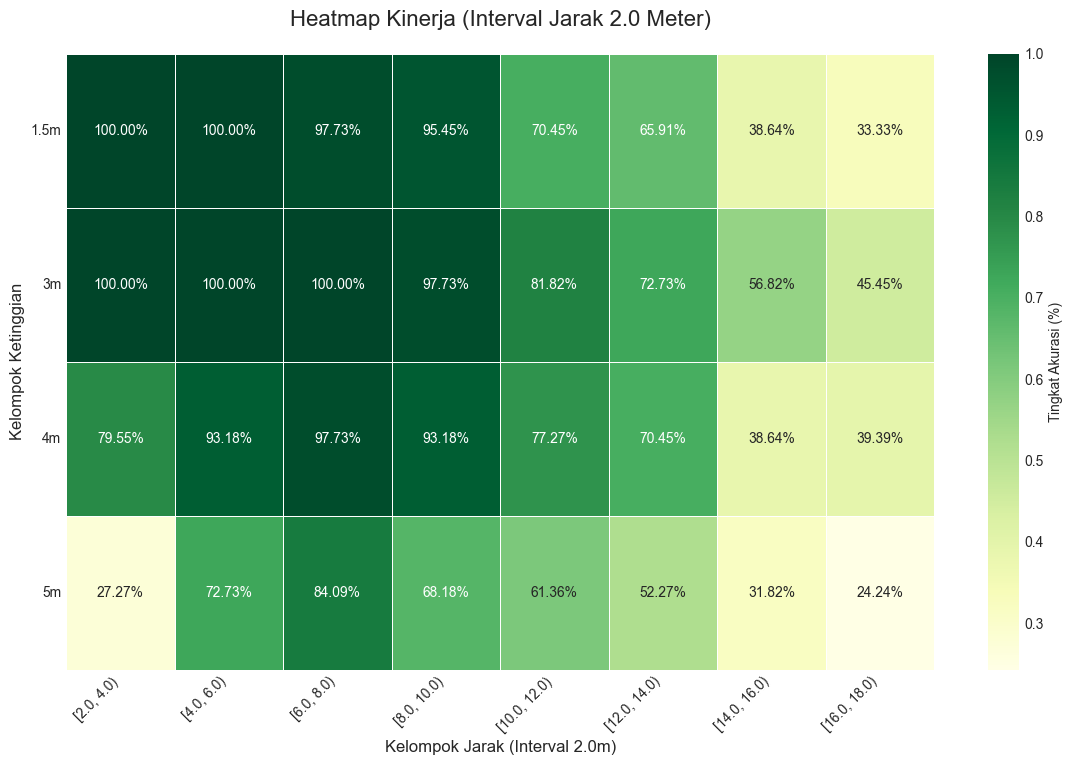

In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_performance_heatmap_interval(df: pd.DataFrame, results_path: str, interval: float = 2.0):
    """
    Membuat heatmap kinerja (akurasi) dengan interval jarak yang bisa diatur.
    """
    df_plot = df.copy()

    df_plot['distance_m'] = pd.to_numeric(df_plot['distance_m'], errors='coerce')
    df_plot['height_m'] = pd.to_numeric(df_plot['height_m'], errors='coerce')
    df_plot.dropna(subset=['distance_m', 'height_m', 'is_correct_B'], inplace=True)

    if df_plot.empty:
        print("INFO: Tidak ada data valid setelah dibersihkan.")
        return
    
    max_dist = df_plot['distance_m'].max()
    distance_bins = np.arange(0, max_dist + interval, interval)

    height_bins = [0, 2, 3.5, 4.5, 5.5]
    height_labels = ["1.5m", "3m", "4m", "5m"]
    

    try:
        df_plot['distance_group'] = pd.cut(df_plot['distance_m'], bins=distance_bins, right=False)
        df_plot['height_group'] = pd.cut(df_plot['height_m'], bins=height_bins, labels=height_labels, right=False)
    except ValueError as e:
        print(f"❌ Error saat membuat grup: {e}.")
        return

    try:
        performance_matrix = df_plot.pivot_table(
            index='height_group',
            columns='distance_group',
            values='is_correct_B',
            aggfunc='mean'
        )
    except Exception as e:
        print(f"❌ Gagal membuat pivot table. Error: {e}")
        return

    if performance_matrix.empty:
        print("INFO: Tidak ada data yang cukup untuk membuat performance heatmap.")
        return

    # Plotting heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        performance_matrix,
        annot=True,
        fmt='.2%',
        cmap='YlGn',
        linewidths=.5,
        cbar_kws={'label': 'Tingkat Akurasi (%)'}
    )
    plt.title(f'Heatmap Kinerja (Interval Jarak {interval} Meter)', fontsize=16, pad=20)
    plt.ylabel('Kelompok Ketinggian', fontsize=12)
    plt.xlabel(f'Kelompok Jarak (Interval {interval}m)', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    # Simpan file
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    file_path = os.path.join(results_path, f'performance_heatmap_{interval}m_interval.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"✅ Performance Heatmap (interval {interval}m) disimpan di: {file_path}")
    plt.show()


if 'df' in locals() and not df.empty:
    total_prediksi_berhasil = df['prediction_B'].notna().sum()
    print("-" * 40)
    print(f"Total Data yang Berhasil Diprediksi (prediction_B tidak null): {total_prediksi_berhasil}")
    print("-" * 40)
    plot_performance_heatmap_interval(df, "./results_v6.2/hasil_dengan_interval", interval=2.0)
else:
    print("❌ DataFrame kosong.")


##### 7.2.1 Confusion Matrix - Prediksi Benar


✅ Total Keseluruhan Prediksi Benar: 982
✅ Heatmap Jumlah Prediksi Benar (Tinggi Aktual) disimpan di: ./results_v6.2/hasil_tinggi_aktual\correct_count_actual_height_2.0m_interval.png


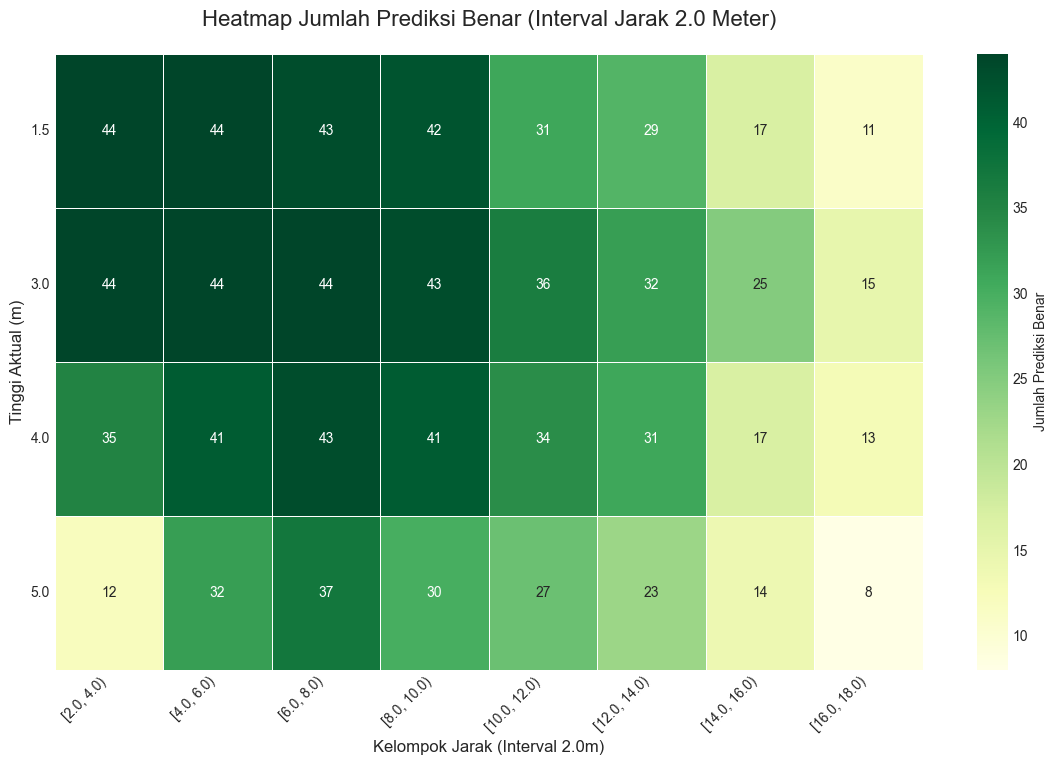

In [110]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_correct_count_heatmap(df: pd.DataFrame, results_path: str, interval: float = 2.0):
    df_plot = df.copy()

    # Pastikan tipe data numerik dan tidak ada nilai kosong
    df_plot['distance_m'] = pd.to_numeric(df_plot['distance_m'], errors='coerce')
    df_plot['height_m'] = pd.to_numeric(df_plot['height_m'], errors='coerce')
    df_plot.dropna(subset=['distance_m', 'height_m', 'is_correct_B'], inplace=True)

    if df_plot.empty:
        print("INFO: Tidak ada data valid setelah dibersihkan.")
        return

    max_dist = df_plot['distance_m'].max()
    distance_bins = np.arange(2, max_dist + interval, interval)
    
    try:
        df_plot['distance_group'] = pd.cut(df_plot['distance_m'], bins=distance_bins, right=False)
    except ValueError as e:
        print(f"❌ Error saat membuat grup jarak: {e}.")
        return

    try:
        performance_matrix = df_plot.pivot_table(
            index='height_m',      
            columns='distance_group', 
            values='is_correct_B',
            aggfunc='sum'
        )
    except Exception as e:
        print(f"❌ Gagal membuat pivot table. Error: {e}")
        return
        
    if performance_matrix.empty:
        print("INFO: Tidak ada data yang cukup untuk membuat heatmap.")
        return

    total_kebenaran = performance_matrix.sum().sum()
    print(f"✅ Total Keseluruhan Prediksi Benar: {int(total_kebenaran)}")

    # Plotting heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        performance_matrix,
        annot=True,
        fmt='g',
        cmap='YlGn',
        linewidths=.5,
        cbar_kws={'label': 'Jumlah Prediksi Benar'}
    )
    plt.title(f'Heatmap Jumlah Prediksi Benar (Interval Jarak {interval} Meter)', fontsize=16, pad=20)
    plt.ylabel('Tinggi Aktual (m)', fontsize=12) # <-- Label diubah
    plt.xlabel(f'Kelompok Jarak (Interval {interval}m)', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    if not os.path.exists(results_path):
        os.makedirs(results_path)
    file_path = os.path.join(results_path, f'correct_count_actual_height_{interval}m_interval.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"✅ Heatmap Jumlah Prediksi Benar (Tinggi Aktual) disimpan di: {file_path}")
    plt.show()

RESULTS_PATH = './results_v6.2/hasil_tinggi_aktual'

if not df.empty:
    plot_correct_count_heatmap(df, RESULTS_PATH, interval=2.0)
else:
    print("❌ DataFrame kosong.")

##### 7.2.1 Confusion Matrix - Prediksi Salah


✅ Total Keseluruhan Prediksi Salah: 367
✅ Heatmap Jumlah Prediksi Salah disimpan di: ./results_v6.2/hasil_prediksi_salah\incorrect_count_heatmap_2.0m_interval.png


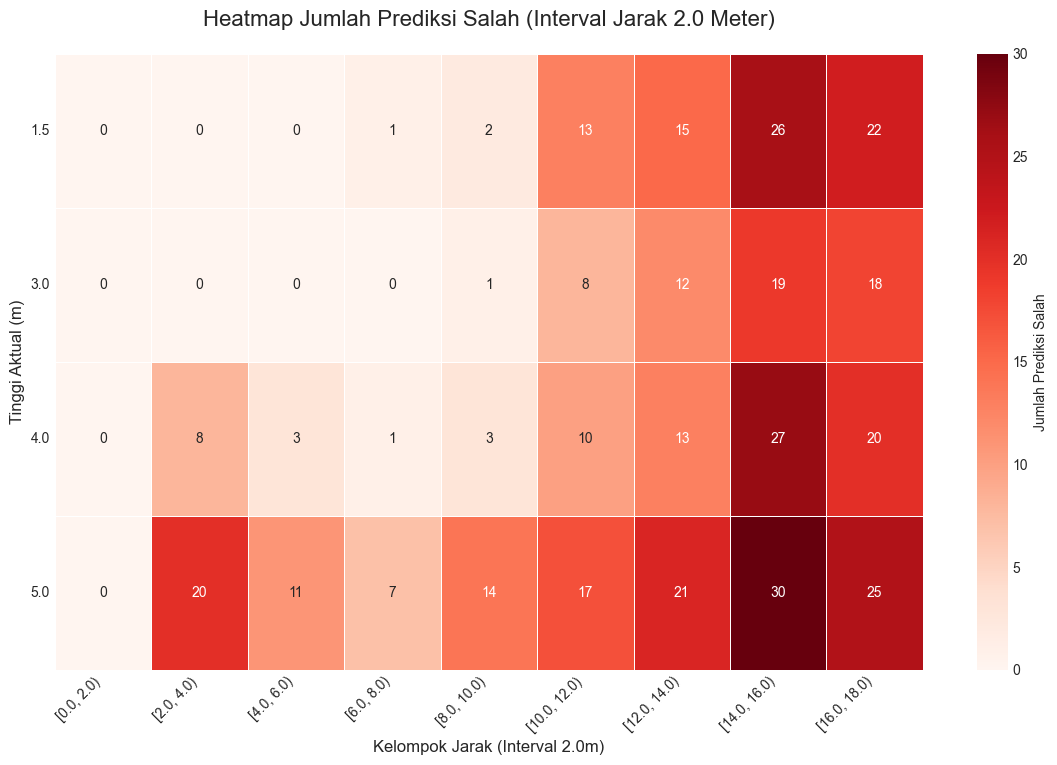

In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_incorrect_count_heatmap(df: pd.DataFrame, results_path: str, interval: float = 2.0):
    """
    Membuat heatmap yang menunjukkan JUMLAH PREDIKSI SALAH
    berdasarkan tinggi aktual dan interval jarak.
    """
    df_plot = df.copy()

    # Pastikan tipe data numerik
    df_plot['distance_m'] = pd.to_numeric(df_plot['distance_m'], errors='coerce')
    df_plot['height_m'] = pd.to_numeric(df_plot['height_m'], errors='coerce')
    
    # --- PERUBAHAN EKSPLISIT DI SINI ---
    # Hapus baris jika kolom-kolom kunci ini memiliki nilai null/NaN.
    # Secara eksplisit memeriksa 'prediction_B' sesuai permintaan Anda.
    df_plot.dropna(subset=['distance_m', 'height_m', 'prediction_B'], inplace=True)
    df_plot.dropna(subset=['distance_m', 'height_m', 'is_correct_B'], inplace=True)
    # --- AKHIR PERUBAHAN ---

    if df_plot.empty:
        print("INFO: Tidak ada data valid setelah dibersihkan.")
        return

    # Buat kolom baru 'is_incorrect'
    df_plot['is_incorrect'] = (df_plot['is_correct_B'] == False).astype(int)

    # Binning untuk Jarak
    max_dist = df_plot['distance_m'].max()
    distance_bins = np.arange(0, max_dist + interval, interval)
    
    try:
        df_plot['distance_group'] = pd.cut(df_plot['distance_m'], bins=distance_bins, right=False)
    except ValueError as e:
        print(f"❌ Error saat membuat grup jarak: {e}.")
        return

    # Pivot Table menggunakan kolom 'is_incorrect'
    try:
        incorrect_matrix = df_plot.pivot_table(
            index='height_m',
            columns='distance_group',
            values='is_incorrect',
            aggfunc='sum'
        )
    except Exception as e:
        print(f"❌ Gagal membuat pivot table. Error: {e}")
        return
        
    if incorrect_matrix.empty:
        print("INFO: Tidak ada data yang cukup untuk membuat heatmap prediksi salah.")
        return

    total_kesalahan = incorrect_matrix.sum().sum()
    print(f"✅ Total Keseluruhan Prediksi Salah: {int(total_kesalahan)}")

    # (Sisa kode plotting tetap sama...)
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        incorrect_matrix,
        annot=True,
        fmt='g',
        cmap='Reds',
        linewidths=.5,
        cbar_kws={'label': 'Jumlah Prediksi Salah'}
    )
    plt.title(f'Heatmap Jumlah Prediksi Salah (Interval Jarak {interval} Meter)', fontsize=16, pad=20)
    plt.ylabel('Tinggi Aktual (m)', fontsize=12)
    plt.xlabel(f'Kelompok Jarak (Interval {interval}m)', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    if not os.path.exists(results_path):
        os.makedirs(results_path)
    file_path = os.path.join(results_path, f'incorrect_count_heatmap_{interval}m_interval.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"✅ Heatmap Jumlah Prediksi Salah disimpan di: {file_path}")
    plt.show()

# --- CARA MENJALANKAN ---
RESULTS_PATH_SALAH = './results_v6.2/hasil_prediksi_salah'

if not df.empty:
    plot_incorrect_count_heatmap(df, RESULTS_PATH_SALAH, interval=2.0)
else:
    print("❌ DataFrame kosong.")

##### 7.2.1 Confusion Matrix - Prediksi Gagal


✅ Total Keseluruhan Prediksi Gagal: 15
✅ Heatmap Jumlah Gagal Prediksi disimpan di: ./results_v6.2/hasil_gagal_prediksi\failure_count_heatmap_2.0m_interval.png


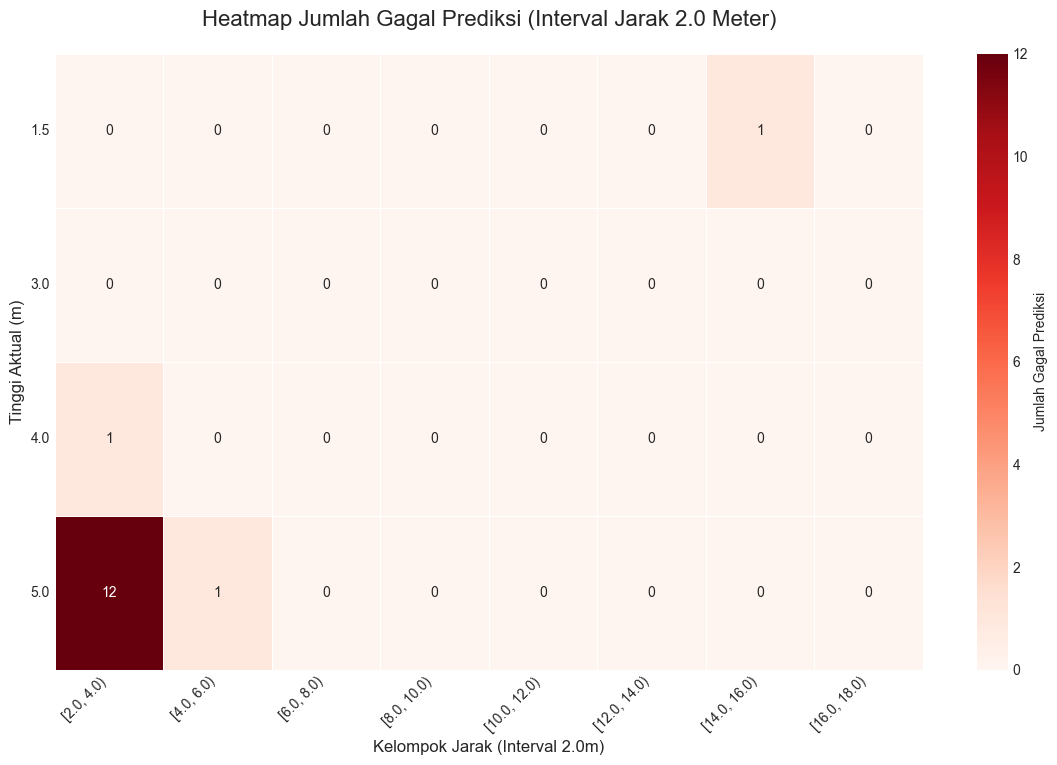

In [112]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_failure_count_heatmap(df: pd.DataFrame, results_path: str, interval: float = 2.0):
    """
    Membuat heatmap yang menunjukkan JUMLAH PREDIKSI GAGAL (NaN)
    berdasarkan tinggi aktual dan interval jarak.
    """
    df_plot = df.copy()

    # Di sini kita hanya dropna untuk kolom kondisi, bukan kolom prediksi
    df_plot.dropna(subset=['distance_m', 'height_m'], inplace=True)

    if df_plot.empty:
        print("INFO: Tidak ada data valid setelah dibersihkan.")
        return

    # --- PERUBAHAN UTAMA DI SINI ---

    # 1. Buat kolom baru 'is_failure'
    # .isna() menghasilkan True jika prediksi NaN, .astype(int) mengubah True->1, False->0
    df_plot['is_failure'] = df_plot['prediction_B'].isna().astype(int)

    # 2. Binning untuk Jarak (tetap sama)
    max_dist = df_plot['distance_m'].max()
    distance_bins = np.arange(2, max_dist + interval, interval)
    
    try:
        df_plot['distance_group'] = pd.cut(df_plot['distance_m'], bins=distance_bins, right=False)
    except ValueError as e:
        print(f"❌ Error saat membuat grup jarak: {e}.")
        return

    # 3. Pivot Table menggunakan kolom 'is_failure' yang baru
    try:
        failure_matrix = df_plot.pivot_table(
            index='height_m',
            columns='distance_group',
            values='is_failure', # <-- Gunakan kolom penanda kegagalan
            aggfunc='sum'
        )
    except Exception as e:
        print(f"❌ Gagal membuat pivot table. Error: {e}")
        return
        
    # --- AKHIR PERUBAHAN ---

    if failure_matrix.empty:
        print("INFO: Tidak ada data yang cukup untuk membuat heatmap kegagalan.")
        return

    total_kegagalan = failure_matrix.sum().sum()
    print(f"✅ Total Keseluruhan Prediksi Gagal: {int(total_kegagalan)}")

    # Plotting heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        failure_matrix,
        annot=True,
        fmt='g',
        cmap='Reds', # <-- Skema warna diubah menjadi merah untuk indikasi 'buruk'
        linewidths=.5,
        cbar_kws={'label': 'Jumlah Gagal Prediksi'} # <-- Label color bar diubah
    )
    plt.title(f'Heatmap Jumlah Gagal Prediksi (Interval Jarak {interval} Meter)', fontsize=16, pad=20)
    plt.ylabel('Tinggi Aktual (m)', fontsize=12)
    plt.xlabel(f'Kelompok Jarak (Interval {interval}m)', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    # Simpan file
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    file_path = os.path.join(results_path, f'failure_count_heatmap_{interval}m_interval.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"✅ Heatmap Jumlah Gagal Prediksi disimpan di: {file_path}")
    plt.show()


# --- CARA MENJALANKAN ---
# Anda bisa menjalankan ini setelah heatmap keberhasilan
RESULTS_PATH_GAGAL = './results_v6.2/hasil_gagal_prediksi'

if not df.empty:
    plot_failure_count_heatmap(df, RESULTS_PATH_GAGAL, interval=2.0)
else:
    print("❌ DataFrame kosong.")

# Kasus Uji


### Kasus Uji 1 Robustness Terhadap Kualitas dan Resolusi Gambar 🔬

Tujuan: Mengukur bagaimana penurunan resolusi wajah (akibat jarak yang lebih jauh) memengaruhi akurasi.

Hipotesis: Akurasi akan menurun secara signifikan seiring bertambahnya jarak (ID Jarak mengecil). Anda bisa menunjukkan seberapa besar peran GFPGAN dalam "menyelamatkan" wajah beresolusi rendah.

Visualisasi: Buat grafik plot garis dengan sumbu X adalah Jarak (meter) dan sumbu Y adalah Akurasi. Ini akan menjadi visualisasi yang sangat kuat di skripsi Anda.


In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. MEMUAT DATA ---
# Ganti 'hasil_inferensi.json' dengan nama file JSON Anda yang sebenarnya.
file_path = r'D:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results_v6.2\pipeline_results_final.json'
df = pd.read_json(file_path)

# --- 2. EKSTRAKSI DATA METADATA ---
# Untuk mempermudah, kita akan "ratakan" data metadata ke kolom utama DataFrame.
# Ini akan membuat kolom baru: 'distance_m' dan 'height_m'
df['distance_m'] = df['metadata'].apply(lambda x: x['distance_m'])
df['height_m'] = df['metadata'].apply(lambda x: x['height_m'])

# Tampilkan 5 baris pertama untuk memastikan data termuat dengan benar
print("Data setelah dimuat dan diratakan:")
print(df.head())

Data setelah dimuat dan diratakan:
               file                                           metadata  \
0  a_gp_0_ef_00.jpg  {'subject_id': 'a', 'distance_m': 17.0, 'heigh...   
1  a_gp_0_ef_01.jpg  {'subject_id': 'a', 'distance_m': 16.5, 'heigh...   
2  a_gp_0_ef_02.jpg  {'subject_id': 'a', 'distance_m': 16.0, 'heigh...   
3  a_gp_0_ef_03.jpg  {'subject_id': 'a', 'distance_m': 15.5, 'heigh...   
4  a_gp_0_ef_04.jpg  {'subject_id': 'a', 'distance_m': 15.0, 'heigh...   

  ground_truth prediction_A  is_correct_A prediction_B  is_correct_B  \
0            a            a          True            a          True   
1            a            a          True            d         False   
2            a            a          True            d         False   
3            a            a          True            d         False   
4            a            a          True            c         False   

   restoration_succeeded  confidence_score  brisque_original_img  \
0                  

In [131]:
# --- 3. MEMBUAT KELOMPOK JARAK (BINS) ---
# Kita akan membuat kelompok jarak setiap 2 meter, dari 0 hingga 18 meter.
# Labelnya akan menjadi titik tengah setiap kelompok, misal kelompok 0-2m diberi label 1m.
bins = np.arange(0, 20, 2) # Membuat batasan: 0, 2, 4, ..., 18
labels = (bins[:-1] + bins[1:]) / 2 # Membuat label titik tengah: 1, 3, 5, ..., 17

df['distance_bin'] = pd.cut(df['distance_m'], bins=bins, labels=labels, right=False)

# --- 4. MENGHITUNG AKURASI PER KELOMPOK ---
# Kita kelompokkan berdasarkan 'distance_bin' dan hitung rata-rata
# dari kolom boolean ('is_correct_A' dan 'is_correct_B').
# Menghitung rata-rata dari kolom True/False secara otomatis memberikan nilai akurasi.
accuracy_data = df.groupby('distance_bin')[['is_correct_A', 'is_correct_B']].mean().reset_index()
accuracy_data.columns = ['Jarak (m)', 'Akurasi Tanpa Restorasi (A)', 'Akurasi Dengan Restorasi (B)']

print("\nData akurasi per kelompok jarak:")
print(accuracy_data)


Data akurasi per kelompok jarak:
  Jarak (m)  Akurasi Tanpa Restorasi (A)  Akurasi Dengan Restorasi (B)
0       1.0                          NaN                           NaN
1       3.0                     0.795455                      0.767045
2       5.0                     0.926136                      0.914773
3       7.0                     0.926136                      0.948864
4       9.0                     0.750000                      0.886364
5      11.0                     0.431818                      0.727273
6      13.0                     0.215909                      0.653409
7      15.0                     0.119318                      0.414773
8      17.0                     0.098485                      0.356061


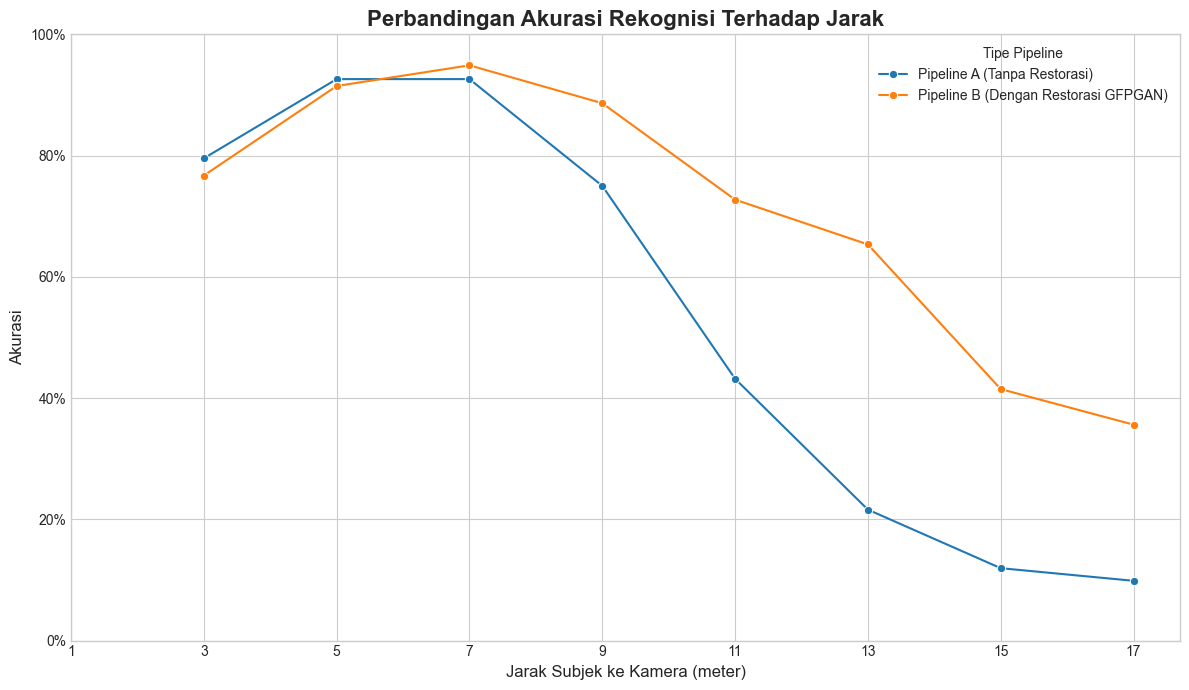

In [132]:
# --- 5. MEMBUAT PLOT GRAFIK ---
plt.style.use('seaborn-v0_8-whitegrid') # Menggunakan style agar grafik terlihat bagus
fig, ax = plt.subplots(figsize=(12, 7)) # Mengatur ukuran gambar

# Plot untuk Pipeline A (Tanpa Restorasi)
sns.lineplot(
    data=accuracy_data,
    x='Jarak (m)',
    y='Akurasi Tanpa Restorasi (A)',
    label='Pipeline A (Tanpa Restorasi)',
    marker='o', # Memberi tanda titik pada setiap data
    ax=ax
)

# Plot untuk Pipeline B (Dengan Restorasi)
sns.lineplot(
    data=accuracy_data,
    x='Jarak (m)',
    y='Akurasi Dengan Restorasi (B)',
    label='Pipeline B (Dengan Restorasi GFPGAN)',
    marker='o', # Memberi tanda titik pada setiap data
    ax=ax
)

# --- 6. MENAMBAHKAN JUDUL DAN LABEL ---
ax.set_title('Perbandingan Akurasi Rekognisi Terhadap Jarak', fontsize=16, fontweight='bold')
ax.set_xlabel('Jarak Subjek ke Kamera (meter)', fontsize=12)
ax.set_ylabel('Akurasi', fontsize=12)
ax.legend(title='Tipe Pipeline')

# Mengatur agar sumbu Y menunjukkan persentase
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.set_ylim(0, 1) # Batasi sumbu Y dari 0 hingga 1 (0% hingga 100%)
ax.set_xticks(labels) # Pastikan semua label jarak muncul di sumbu X

plt.tight_layout() # Merapikan layout
plt.show()

### Kasus Uji 2 Pengaruh Ketinggian Kamera (Pose Wajah)

Tujuan: Mengukur bagaimana penurunan resolusi wajah (akibat jarak yang lebih jauh) memengaruhi akurasi.

Hipotesis: Akurasi akan menurun secara signifikan seiring bertambahnya jarak (ID Jarak mengecil). Anda bisa menunjukkan seberapa besar peran GFPGAN dalam "menyelamatkan" wajah beresolusi rendah.

Visualisasi: Buat grafik plot garis dengan sumbu X adalah Jarak (meter) dan sumbu Y adalah Akurasi. Ini akan menjadi visualisasi yang sangat kuat di skripsi Anda.


In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. MEMUAT DATA (Jika belum ada di memori) ---
# Anda bisa melewati bagian ini jika DataFrame 'df' sudah ada dari langkah sebelumnya.
df = pd.read_json(file_path)
df['distance_m'] = df['metadata'].apply(lambda x: x['distance_m'])
df['height_m'] = df['metadata'].apply(lambda x: x['height_m'])
df['height_id'] = df['metadata'].apply(lambda x: x['height_id'])

# --- 2. MENYARING DATA UNTUK KASUS UJI 2.3 ---
# Pilih hanya data dengan height_id '0' (1.5m) dan '5' (5m).
height_data = df[df['height_id'].isin(['0', '5'])].copy()

# Ganti ID dengan label yang lebih deskriptif untuk grafik
height_data['Ketinggian Kamera'] = height_data['height_id'].map({
    '0': '1.5 meter (Lurus)',
    '5': '5 meter (Sudut Atas)'
})

print("Contoh data yang telah disaring:")
print(height_data[['file', 'Ketinggian Kamera', 'is_correct_A', 'is_correct_B']].head())

Contoh data yang telah disaring:
               file  Ketinggian Kamera  is_correct_A  is_correct_B
0  a_gp_0_ef_00.jpg  1.5 meter (Lurus)          True          True
1  a_gp_0_ef_01.jpg  1.5 meter (Lurus)          True         False
2  a_gp_0_ef_02.jpg  1.5 meter (Lurus)          True         False
3  a_gp_0_ef_03.jpg  1.5 meter (Lurus)          True         False
4  a_gp_0_ef_04.jpg  1.5 meter (Lurus)          True         False


In [134]:
# --- 3. MENGHITUNG AKURASI PER KETINGGIAN ---
accuracy_by_height = height_data.groupby('Ketinggian Kamera')[['is_correct_A', 'is_correct_B']].mean().reset_index()

# --- 4. MENGUBAH FORMAT DATA (MELTING) ---
# Mengubah dari format "lebar" ke "panjang" agar mudah diplot sebagai grup.
accuracy_melted = accuracy_by_height.melt(
    id_vars='Ketinggian Kamera',
    value_vars=['is_correct_A', 'is_correct_B'],
    var_name='Tipe Pipeline',
    value_name='Akurasi'
)

# Ganti nama pipeline menjadi lebih deskriptif
accuracy_melted['Tipe Pipeline'] = accuracy_melted['Tipe Pipeline'].map({
    'is_correct_A': 'Tanpa Restorasi (A)',
    'is_correct_B': 'Dengan Restorasi (B)'
})

print("\nData yang siap divisualisasikan:")
print(accuracy_melted)


Data yang siap divisualisasikan:
      Ketinggian Kamera         Tipe Pipeline   Akurasi
0     1.5 meter (Lurus)   Tanpa Restorasi (A)  0.621701
1  5 meter (Sudut Atas)   Tanpa Restorasi (A)  0.387097
2     1.5 meter (Lurus)  Dengan Restorasi (B)  0.765396
3  5 meter (Sudut Atas)  Dengan Restorasi (B)  0.536657


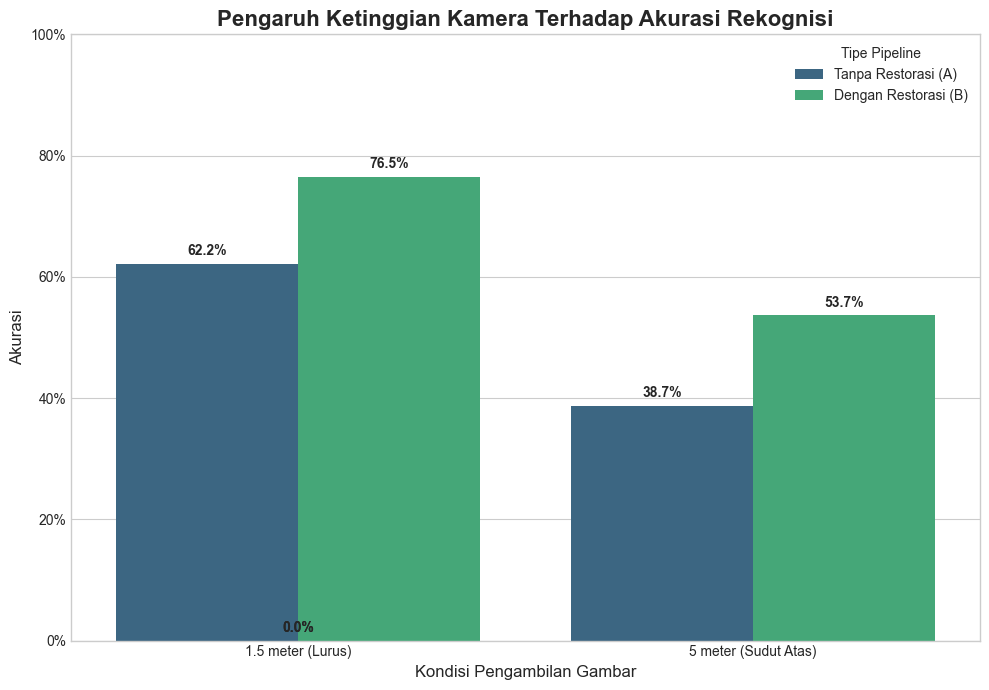

In [135]:
# --- 5. MEMBUAT PLOT DIAGRAM BATANG ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 7))

# Membuat bar plot dengan Seaborn
sns.barplot(
    data=accuracy_melted,
    x='Ketinggian Kamera',
    y='Akurasi',
    hue='Tipe Pipeline', # Parameter ini membuat grup batang
    palette='viridis', # Skema warna
    ax=ax
)

# --- 6. MENAMBAHKAN LABEL NILAI DI ATAS BATANG ---
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.1%}', # Format sebagai persentase
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 9),
        textcoords='offset points',
        fontweight='bold'
    )

# --- 7. MENAMBAHKAN JUDUL DAN LABEL ---
ax.set_title('Pengaruh Ketinggian Kamera Terhadap Akurasi Rekognisi', fontsize=16, fontweight='bold')
ax.set_xlabel('Kondisi Pengambilan Gambar', fontsize=12)
ax.set_ylabel('Akurasi', fontsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.set_ylim(0, 1) # Atur batas sumbu Y dari 0% hingga 100%

plt.tight_layout()
plt.show()

### Kasus Uji 3 Studi Ablasi

Tujuan: Menunjukkan secara langsung kontribusi modul GFPGAN terhadap ketahanan sistem secara keseluruhan.

Metode:

Pipeline Tanpa Restorasi: Ambil gambar mentah berkualitas rendah (misalnya, dari jarak jauh) dan langsung masukkan ke ArcFace (setelah deteksi dan alignment standar). Catat akurasinya.

Pipeline Lengkap: Ambil set gambar yang sama, jalankan melalui GFPGAN terlebih dahulu, lalu ke ArcFace. Catat akurasinya.

Hasil yang Diharapkan: Akan ada peningkatan akurasi yang signifikan pada Pipeline Lengkap. Selisih inilah bukti kuantitatif bahwa GFPGAN membuat sistem Anda lebih robust terhadap input berkualitas rendah.


In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. MEMUAT DATA (Jika belum ada di memori) ---
df = pd.read_json(file_path)
df['distance_m'] = df['metadata'].apply(lambda x: x['distance_m'])
df['height_id'] = df['metadata'].apply(lambda x: x['height_id'])

# --- 2. MENYARING DATASET YANG MENANTANG ---
# Kita definisikan "menantang" sebagai gambar dengan jarak lebih dari 10 meter.
# Angka ini bisa Anda sesuaikan sesuai dengan analisis Anda.
jarak_minimum_menantang = 6
challenging_data = df[df['distance_m'] > jarak_minimum_menantang].copy()

print(f"Jumlah data menantang (jarak > {jarak_minimum_menantang}m): {len(challenging_data)} baris")

Jumlah data menantang (jarak > 6m): 968 baris


In [137]:
# --- 3. MENGHITUNG AKURASI RATA-RATA ---
accuracy_A = challenging_data['is_correct_A'].mean()
accuracy_B = challenging_data['is_correct_B'].mean()

# --- 4. MEMBUAT DATAFRAME UNTUK PLOTTING ---
ablation_results = pd.DataFrame({
    'Tipe Pipeline': ['Tanpa Restorasi (A)', 'Dengan Restorasi (B)'],
    'Akurasi': [accuracy_A, accuracy_B]
})

print("\nHasil Studi Ablasi pada Data Menantang:")
print(ablation_results)


Hasil Studi Ablasi pada Data Menantang:
          Tipe Pipeline   Akurasi
0   Tanpa Restorasi (A)  0.414256
1  Dengan Restorasi (B)  0.664256


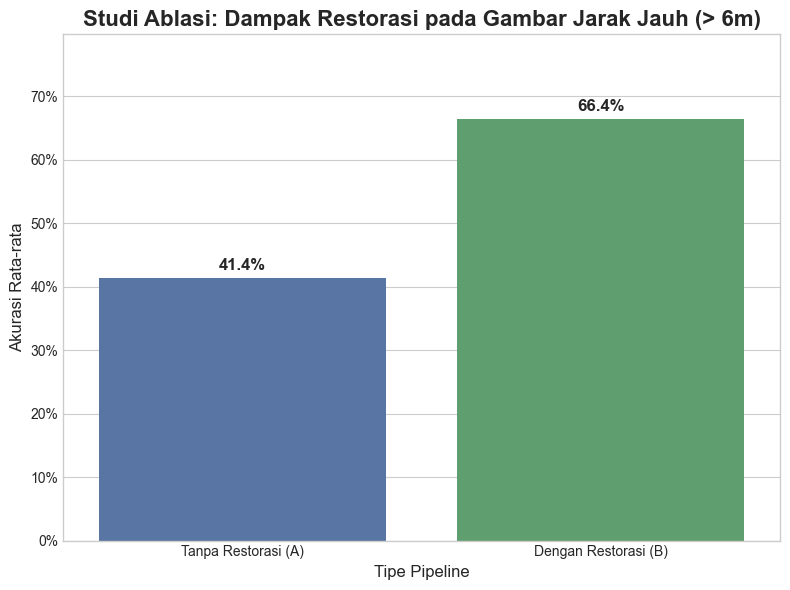


Analisis Peningkatan Kinerja:
Peningkatan akurasi absolut: 25.0%
Peningkatan akurasi relatif: 60.3%


In [138]:
# --- 5. MEMBUAT PLOT DIAGRAM BATANG ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

# Membuat bar plot
barplot = sns.barplot(
    data=ablation_results,
    x='Tipe Pipeline',
    y='Akurasi',
    palette=['#4c72b0', '#55a868'] # Warna biru dan hijau
)

# --- 6. MENAMBAHKAN LABEL NILAI DI ATAS BATANG ---
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.1%}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 9),
        textcoords='offset points',
        fontweight='bold',
        fontsize=12
    )

# --- 7. MENAMBAHKAN JUDUL DAN LABEL ---
ax.set_title(f'Studi Ablasi: Dampak Restorasi pada Gambar Jarak Jauh (> {jarak_minimum_menantang}m)', fontsize=16, fontweight='bold')
ax.set_xlabel('Tipe Pipeline', fontsize=12)
ax.set_ylabel('Akurasi Rata-rata', fontsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.set_ylim(0, max(ablation_results['Akurasi']) * 1.2) # Atur batas Y agar ada ruang untuk label

plt.tight_layout()
plt.show()

# Hitung peningkatan performa
peningkatan_absolut = (accuracy_B - accuracy_A) * 100
peningkatan_relatif = ((accuracy_B - accuracy_A) / accuracy_A) * 100 if accuracy_A > 0 else float('inf')

print(f"\nAnalisis Peningkatan Kinerja:")
print(f"Peningkatan akurasi absolut: {peningkatan_absolut:.1f}%")
print(f"Peningkatan akurasi relatif: {peningkatan_relatif:.1f}%")


# Uji Kualitatif


🏆 VISUALISASI LENGKAP 3 KASUS TERBAIK 🏆


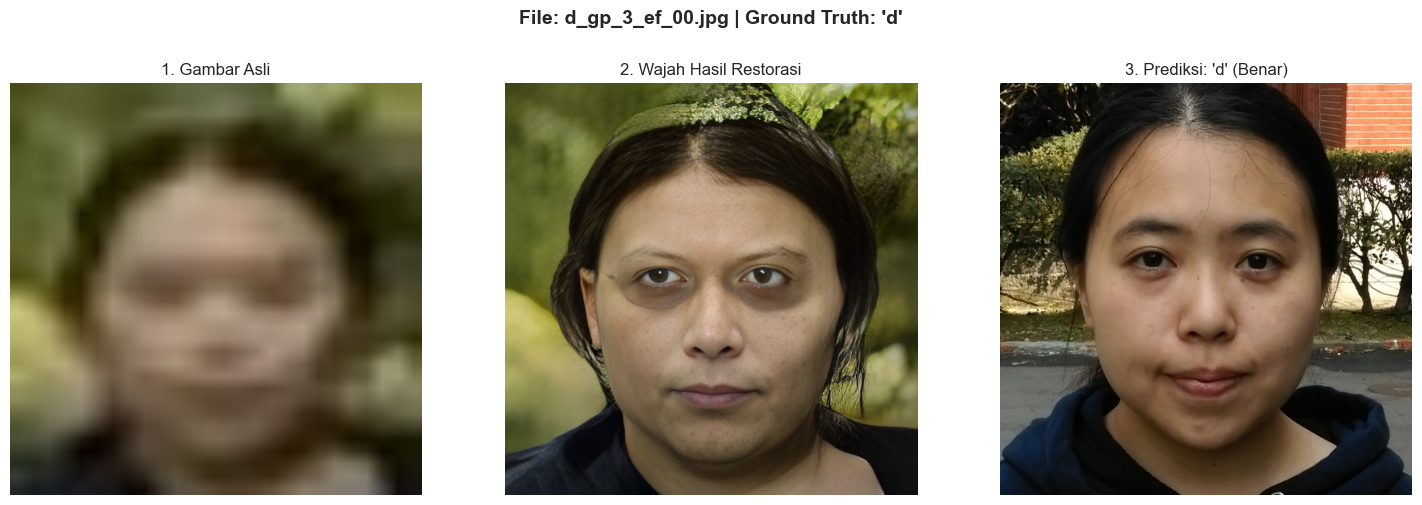

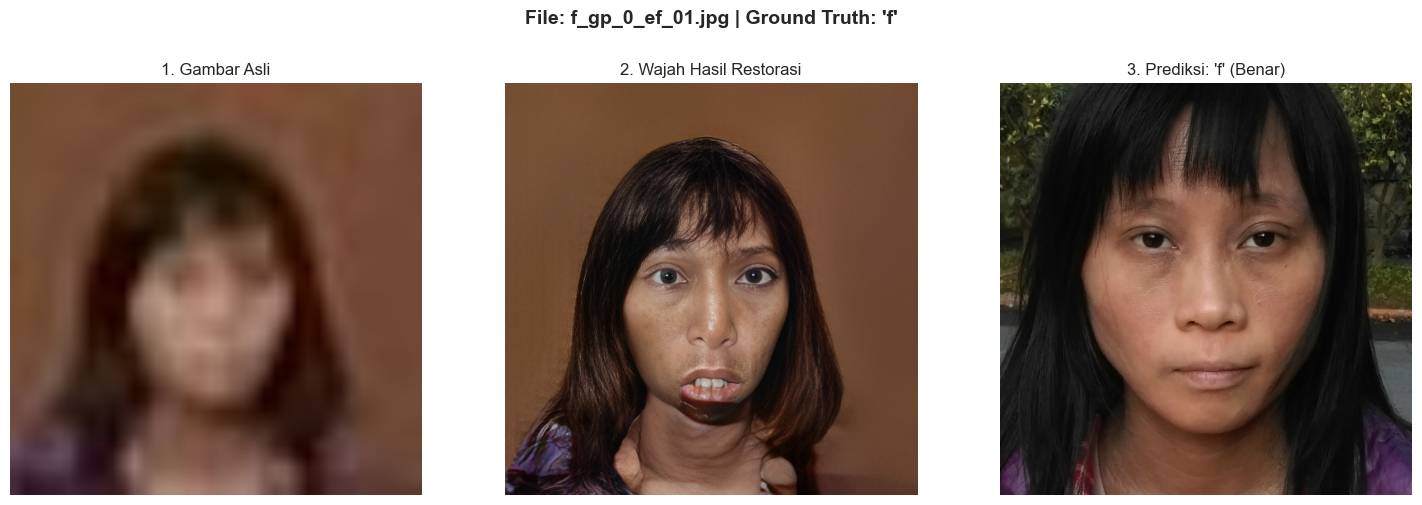

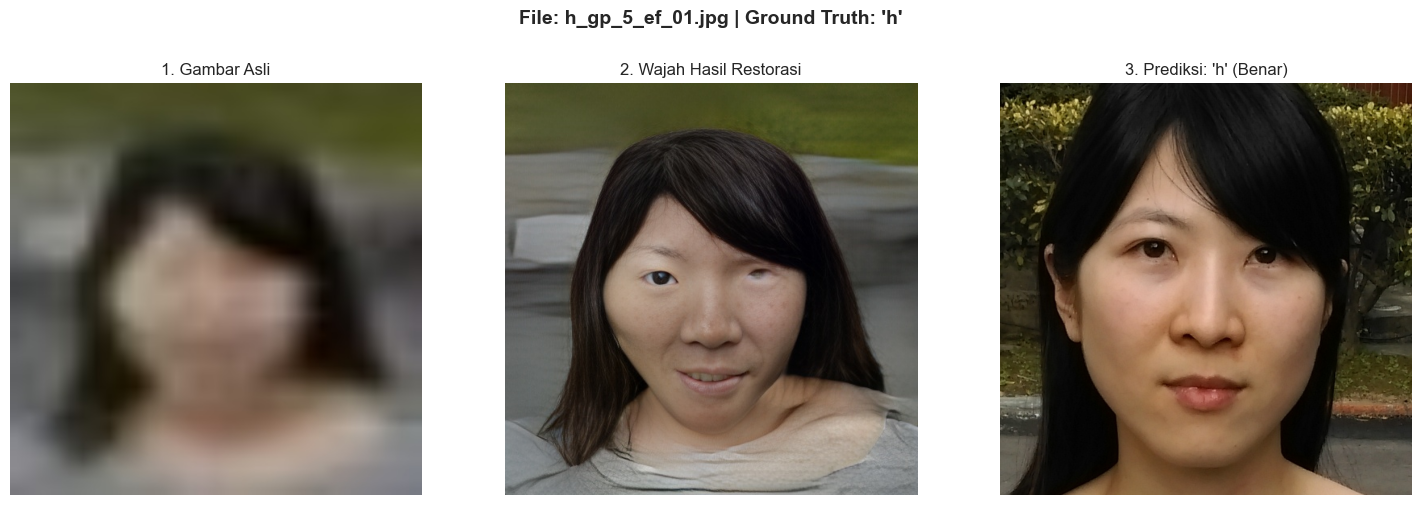


🚧 VISUALISASI LENGKAP 3 KASUS GAGAL 🚧


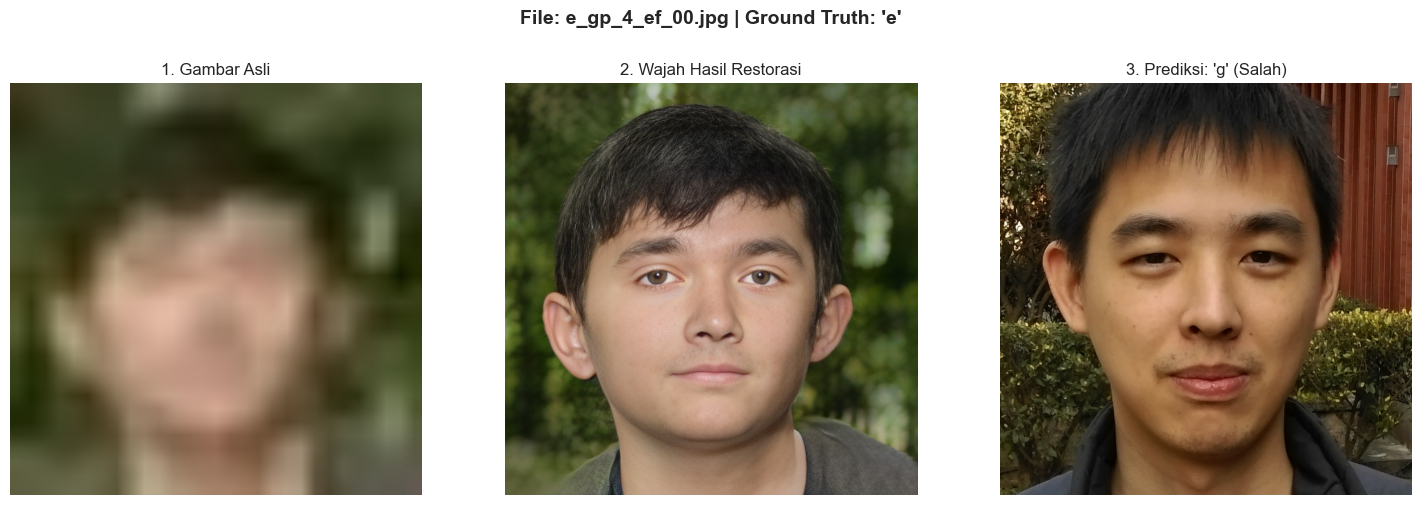

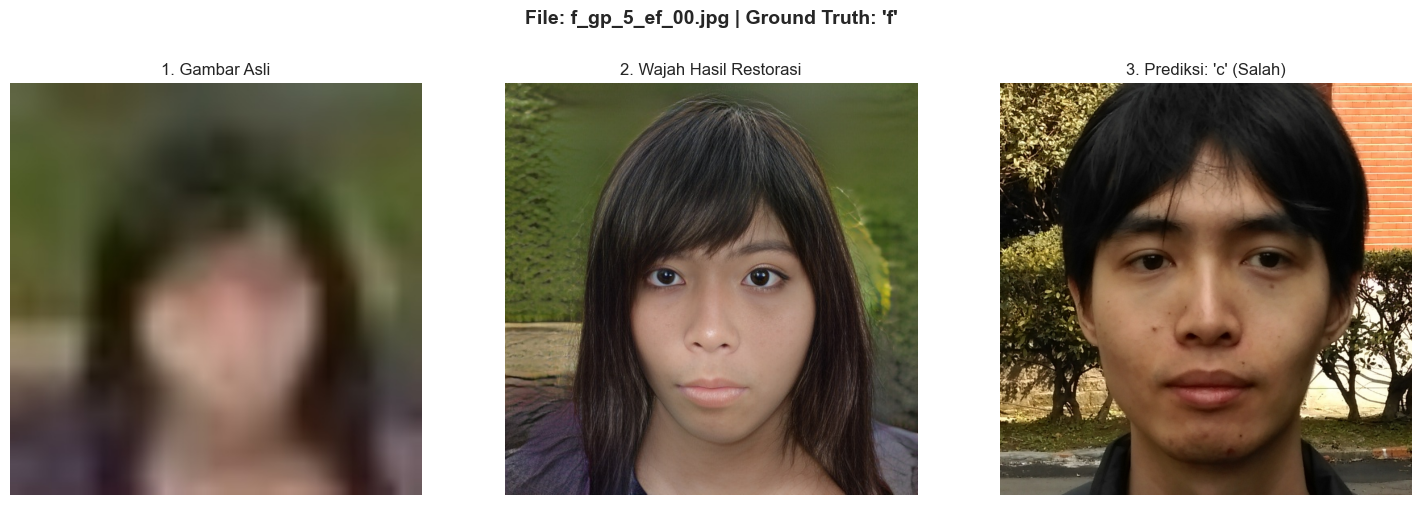

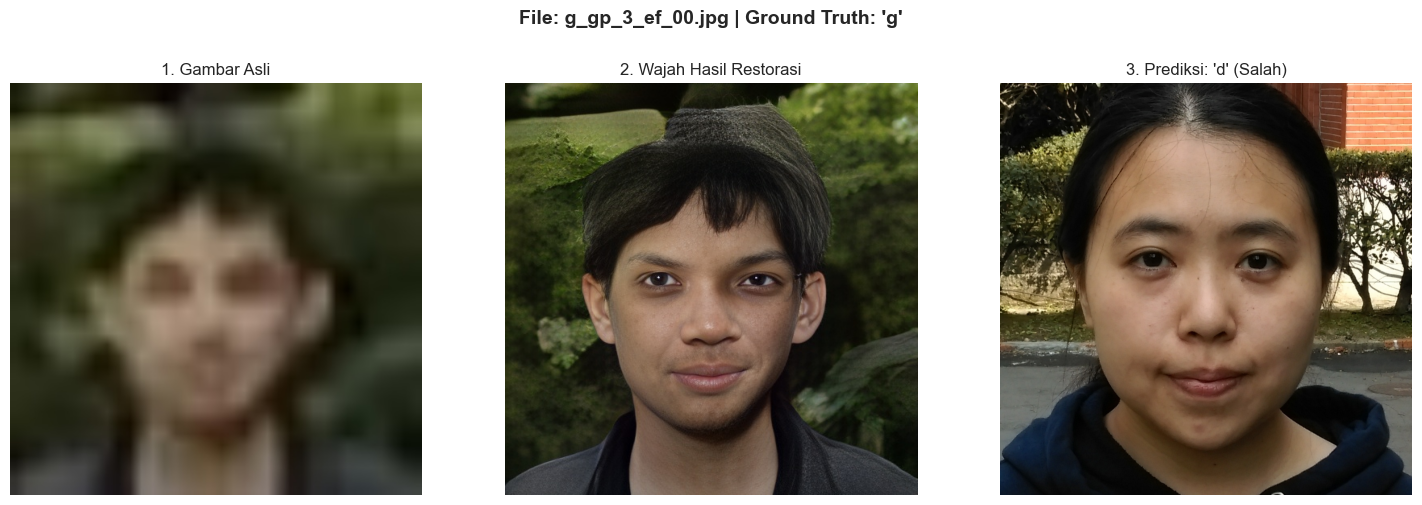

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2 # OpenCV untuk membaca gambar
import os

# --- 1. PENGATURAN & MEMUAT DATA ---
JUMLAH_KANDIDAT_TAMPIL = 3

# PENTING: Sesuaikan semua path ini dengan struktur folder Anda!
PATH_GAMBAR_ASLI = r'D:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results_v6.1\cropped_faces'
PATH_WAJAH_RESTORED = r'D:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results_v6.1\restored_faces'
PATH_GAMBAR_REFERENSI = r'D:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\data\gallery6.1' # <-- PATH BARU
FORMAT_FILE_REFERENSI = r'_cam_0_porF_00.jpg' # <-- Sesuaikan format nama file referensi jika perlu

df = pd.read_json(file_path)
df['distance_m'] = df['metadata'].apply(lambda x: x.get('distance_m'))

# --- 2. LOGIKA UNTUK MENEMUKAN KANDIDAT ---
best_cases_filter = (df['is_correct_A'] == False) & (df['is_correct_B'] == True)
best_candidates = df[best_cases_filter].sort_values(by='brisque_original_img', ascending=False)

worst_cases_filter = (df['is_correct_B'] == False)
worst_candidates = df[worst_cases_filter].sort_values(by='distance_m', ascending=False)


# --- 3. FUNGSI UNTUK MENAMPILKAN GAMBAR (DIPERBARUI) ---
def display_full_comparison(row_data):
    """Fungsi untuk menampilkan 3 gambar: asli, restorasi, dan prediksi."""
    
    filename = row_data['file']
    prediction_B = row_data['prediction_B']
    
    # Path untuk 3 gambar
    path_asli = os.path.join(PATH_GAMBAR_ASLI, filename)
    path_restored = os.path.join(PATH_WAJAH_RESTORED, filename)
    filename_prediksi = f"{prediction_B}{FORMAT_FILE_REFERENSI}"
    path_prediksi = os.path.join(PATH_GAMBAR_REFERENSI, filename_prediksi)

    # Buat subplot dengan 3 panel
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Panel 1: Gambar Asli
    try:
        img_asli = cv2.cvtColor(cv2.imread(path_asli), cv2.COLOR_BGR2RGB)
        axes[0].imshow(img_asli)
    except Exception:
        axes[0].text(0.5, 0.5, 'Gambar Asli\nTidak Ditemukan', ha='center')
    axes[0].set_title('1. Gambar Asli')
    axes[0].axis('off')

    # Panel 2: Wajah Hasil Restorasi
    try:
        img_restored = cv2.cvtColor(cv2.imread(path_restored), cv2.COLOR_BGR2RGB)
        axes[1].imshow(img_restored)
    except Exception:
        axes[1].text(0.5, 0.5, 'Wajah Restorasi\nTidak Ditemukan', ha='center')
    axes[1].set_title('2. Wajah Hasil Restorasi')
    axes[1].axis('off')
    
    # Panel 3: Potret HQ Hasil Prediksi
    try:
        img_prediksi = cv2.cvtColor(cv2.imread(path_prediksi), cv2.COLOR_BGR2RGB)
        axes[2].imshow(img_prediksi)
    except Exception:
         axes[2].text(0.5, 0.5, f"Referensi '{prediction_B}'\nTidak Ditemukan", ha='center')
    hasil_prediksi_text = 'Benar' if row_data['is_correct_B'] else 'Salah'
    axes[2].set_title(f"3. Prediksi: '{prediction_B}' ({hasil_prediksi_text})")
    axes[2].axis('off')

    # Judul utama
    title = f"File: {filename} | Ground Truth: '{row_data['ground_truth']}'"
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.0)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Atur layout agar judul tidak tumpang tindih
    plt.show()

# --- 4. TAMPILKAN VISUALISASI LENGKAP ---
print("="*50)
print(f"🏆 VISUALISASI LENGKAP {JUMLAH_KANDIDAT_TAMPIL} KASUS TERBAIK 🏆")
print("="*50)
for index, row in best_candidates.head(JUMLAH_KANDIDAT_TAMPIL).iterrows():
    display_full_comparison(row)

print("\n" + "="*50)
print(f"🚧 VISUALISASI LENGKAP {JUMLAH_KANDIDAT_TAMPIL} KASUS GAGAL 🚧")
print("="*50)
for index, row in worst_candidates.head(JUMLAH_KANDIDAT_TAMPIL).iterrows():
    display_full_comparison(row)